# emopt

In [1]:
# imports
from pathlib import Path
from multiprocessing import Pool
import socket
import pickle
from datetime import datetime
from time import time
from os import path, makedirs, chmod
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
home = str( Path.home() )
om_subdirs = ['nlo','dispersion']
for subdir in om_subdirs:
    dd = home+'/github/optics_modeling/'+subdir
    if dd not in sys.path:
        sys.path.append(dd)
import NLO_tools as nlo



u = nlo.u

def _n_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_MgO_LN(λ*u.um,T,axis=axis)[0,0]

def _ng_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_g_MgO_LN(λ*u.um,T,axis=axis)

def _n_si3n4(λ,T=300*u.degK):
    return nlo.n_Si3N4(λ*u.um,T)[0,0]

def _ng_si3n4(λ,T=300*u.degK):
    return nlo.n_g_Si3N4(λ*u.um,T)

def _n_sio2(λ,T=300*u.degK):
    return nlo.n_SiO2(λ*u.um,T)[0,0]

def _ng_sio2(λ,T=300*u.degK):
    return nlo.n_g_SiO2(λ*u.um,T)

def _n_mgf2(λ,T=300*u.degK):
    return nlo.n_MgF2(λ*u.um,T)

def _ng_mgf2(λ,T=300*u.degK):
    return nlo.n_g_MgF2(λ*u.um,T)

In [52]:
# emopt's "3D" (full vectorial, 2D slice of 3D structure) mode solve example
import emopt
from emopt.misc import NOT_PARALLEL

import numpy as np
from math import pi

from petsc4py import PETSc
from mpi4py import MPI

####################################################################################
# Simulation parameters
####################################################################################
t_core = 0.73
w_core = 1.65
wavelength = 1.55

n_grid = 100
X = 1.0 #4. # 5.0
Y = 6.0 # 3.0
Z = 4.0 # 2.5
dx = 0.04 #0.04
dy = Y / n_grid #0.04
dz = Z / n_grid / 2. #0.04



#####################################################################################
# Setup simulation
#####################################################################################
sim = emopt.fdtd.FDTD(X,Y,Z,dx,dy,dz,wavelength, rtol=1e-5)
w_pml = dy * 15
sim.w_pml = [w_pml, w_pml, w_pml, w_pml, w_pml, w_pml]

X = sim.X
Y = sim.Y
Z = sim.Z

Nx = sim.Nx
Ny = sim.Ny
Nz = sim.Nz

#####################################################################################
# Define the geometry/materials
#####################################################################################
r1 = emopt.grid.Rectangle(X/2, Y/2, 2*X, w_core); r1.layer = 1
r2 = emopt.grid.Rectangle(X/2, Y/2, 2*X, 2*Y); r2.layer = 2

λ = wavelength
n_core = _n_si3n4(λ)
r1.material_value = n_core**2
r2.material_value = _n_sio2(λ)**2

eps = emopt.grid.StructuredMaterial3D(X, Y, Z, dx, dy, dz)
eps.add_primitive(r2, -Z, Z)
eps.add_primitive(r1, Z/2-t_core/2., Z/2+t_core/2.)

mu = emopt.grid.ConstantMaterial3D(1.0)

sim.set_materials(eps, mu)
sim.build()

#####################################################################################
# Setup the sources
#####################################################################################
mode_slice = emopt.misc.DomainCoordinates(0.8, 0.8, w_pml, Y-w_pml, w_pml, Z-w_pml, dx, dy, dz)

mode = emopt.modes.ModeFullVector(wavelength, eps, mu, mode_slice, n0=n_core,
                                   neigs=4)
mode.build()
mode.solve()




[INFO] Building FDTD system...
[INFO] Building mode solver system matrix...
[INFO] Solving...


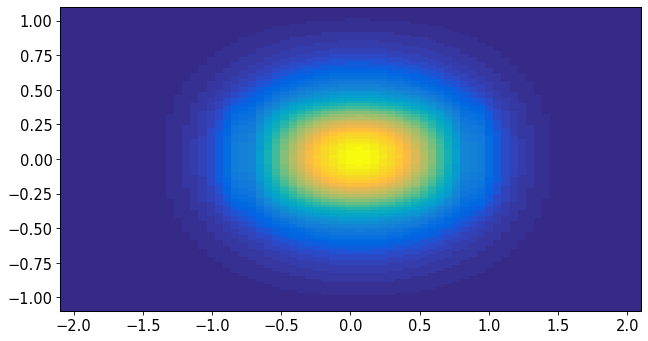

In [53]:
fig,ax = plt.subplots(1,1)
Ey = np.abs(mode.get_field_interp(0,'Ey')).squeeze()
z_plot = np.linspace(-(Z/2-w_pml),(Z/2-w_pml),Ey.shape[0])
y_plot = np.linspace(-(Y/2-w_pml),(Y/2-w_pml),Ey.shape[1])
ax.pcolor(y_plot,z_plot,Ey)
ax.set_aspect('equal')
# plt.contour(y_plot,z_plot,E.T,colors='k')


In [9]:
# def solve fn
import emopt
from emopt.misc import NOT_PARALLEL

import numpy as np
from math import pi

from petsc4py import PETSc
from mpi4py import MPI

def solve(n_grid):
    # emopt's "3D" (full vectorial, 2D slice of 3D structure) mode solve example
    ####################################################################################
    # Simulation parameters
    ####################################################################################
    t_core = 0.73
    w_core = 1.65
    wavelength = 1.55
    X = 1.0 #4. # 5.0
    Y = 6.0 # 3.0
    Z = 4.0 # 2.5
    dx = 0.04 #0.04
    dy = Y / n_grid #0.04
    dz = Z / n_grid  #0.04



    #####################################################################################
    # Setup simulation
    #####################################################################################
    sim = emopt.fdtd.FDTD(X,Y,Z,dx,dy,dz,wavelength, rtol=1e-5)
    w_pml = dy * 15
    sim.w_pml = [w_pml, w_pml, w_pml, w_pml, w_pml, w_pml]

    X = sim.X
    Y = sim.Y
    Z = sim.Z

    Nx = sim.Nx
    Ny = sim.Ny
    Nz = sim.Nz

    #####################################################################################
    # Define the geometry/materials
    #####################################################################################
    r1 = emopt.grid.Rectangle(X/2, Y/2, 2*X, w_core); r1.layer = 1
    r2 = emopt.grid.Rectangle(X/2, Y/2, 2*X, 2*Y); r2.layer = 2

    λ = wavelength
    n_core = _n_si3n4(λ)
    r1.material_value = n_core**2
    r2.material_value = _n_sio2(λ)**2

    eps = emopt.grid.StructuredMaterial3D(X, Y, Z, dx, dy, dz)
    eps.add_primitive(r2, -Z, Z)
    eps.add_primitive(r1, Z/2-t_core/2., Z/2+t_core/2.)

    mu = emopt.grid.ConstantMaterial3D(1.0)

    sim.set_materials(eps, mu)
    sim.build()

    #####################################################################################
    # Setup the sources
    #####################################################################################
    mode_slice = emopt.misc.DomainCoordinates(0.8, 0.8, w_pml, Y-w_pml, w_pml, Z-w_pml, dx, dy, dz)

    mode = emopt.modes.ModeFullVector(wavelength, eps, mu, mode_slice, n0=n_core,
                                       neigs=4)
    mode.build()
    mode.solve()
    return mode.neff[0].real



In [11]:
import time
res_list = (2**np.arange(2,9,1)).astype('int')
#ng = np.zeros(len(res_list))
n_eff = np.zeros(len(res_list))
dt = np.zeros(len(res_list))

for rind,rr in enumerate(res_list):
    t0 = time.time()
    try:
        n_eff[rind] = solve(n_grid=rr)
    except:
        pass
    dt[rind] = time.time()-t0

#         ng[rind] = params['ng'][0]
#     except:
#         pass

[INFO] Building FDTD system...
[INFO] Building mode solver system matrix...
[INFO] Solving...
[INFO] Building FDTD system...
[INFO] Building mode solver system matrix...
[INFO] Solving...
[INFO] Building FDTD system...
[INFO] Building mode solver system matrix...
[INFO] Solving...
[INFO] Building FDTD system...
[INFO] Building FDTD system...
[INFO] Building mode solver system matrix...
[INFO] Solving...
[INFO] Building FDTD system...
[INFO] Building mode solver system matrix...
[INFO] Solving...
[INFO] Building FDTD system...
[INFO] Building mode solver system matrix...
[INFO] Solving...


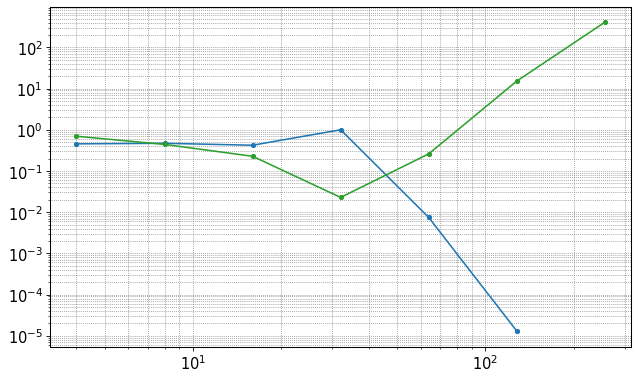

In [12]:
δn_eff = np.abs(n_eff - n_eff[-1])/n_eff[-1]
plt.loglog(res_list[:-1],δn_eff[:-1],'.-C0')
plt.loglog(res_list,dt,'.-C2')

In [13]:
print(r_list)
print(δn_deff)
print(dt)

NameError: name 'r_list' is not defined

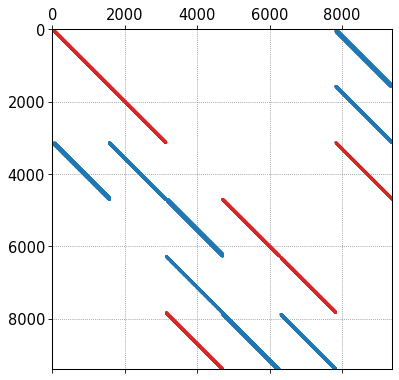

In [49]:
ms =1 

fig,ax=plt.subplots(1,1)
ax.spy(A_norm,markersize=ms,color='C0')
ax.spy(A_im_norm,markersize=ms,color='C3')

# EMpy

In [1]:
# imports
from pathlib import Path
from multiprocessing import Pool
import socket
import pickle
from datetime import datetime
from time import time
from os import path, makedirs, chmod
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
home = str( Path.home() )
om_subdirs = ['nlo','dispersion']
for subdir in om_subdirs:
    dd = home+'/github/optics_modeling/'+subdir
    if dd not in sys.path:
        sys.path.append(dd)
import NLO_tools as nlo

import numpy
import EMpy
import pylab

u = nlo.u

def _n_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_MgO_LN(λ*u.um,T,axis=axis)[0,0]

def _ng_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_g_MgO_LN(λ*u.um,T,axis=axis)

def _n_si3n4(λ,T=300*u.degK):
    return nlo.n_Si3N4(λ*u.um,T)[0,0]

def _ng_si3n4(λ,T=300*u.degK):
    return nlo.n_g_Si3N4(λ*u.um,T)

def _n_sio2(λ,T=300*u.degK):
    return nlo.n_SiO2(λ*u.um,T)[0,0]

def _ng_sio2(λ,T=300*u.degK):
    return nlo.n_g_SiO2(λ*u.um,T)

def _n_mgf2(λ,T=300*u.degK):
    return nlo.n_MgF2(λ*u.um,T)

def _ng_mgf2(λ,T=300*u.degK):
    return nlo.n_g_MgF2(λ*u.um,T)

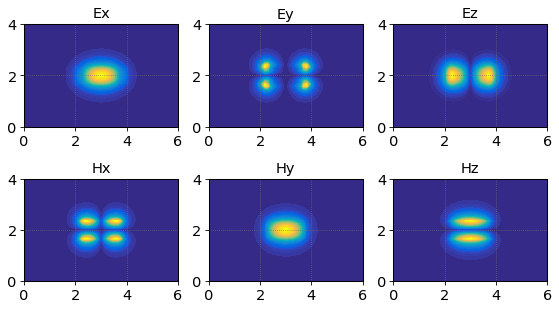

In [20]:
## Fully vectorial finite-difference mode solver example from EMpy

####################################################################################
# Simulation parameters
####################################################################################

n_grid = 64

t_core = 0.73e-6
w_core = 1.65e-6
wavelength = 1.55e-6
X = 6.0e-6 #4. # 5.0
Y = 4.0e-6 # 3.0
dx = 0.04e-6 #0.04
dy = Y / n_grid #0.04

x_offset = X/2.
y_offset = Y/2.

λ = wavelength*1e6 # in um
n_core = _n_si3n4(λ)
n_clad = _n_sio2(λ)


wl = wavelength
x = numpy.linspace(0, X, n_grid)
y = numpy.linspace(0, Y, n_grid)


def epsfunc(x_, y_):
    """Return a matrix describing a 2d material.

    :param x_: x values
    :param y_: y values
    :return: 2d-matrix
    """
    xx, yy = numpy.meshgrid(x_, y_)
    return numpy.where((numpy.abs(xx.T - x_offset) <= w_core/2.) *
                       (numpy.abs(yy.T - y_offset) <= t_core/2.),
                       n_core**2,
                       n_clad**2)



neigs = 2
tol = 1e-8
boundary = '0000'

solver = EMpy.modesolvers.FD.VFDModeSolver(wl, x, y, epsfunc, boundary).solve(neigs, tol)

fig = plt.figure(figsize=(9,5))

x_plot = x *1e6
y_plot = y *1e6

fig.add_subplot(2, 3, 1)
Ex = numpy.transpose(solver.modes[0].get_field('Ex', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Ex), 50)
ax.set_title('Ex')
ax.set_aspect('equal')

fig.add_subplot(2, 3, 2)
Ey = numpy.transpose(solver.modes[0].get_field('Ey', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Ey), 50)
ax.set_title('Ey')
ax.set_aspect('equal')

fig.add_subplot(2, 3, 3)
Ez = numpy.transpose(solver.modes[0].get_field('Ez', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Ez), 50)
ax.set_title('Ez')
ax.set_aspect('equal')

fig.add_subplot(2, 3, 4)
Hx = numpy.transpose(solver.modes[0].get_field('Hx', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Hx), 50)
ax.set_title('Hx')
ax.set_aspect('equal')

fig.add_subplot(2, 3, 5)
Hy = numpy.transpose(solver.modes[0].get_field('Hy', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Hy), 50)
ax.set_title('Hy')
ax.set_aspect('equal')
fig.add_subplot(2, 3, 6)
Hz = numpy.transpose(solver.modes[0].get_field('Hz', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Hz), 50)
ax.set_title('Hz')
ax.set_aspect('equal')


In [2]:
## Fully vectorial finite-difference mode solver example from EMpy

####################################################################################
# Simulation parameters
####################################################################################

n_grid = 64

t_core = 0.73e-6
w_core = 1.65e-6
wavelength = 1.55e-6
X = 6.0e-6 #4. # 5.0
Y = 4.0e-6 # 3.0
dx = 0.04e-6 #0.04
dy = Y / n_grid #0.04

x_offset = X/2.
y_offset = Y/2.

λ = wavelength*1e6 # in um
n_core = _n_si3n4(λ)
n_clad = _n_sio2(λ)


wl = wavelength
x = numpy.linspace(0, X, n_grid)
y = numpy.linspace(0, Y, n_grid)


def epsfunc(x_, y_):
    """Return a matrix describing a 2d material.

    :param x_: x values
    :param y_: y values
    :return: 2d-matrix
    """
    xx, yy = numpy.meshgrid(x_, y_)
    return numpy.where((numpy.abs(xx.T - x_offset) <= w_core/2.) *
                       (numpy.abs(yy.T - y_offset) <= t_core/2.),
                       n_core**2,
                       n_clad**2)



neigs = 2
tol = 1e-8
boundary = '0000'

solver = EMpy.modesolvers.FD.VFDModeSolver(wl, x, y, epsfunc, boundary).solve(neigs, tol)

fig = plt.figure(figsize=(9,5))

x_plot = x *1e6
y_plot = y *1e6

fig.add_subplot(2, 3, 1)
Ex = numpy.transpose(solver.modes[0].get_field('Ex', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Ex), 50)
ax.set_title('Ex')
ax.set_aspect('equal')

fig.add_subplot(2, 3, 2)
Ey = numpy.transpose(solver.modes[0].get_field('Ey', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Ey), 50)
ax.set_title('Ey')
ax.set_aspect('equal')

fig.add_subplot(2, 3, 3)
Ez = numpy.transpose(solver.modes[0].get_field('Ez', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Ez), 50)
ax.set_title('Ez')
ax.set_aspect('equal')

fig.add_subplot(2, 3, 4)
Hx = numpy.transpose(solver.modes[0].get_field('Hx', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Hx), 50)
ax.set_title('Hx')
ax.set_aspect('equal')

fig.add_subplot(2, 3, 5)
Hy = numpy.transpose(solver.modes[0].get_field('Hy', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Hy), 50)
ax.set_title('Hy')
ax.set_aspect('equal')
fig.add_subplot(2, 3, 6)
Hz = numpy.transpose(solver.modes[0].get_field('Hz', x, y))
ax = plt.gca()
ax.contourf(x_plot, y_plot, abs(Hz), 50)
ax.set_title('Hz')
ax.set_aspect('equal')

ModuleNotFoundError: No module named 'sp'

In [23]:
solver.modes[0].neff.real

1.8120193759457057

# Ceviche

## test sparse eigensolve backprop

In [16]:
import ceviche
from ceviche.primitives import *
from ceviche.primitives import _eigs, sp_eigs


# N = 5
# M = N**2 - 1
# inds = make_rand_indeces(N, M)
# e = make_rand_complex(M)
# A = make_sparse(e,inds,(N,N))

# # β_est = 11736732.1 # [1/m] from ω = 2π*(200 THz) and n_eff_guess ~ 2.8
sigma = β_est**2


# import scipy.sparse as sp
# from scipy.sparse.linalg import eigsh, eigs
from scipy.stats import unitary_group, special_ortho_group


# β_est = 2.6
# δβsq0 = 0.1
# δβsq1 = -0.2
# βsq0 = β_est**2+δβsq0
# βsq1 = β_est**2+δβsq1
# print(f'βsq0 = {βsq0:2.2f}')
# print(f'βsq1 = {βsq1:2.2f}')
# eigvals0 = np.array([0.1,0.2,.03,βsq0,βsq1,30.2,100.6,600.5,])
# N = len(eigvals0)
# O = special_ortho_group.rvs(N)
# Ad = np.diag(eigvals0)
# A = sp.csr_matrix(O.T @ Ad @ O)



e,inds = get_entries_indices(A)
n_eigs = 2 # find two modes

# N = 1000
# nz_frac = 0.4
# M = int(nz_frac*N)
# inds = make_rand_indeces(N, M)
# e = 100*make_rand_complex(M)
# A = make_sparse(e,inds,(N,N))

# np.linalg.eig(A.toarray())
# eigs(A,3)


n_eigs = 2
M = len(e)
N = A.shape[0]


sigma = β_est**2
print(f'sigma: {sigma}')
print(f'N: {N}')
print(f'M: {M}')


# e_plus_de = e +npa.ones(len(e))*1e-3
# A_plus_dA = make_sparse(e_plus_de,inds,(N,N))



def f(e): 
    D,U = sp_eigs(e,inds,N,n_eigs,sigma) 
    return npa.mean(npa.abs(npa.diff(D)))   

grad_rev = ceviche.jacobian(f,mode='reverse')



sigma: 137750880805021.19
N: 1568
M: 14112


In [18]:
grad_rev = ceviche.jacobian(f,mode='reverse')
gr = grad_rev(e)

print('\ngr:')
print(gr[0,:20])



sigma: 1.38e+14
D:[1.24884062e+14 -37273.69111463j 9.85033936e+13-533701.00017278j]

gr:
[-1.21214264e-29+2.28099112e-37j -6.50793347e-29+3.61358910e-30j
  1.97864246e-26+1.36657172e-27j  1.16245865e-30+3.70325271e-31j
  2.84393109e-27+3.88372266e-28j -6.27183204e-30-2.06826766e-31j
  1.25442484e-31+7.21524272e-31j  9.60200634e-27+7.64170912e-28j
  4.53994799e-29-4.59773932e-30j -6.50793348e-29-3.61358665e-30j
 -3.49309495e-28+6.57325158e-36j  5.70989708e-26+6.88920541e-27j
  2.79175563e-29-4.82502709e-30j  7.54226460e-26+7.39930761e-27j
  4.53976222e-31+3.91036318e-30j  8.84637409e-29-3.51454259e-31j
  2.42557496e-28-1.11001099e-29j -1.26264384e-25-9.37253084e-27j
  5.70989705e-26-6.88920756e-27j -9.46911592e-24+1.78188346e-31j]


In [22]:
def grad_f_num(n_e,delta=1e-6):
    grad_f = np.zeros((n_e,),dtype='complex')
    f_old = f(e)
    for ind in range(n_e):
        e_new = e.copy()
        e_new[ind] = e[ind] + delta
        grad_f[ind] += (f(e_new) - f_old)/delta
        e_new[ind] = e[ind] + delta*1j
        grad_f[ind] += (f(e_new) - f_old)/(delta*1j)
    return grad_f

grad_f_num(5)
#gn = grad_num(f,e,delta=1e-6)

# print('\ngn:')
# print(gn[:20] - gr[0,:20])

sigma: 1.38e+14
D:[1.24884062e+14 -37273.6907718j  9.85033936e+13-533700.99971709j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.68930561j 9.85033936e+13-533700.99637801j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.69106565j 9.85033936e+13-533700.98999603j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.691033j   9.85033936e+13-533700.99301488j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.6908371j  9.85033936e+13-533701.00184359j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.69033103j 9.85033936e+13-533700.99485657j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.69050244j 9.85033936e+13-533700.99174277j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.69113911j 9.85033936e+13-533700.99396459j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.69105749j 9.85033936e+13-533700.99778048j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.69112075j 9.85033936e+13-533700.98756614j]
sigma: 1.38e+14
D:[1.24884062e+14 -37273.69126155j 9.85033936e+13-533700.9960717j ]


array([156250. +78125.j,  15625.-140625.j, 218750. -62500.j,
        31250. -15625.j,  93750. -15625.j])

In [7]:
Ia, Oa = make_IO_matrices(indices_a, N)

evals, evecs = D_sp, U_sp

evecs_c = evecs.conjugate()

IaT_Uc = Ia.T.dot(evecs_c)
UT_OaT = Oa.dot(evecs).T

evals_repeated = npa.repeat(evals[..., npa.newaxis], n_eigs, axis=-1)

# def vjp(v):
#     evals_v, evecs_v = v   # Gradient of eigenvalues, eigenvectors wrt. computation output (backprop vectors)
evals_v = np.array([-1.0+0.0j, 1.0 + 0.0j])

    # Eigenvalue part of the VJP = Σ_{i=0,...,n_eigs} | ψ_i X ψ_i | evals[i]
    # vjp_temp = np.dot(evecs_c * evals_v[..., np.newaxis, :], T(evecs))
vjp_temp = evals_v[..., npa.newaxis, :] * npa.eye(n_eigs)

    # Add eigenvector part only if non-zero backward signal is present.
    # This can avoid NaN results for degenerate cases if the function
    # depends on the eigenvalues only.
#     if npa.any(evecs_v):

#         off_diag = npa.ones((n_eigs, n_eigs)) - npa.eye(n_eigs)
#         F = off_diag / (evals_repeated.T - evals_repeated + npa.eye(n_eigs))
#         # vjp_temp += np.dot(np.dot(evecs_c, F * np.dot(T(evecs), evecs_v)), T(evecs))
#         vjp_temp +=  F * npa.dot(evecs.T, evecs_v)

#     # project vjp (NxN) into space of A entries (MxM)
M = (IaT_Uc).dot(vjp_temp).dot(UT_OaT)

NameError: name 'D_sp' is not defined

In [18]:
M.diagonal()[:20]

array([4.64724824e-31+0.j, 6.94831399e-31+0.j, 6.64884031e-24+0.j,
       1.72651502e-19+0.j, 1.72104810e-17+0.j, 9.79810822e-17+0.j,
       2.43559767e-16+0.j, 4.35937779e-16+0.j, 6.53090006e-16+0.j,
       8.72775937e-16+0.j, 1.07559684e-15+0.j, 1.24663405e-15+0.j,
       1.37561316e-15+0.j, 1.45615404e-15+0.j, 1.48494884e-15+0.j,
       1.46145207e-15+0.j, 1.38801211e-15+0.j, 1.26991257e-15+0.j,
       1.11502397e-15+0.j, 9.33283589e-16+0.j])

In [9]:
# D_sp, U_sp = sp_eigs(e,inds,N,n_eigs,sigma,'LR')
D_sp, U_sp = eigs(A,k=n_eigs,sigma=sigma,which='LM')

# D_d, U_d = np.linalg.eig(A.toarray())

print('D_sp:')
print(D_sp)

print('U_sp:')
print(U_sp)


# print('D_d:')
# print(D_d)

# print('U_d:')
# print(U_d)



D_sp:
[1.24884062e+14 -37273.68966859j 9.85033936e+13-533700.99516778j]
U_sp:
[[-5.78274424e-18-1.28043030e-16j  9.67482221e-16-3.44362714e-15j]
 [ 7.85670767e-17+5.15323550e-16j  3.32311258e-15-1.85051929e-14j]
 [-6.72290266e-15-1.00567014e-13j -9.26048412e-13+2.93617182e-12j]
 ...
 [-4.16903382e-10+2.26914795e-10j -2.67801292e-09-3.51286561e-11j]
 [-2.32026790e-10+1.78939504e-10j -1.62526731e-09+2.69682459e-10j]
 [ 4.27301797e-12-1.02256127e-10j  3.06333189e-10-6.30331108e-10j]]


## test modesolver class

In [1]:
# imports
from ceviche.utils import *
from ceviche.primitives import *
from ceviche.fdfd import *
import ceviche
from scipy.sparse.linalg import eigs, eigsh
import numpy as np
import matplotlib.pylab as plt
import autograd.numpy as npa
from ceviche.modes import ModeSolver

# create modesolver object

n_si= 3.5
omega= 2*np.pi*200e12
dx_ridge = 0.5e-6
dy_ridge = 0.3e-6
dL = 30e-9
eps_max = 2
npml = 4
spc = 4
Lx = 2e-6
Ly = 2e-6
yoffs=0
Nx, Ny = 2*npml + 4*spc + int(Lx/dL), 2*npml + 4*spc + int(Ly/dL)
xind_min = int(Nx/2-dx_ridge/dL/2)
xind_max = int(Nx/2+dx_ridge/dL/2)

yind_min = int(Ny/2)+yoffs
yind_max = int(Ny/2+dy_ridge/dL)+yoffs

xind = npa.arange(Nx)
yind = npa.arange(Ny)

x = dL * xind
x_min = dL * xind_min
x_max = dL * xind_max

y = dL * yind
y_min = dL * yind_min
y_max = dL * yind_max

val_wg = npa.sqrt(n_si**2-1)
eps_r_wg_x = npa.ones(Nx) * val_wg
eps_r_wg_y = npa.ones(Ny) * val_wg
eps_r_x = npa.select([(x >= x_min) * (x < x_max)],[eps_r_wg_x])
eps_r_y = npa.select([(y >= y_min) * (y < y_max)],[eps_r_wg_y])
eps_r = npa.outer(eps_r_x,eps_r_y) + npa.ones((Nx,Ny))
ms = ModeSolver(omega, dL, eps_r, [npml, npml])


/home/dodd/miniconda3/envs/angler/lib/python3.8/site-packages/ceviche-0.1.1-py3.8.egg/ceviche/derivatives.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/dodd/miniconda3/envs/angler/lib/python3.8/site-packages/ceviche-0.1.1-py3.8.egg/ceviche/derivatives.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [3]:
neff,U = ms.solve(n_eigs=4)

In [8]:
# define a function to generate and solve Maxwell eigenproblem A from a few params

# build fdfd solver object to check behavior of sparse matrices
def _grid_average_3d(F):
    eps_grid = F.eps_r
    eps_grid_xx = 1 / 2 * (eps_grid + npa.roll(eps_grid, axis=1, shift=1))
    eps_grid_yy = 1 / 2 * (eps_grid + npa.roll(eps_grid, axis=0, shift=1))
    eps_grid_zz_xy = 1 / 2 * (eps_grid_xx + npa.roll(eps_grid_xx, axis=0, shift=1))
    eps_grid_zz_yx = 1 / 2 * (eps_grid_yy + npa.roll(eps_grid_yy, axis=1, shift=1))
    eps_grid_zz = 1 / 2 * (eps_grid_zz_xy + eps_grid_zz_yx)
    eps_vec_xx = F._grid_to_vec(eps_grid_xx)
    eps_vec_yy = F._grid_to_vec(eps_grid_yy)
    eps_vec_zz = F._grid_to_vec(eps_grid_zz)
    eps_vec_xx = eps_vec_xx
    eps_vec_yy = eps_vec_yy
    eps_vec_zz = eps_vec_zz
    return eps_vec_xx, eps_vec_yy, eps_vec_zz

def _construct_A(F):
    eps_vec_xx, eps_vec_yy, eps_vec_zz = _grid_average_3d(F)
    eps_vec_xx_inv = 1 / (eps_vec_xx + 1e-5)  # the 1e-5 is for numerical stability
    eps_vec_yy_inv = 1 / (eps_vec_yy + 1e-5)  # autograd throws 'divide by zero' errors.
    eps_vec_zz_inv = 1 / (eps_vec_zz + 1e-5)
    self = F
    N = self.N
    indices_diag = npa.vstack((npa.arange(N), npa.arange(N)))
    
#     print(f'N: {N}')
#     print(f'indices_diag.shape: {indices_diag.shape}')
#     print(f'eps_vec_xx.shape: {eps_vec_xx.shape}')
#     print(f'eps_vec_xx_inv.shape: {eps_vec_xx_inv.shape}')
#     print(f'eps_vec_zz_inv.shape: {eps_vec_zz_inv.shape}')
    
#     print(f'self.entries_Dxf.shape: {self.entries_Dxf.shape}')
#     print(f'self.indices_Dxf.shape: {self.indices_Dxf.shape}')
    
    entries_DxEpsz,   indices_DxEpsz   = spsp_mult(self.entries_Dxf, self.indices_Dxf, eps_vec_zz_inv, indices_diag, N)
    entries_DxEpszDx, indices_DxEpszDx = spsp_mult(entries_DxEpsz, indices_DxEpsz, self.entries_Dxb, self.indices_Dxb, N)
    entries_DxEpszDy, indices_DxEpszDy = spsp_mult(entries_DxEpsz, indices_DxEpsz, -1*self.entries_Dyb, self.indices_Dyb, N)
    
#     print(f'entries_DxEpsz.shape: {entries_DxEpsz.shape}')
#     print(f'indices_DxEpsz.shape: {indices_DxEpsz.shape}')
    
#     print(f'entries_DxEpszDy.shape: {entries_DxEpszDy.shape}')
#     print(f'indices_DxEpszDy.shape: {indices_DxEpszDy.shape}')
    
    entries_EpsxDxEpszDy, indices_EpsxDxEpszDy = spsp_mult(eps_vec_xx, indices_diag, entries_DxEpszDy, indices_DxEpszDy, N)
    entries_EpsxDxEpszDx, indices_EpsxDxEpszDx = spsp_mult(eps_vec_xx, indices_diag, entries_DxEpszDx, indices_DxEpszDx, N)

    entries_DyEpsz,   indices_DyEpsz   = spsp_mult(-1*self.entries_Dyf, self.indices_Dyf, eps_vec_zz_inv, indices_diag, N)
    entries_DyEpszDy, indices_DyEpszDy = spsp_mult(entries_DyEpsz, indices_DyEpsz, -1*self.entries_Dyb, self.indices_Dyb, N)
    entries_DyEpszDx, indices_DyEpszDx = spsp_mult(entries_DyEpsz, indices_DyEpsz, self.entries_Dxb, self.indices_Dxb, N)
    entries_EpsyDyEpszDy, indices_EpsyDyEpszDy = spsp_mult(eps_vec_yy, indices_diag, entries_DyEpszDy, indices_DyEpszDy, N)
    entries_EpsyDyEpszDx, indices_EpsyDyEpszDx = spsp_mult(eps_vec_yy, indices_diag, entries_DyEpszDx, indices_DyEpszDx, N)

    e_11, i_11 = entries_EpsyDyEpszDy, indices_EpsyDyEpszDy
    e_12, i_12 = entries_EpsyDyEpszDx, indices_EpsyDyEpszDx
    e_21, i_21 = entries_EpsxDxEpszDy, indices_EpsxDxEpszDy
    e_22, i_22 = entries_EpsxDxEpszDx, indices_EpsxDxEpszDx
    
    # shift the indices into each of the 4 quadrants
    i_22 = i_22 + npa.ones(i_22.shape,dtype='int') * N         # shift into bottom right quadrant
    #     indices_EpsyDyEpszDx[1,:] += self.N  # shift into top right quadrant
    i_12 = i_12 + npa.vstack((npa.zeros((i_12.shape[1],),dtype='int')*N,npa.ones((i_12.shape[1],),dtype='int')))  
    #     indices_EpsxDxEpszDy[0,:] += self.N  # shift into bottom left quadrant
    i_21 = i_21 + npa.vstack((npa.ones((i_21.shape[1],),dtype='int')*N,npa.zeros((i_21.shape[1],),dtype='int')))                                                            
                                                             
    # get full matrix entries and indices
    entries_DEpszD = npa.hstack((e_11,
                                 e_12,
                                 e_21,
                                 e_22))
    indices_DEpszD = npa.hstack((i_11,
                                 i_12,
                                 i_21,
                                 i_22))


    #### construct curl operator 

    # # notation: C = [[C11, C12], [C21, C22]]

    entries_c11, i_c11 =  spsp_mult(self.entries_Dxb, self.indices_Dxb, self.entries_Dxf, self.indices_Dxf,self.N) # self.Dyb.dot(self.Dyf)
    entries_c22, i_c22 =  spsp_mult(self.entries_Dyb, self.indices_Dyb, self.entries_Dyf, self.indices_Dyf,self.N) # self.Dxb.dot(self.Dxf)
    entries_c12, i_c12 =  spsp_mult(self.entries_Dxb, self.indices_Dxb, self.entries_Dyf, self.indices_Dyf,self.N) # self.Dyb.dot(self.Dxf)
    entries_c21, i_c21 =  spsp_mult(self.entries_Dyb, self.indices_Dyb, self.entries_Dxf, self.indices_Dxf,self.N) # self.Dxb.dot(self.Dyf)

    # shift the indices into each of the 4 quadrants
#     i_c22 += self.N       # shift into bottom right quadrant
#     i_c12[1,:] += self.N  # shift into top right quadrant
#     i_c21[0,:] += self.N  # shift into bottom left quadrant
    i_c22 = i_c22 + npa.ones(i_c22.shape,dtype='int') * N         # shift into bottom right quadrant
    #     indices_EpsyDyEpszDx[1,:] += self.N  # shift into top right quadrant
    i_c12 = i_c12 + npa.vstack((npa.zeros((i_c12.shape[1],),dtype='int')*N,npa.ones((i_c12.shape[1],),dtype='int')))  
    #     indices_EpsxDxEpszDy[0,:] += self.N  # shift into bottom left quadrant
    i_c21 = i_c21 + npa.vstack((npa.ones((i_c21.shape[1],),dtype='int')*N,npa.zeros((i_c21.shape[1],),dtype='int'))) 
                             
                             
    # get full matrix entries and indices
    entries_c = npa.hstack((entries_c11, entries_c12, entries_c21, entries_c22))
    indices_c = npa.hstack((i_c11, i_c12, i_c21, i_c22))

    # indices into the diagonal of a sparse matrix
    entries_diag = (self.omega/C_0)**2 * npa.hstack((eps_vec_yy, eps_vec_xx))
    indices_diag = npa.vstack((npa.arange(2*self.N), npa.arange(2*self.N)))

    # put together the big A and return entries and indices
    entries_a = npa.hstack((entries_diag, entries_DEpszD, entries_c))
    indices_a = npa.hstack((indices_diag, indices_DEpszD, indices_c))
    
    return entries_a,indices_a, 2*self.N

def _create_F(p):
    # p: n_si=3.5,omega=2*np.pi*200e12,dx_ridge=0.5e-6,dy_ridge=0.3e-6
    n_si=p[0]
    omega=p[1]
    dx_ridge = 0.5e-6
    dy_ridge = 0.3e-6
    dL = 30e-9
    eps_max = 2
    npml = 4
    spc = 4
    Lx = 2e-6
    Ly = 2e-6
    yoffs=0
    Nx, Ny = 2*npml + 4*spc + int(Lx/dL), 2*npml + 4*spc + int(Ly/dL)
    xind_min = int(Nx/2-dx_ridge/dL/2)
    xind_max = int(Nx/2+dx_ridge/dL/2)

    yind_min = int(Ny/2)+yoffs
    yind_max = int(Ny/2+dy_ridge/dL)+yoffs

    xind = npa.arange(Nx)
    yind = npa.arange(Ny)

    x = dL * xind
    x_min = dL * xind_min
    x_max = dL * xind_max

    y = dL * yind
    y_min = dL * yind_min
    y_max = dL * yind_max
    
    val_wg = npa.sqrt(n_si**2-1)
    eps_r_wg_x = npa.ones(Nx) * val_wg
    eps_r_wg_y = npa.ones(Ny) * val_wg
    eps_r_x = npa.select([(x >= x_min) * (x < x_max)],[eps_r_wg_x])
    eps_r_y = npa.select([(y >= y_min) * (y < y_max)],[eps_r_wg_y])
    eps_r = npa.outer(eps_r_x,eps_r_y) + npa.ones((Nx,Ny))
    return fdfd_hz(omega, dL, eps_r, [npml, npml])

n_eigs = 3
neff_est = 2.6
omega_0 = 2*np.pi*200e12
β_est = omega_0 / C_0 * neff_est

# def f(n_si,omega):
def f(p):
#     F = _create_F(n_si=p[0],omega=p[1])
    e, inds, N = _construct_A(_create_F(p))
    D,U = sp_eigs(e,inds,N,n_eigs,sigma=β_est**2)
    neff = npa.real(npa.sqrt(npa.real(D))) * C_0 / p[1]
#     return npa.mean(npa.abs(npa.diff(neff))) 
    return neff

# p: n_si=3.5,omega=2*np.pi*200e12,dx_ridge=0.5e-6,dy_ridge=0.3e-6
p = npa.array([3.5+0.j, 2*np.pi*200e12+0.j]) #0.5e-6,0.3e-6])

print('f(p):')
print(str(f(p))) #: 0.2982725818922339

grad_rev = ceviche.jacobian(f,mode='reverse')
# gr = grad_rev(p[0],p[1])
gr = grad_rev(p)

print('\ngr:')
print(gr)


grad_fwd = ceviche.jacobian(f,mode='forward')
gf = grad_rev(p)

print('\ngf:')
print(gf)


# gn = grad_num(f,np.array([p]),delta=1e-5)
jac_num = ceviche.jacobian(f,mode='numerical')
# gn = jac_num(p[0],p[1])
gn = jac_num(p)
print('\ngn:')
print(gn)


f(p):
[2.73029725+0.j 2.31785781+0.j 1.46570651+0.j]

gr:
[[1.15376090e+00-8.20490982e-14j 1.07973440e-15+1.71280466e-43j]
 [1.40658752e+00+2.53101911e-11j 2.13133012e-15+2.39193355e-42j]
 [1.95161145e+00+7.56063968e-07j 4.46161974e-15+6.59631729e-38j]]

gf:
[[1.15376090e+00-8.20493601e-14j 1.07973440e-15+4.43286762e-43j]
 [1.40658752e+00+2.53101931e-11j 2.13133012e-15+4.79219461e-42j]
 [1.95161145e+00+7.56063968e-07j 4.46161974e-15+5.34182455e-38j]]

gn:
[[ 1.13477172e+00 -4.44089210e-10]
 [ 1.30028878e+00  1.33226763e-09]
 [ 1.48482451e+00  2.44249065e-09]]


In [3]:
def grad_f_num(n_old,delta=1e-6):
#     grad_f =  0. + 0.j # np.zeros((n_e,),dtype='complex')
    f_old = f(n_old)
    delta_f = delta
    n_new = n_old+ delta
    grad_f = (f(n_new) - f_old)/delta
#     n_new = n_old+ delta*1j
#     grad_f += (f(n_new) - f_old)/(delta_f*1j)
    return grad_f

grad_f_num(p)


88605560000000.0

## Simple tests

In [1]:
# imports
from ceviche.utils import *
from ceviche.primitives import *
from ceviche.fdfd import *
import ceviche
from scipy.sparse.linalg import eigs, eigsh
import numpy as np
import matplotlib.pylab as plt
import autograd.numpy as npa
from autograd import grad
np.set_printoptions(precision=3)

A = np.array([
                [1,4,5,],
                [4,2,4,],
                [5,4,3,],
            ],
            dtype='float32'
            )

A_sp = sp.csr_matrix(A)
eA,iA = get_entries_indices(A_sp)
eigh_ag(A)

/home/dodd/miniconda3/envs/angler/lib/python3.8/site-packages/ceviche-0.1.1-py3.8.egg/ceviche/derivatives.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/dodd/miniconda3/envs/angler/lib/python3.8/site-packages/ceviche-0.1.1-py3.8.egg/ceviche/derivatives.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?


(array([10.736, -3.242, -1.494], dtype=float32),
 array([[ 0.549,  0.827, -0.118],
        [ 0.543, -0.246,  0.803],
        [ 0.636, -0.505, -0.584]], dtype=float32))

In [2]:
eig_ag(A)

(array([10.736, -3.242, -1.494], dtype=float32),
 array([[ 0.549,  0.827, -0.118],
        [ 0.543, -0.246,  0.803],
        [ 0.636, -0.505, -0.584]], dtype=float32))

In [3]:
# e = np.array([1., 4., 5., 4., 2., 4., 5., 4., 3.])
# e = np.array([1., 4.+1.j, 5.+2.j, 4.-1.j, 2., 4.+3.j, 5.-2.j, 4.-3.j, 3.])
e = np.array([1.,2.,3., 4.+1.j, 5.+2.j, 4.+3.j])

In [4]:
# test fwd, rev and numerical gradients of eigh_ag (defined from numpy.linalg.eigh)
def f(eX):
#     X = npa.reshape(eX,(3,3))
    X = npa.array([[eX[0],eX[3],eX[4]],
               [npa.conj(eX[3]),eX[1],eX[5]],
               [npa.conj(eX[4]),npa.conj(eX[5]),eX[2]],
              ])
    D,U = eigh_ag(X)
    return D

# def f(a):
#     b = a[::-1]
#     c = b * 1/a
#     return c

print(f'f(e):{f(e)}')

grad_rev = ceviche.jacobian(f,mode='reverse')
gr = grad_rev(e)
print('\ngr:')
print(gr)

grad_fwd = ceviche.jacobian(f,mode='forward')
gf = grad_fwd(e)
print('\ngf:')
print(gf)

# g_num = ceviche.jacobian(f,mode='numerical_complex')
g_num = ceviche.jacobian(f,mode='numerical')
gn = g_num(e)
print('\ngn:')
print(gn)


f(e):[11.641 -4.333 -1.309]

gr:
[[ 0.282+0.j     0.304+0.j     0.414+0.j     0.586-0.016j  0.592-0.341j
   0.624-0.338j]
 [ 0.444+0.j     0.209+0.j     0.347+0.j    -0.138+0.593j -0.773-0.138j
   0.028+0.538j]
 [ 0.274+0.j     0.487+0.j     0.239+0.j    -0.448-0.578j  0.181+0.479j
  -0.652-0.2j  ]]

gf:
[[ 0.282+0.j     0.304+0.j     0.414+0.j     0.586-0.016j  0.592-0.341j
   0.624-0.338j]
 [ 0.444+0.j     0.209+0.j     0.347+0.j    -0.138+0.593j -0.773-0.138j
   0.028+0.538j]
 [ 0.274+0.j     0.487+0.j     0.239+0.j    -0.448-0.578j  0.181+0.479j
  -0.652-0.2j  ]]

gn:
[[ 0.282  0.304  0.414  0.586  0.592  0.624]
 [ 0.444  0.209  0.347 -0.138 -0.773  0.028]
 [ 0.274  0.487  0.239 -0.448  0.181 -0.652]]


In [5]:
# same as above but with eig_ag (defined from numpy.linalg.eig)
np.set_printoptions(precision=3)
def g(eX):
#     X = npa.reshape(eX,(3,3))
    X = npa.array([[eX[0],eX[3],eX[4]],
               [npa.conj(eX[3]),eX[1],eX[5]],
               [npa.conj(eX[4]),npa.conj(eX[5]),eX[2]],
              ])
    D,U = eig_ag(X)
    return D

print(f'g(e):{g(e)}')

grad_rev = ceviche.jacobian(g,mode='reverse')
gr = grad_rev(e)
print('\ngr:')
print(gr)

grad_fwd = ceviche.jacobian(g,mode='forward')
gf = grad_fwd(e)
print('\ngf:')
print(gf)

g_num = ceviche.jacobian(g,mode='numerical_complex')
# g_num = ceviche.jacobian(g,mode='numerical')
gn = g_num(e)
print('\ngn:')
print(gn)


g(e):[11.641+5.446e-16j -4.333-6.624e-17j -1.309-2.563e-16j]

gr:
[[ 0.282+0.j     0.304+0.j     0.414+0.j     0.586-0.016j  0.592-0.341j
   0.624-0.338j]
 [ 0.444+0.j     0.209+0.j     0.347+0.j    -0.138+0.593j -0.773-0.138j
   0.028+0.538j]
 [ 0.274+0.j     0.487+0.j     0.239+0.j    -0.448-0.578j  0.181+0.479j
  -0.652-0.2j  ]]

gf:
[[ 0.282+0.j     0.304+0.j     0.414+0.j     0.586-0.016j  0.592-0.341j
   0.624-0.338j]
 [ 0.444+0.j     0.209+0.j     0.347+0.j    -0.138+0.593j -0.773-0.138j
   0.028+0.538j]
 [ 0.274+0.j     0.487+0.j     0.239+0.j    -0.448-0.578j  0.181+0.479j
  -0.652-0.2j  ]]

gn:
[[ 0.282+3.020e-08j  0.304+7.105e-09j  0.414+2.487e-08j  0.586-1.587e-02j
   0.592-3.411e-01j  0.624-3.377e-01j]
 [ 0.444-4.796e-08j  0.209-3.730e-08j  0.347-4.352e-08j -0.138+5.934e-01j
  -0.773-1.381e-01j  0.028+5.382e-01j]
 [ 0.274+3.486e-08j  0.487+2.243e-08j  0.239+2.021e-08j -0.448-5.776e-01j
   0.181+4.792e-01j -0.652-2.005e-01j]]


In [6]:
# same as above but with eigsh_ag (defined from scipy.linalg.eigsh, **not** scipy.sparse.linalg.eigsh)
np.set_printoptions(precision=3)
def g(eX):
#     X = npa.reshape(eX,(3,3))
    X = npa.array([[eX[0],eX[3],eX[4]],
               [npa.conj(eX[3]),eX[1],eX[5]],
               [npa.conj(eX[4]),npa.conj(eX[5]),eX[2]],
              ])
    D,U = eigsh_ag(X)
    return D

print(f'g(e):{g(e)}')

grad_rev = ceviche.jacobian(g,mode='reverse')
gr = grad_rev(e)
print('\ngr:')
print(gr)

grad_fwd = ceviche.jacobian(g,mode='forward')
gf = grad_fwd(e)
print('\ngf:')
print(gf)

g_num = ceviche.jacobian(g,mode='numerical_complex')
# g_num = ceviche.jacobian(g,mode='numerical')
gn = g_num(e)
print('\ngn:')
print(gn)


g(e):[11.641 -4.333 -1.309]

gr:
[[ 0.282+0.j     0.304+0.j     0.414+0.j     0.586-0.016j  0.592-0.341j
   0.624-0.338j]
 [ 0.444+0.j     0.209+0.j     0.347+0.j    -0.138+0.593j -0.773-0.138j
   0.028+0.538j]
 [ 0.274+0.j     0.487+0.j     0.239+0.j    -0.448-0.578j  0.181+0.479j
  -0.652-0.2j  ]]

gf:
[[ 0.282+0.j     0.304+0.j     0.414+0.j     0.586-0.016j  0.592-0.341j
   0.624-0.338j]
 [ 0.444+0.j     0.209+0.j     0.347+0.j    -0.138+0.593j -0.773-0.138j
   0.028+0.538j]
 [ 0.274+0.j     0.487+0.j     0.239+0.j    -0.448-0.578j  0.181+0.479j
  -0.652-0.2j  ]]

gn:
[[ 0.282+3.020e-08j  0.304+7.105e-09j  0.414+2.487e-08j  0.586-1.587e-02j
   0.592-3.411e-01j  0.624-3.377e-01j]
 [ 0.444-4.796e-08j  0.209-3.730e-08j  0.347-4.352e-08j -0.138+5.934e-01j
  -0.773-1.381e-01j  0.028+5.382e-01j]
 [ 0.274+3.486e-08j  0.487+2.243e-08j  0.239+2.021e-08j -0.448-5.776e-01j
   0.181+4.792e-01j -0.652-2.005e-01j]]


/home/dodd/miniconda3/envs/angler/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1267: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


In [7]:
# test fwd, rev and numerical gradients of eigh_ag (defined from numpy.linalg.eigh)
def f(e_sep):
    e_r,e_i = e_sep[:9],e_sep[9:]
    X = npa.reshape(e_r + 1j*e_i,(3,3))
#     X = npa.array([[eX[0],eX[3],eX[4]],
#                [npa.conj(eX[3]),eX[1],eX[5]],
#                [npa.conj(eX[4]),npa.conj(eX[5]),eX[2]],
#               ])
    D,U = eig_ag(X)
#     return npa.hstack((npa.real(D),npa.imag(D)))
#     return D
    return npa.real(D)


# def f(a):
# #     b = a[::-1]
#     c = npa.dot(npa.reshape(a,(len(a),1)),npa.reshape(a,(1,len(a)))) #npa.dot(a,b)
#     return c

e_init = npa.array([1., 4.+7.j, 5.+10.j, 4.-1.j, 2., 4.+3.j, 5.-2.j, 4.-3.j, 3.])
e = npa.hstack((npa.real(e_init),npa.imag(e_init)))

print(f'e_init:{e_init}')
print(f'e:{e}')

print(f'f(e):{f(e)}')

grad_rev = ceviche.jacobian(f,mode='reverse')
gr = grad_rev(e)
print('\ngr: ' + str(gr.shape))
print(gr)

grad_fwd = ceviche.jacobian(f,mode='forward')
gf = grad_fwd(e)
print('\ngf:' + str(gf.shape))
print(gf)

# g_num = ceviche.jacobian(f,mode='numerical_complex')
g_num = ceviche.jacobian(f,mode='numerical')
gn = g_num(e)
print('\ngn:' + str(gn.shape))
print(gn)


e_init:[1. +0.j 4. +7.j 5.+10.j 4. -1.j 2. +0.j 4. +3.j 5. -2.j 4. -3.j 3. +0.j]
e:[ 1.  4.  5.  4.  2.  4.  5.  4.  3.  0.  7. 10. -1.  0.  3. -2. -3.  0.]
f(e):[13.532 -5.96  -1.573]

gr: (3, 18)
[[ 0.52   0.     0.     0.56   0.214  0.     0.408  0.436  0.266  0.
   0.     0.    -0.361  0.     0.    -0.623 -0.194  0.   ]
 [ 0.733  0.     0.    -0.103  0.031  0.    -0.718  0.132  0.236  0.
   0.     0.     0.285  0.     0.     0.42   0.11   0.   ]
 [ 0.205  0.     0.    -0.289  0.481  0.     0.184 -0.772  0.313  0.
   0.     0.    -0.558  0.     0.     0.473 -0.083  0.   ]]

gf:(3, 18)
[[ 0.52   0.28   0.204  0.28   0.214  0.218  0.204  0.218  0.266  0.
   0.181  0.311 -0.181  0.     0.097 -0.311 -0.097  0.   ]
 [ 0.733 -0.052 -0.359 -0.052  0.031  0.066 -0.359  0.066  0.236  0.
  -0.142 -0.21   0.142  0.    -0.055  0.21   0.055  0.   ]
 [ 0.205 -0.145  0.092 -0.145  0.481 -0.386  0.092 -0.386  0.313  0.
   0.279 -0.236 -0.279  0.     0.041  0.236 -0.041  0.   ]]

gn:(3, 18)
[[ 0.349

## Set up optimization

In [1]:
# imports
from autograd.scipy.signal import convolve as conv
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as npa
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.utils import imarr, get_value
from ceviche.modes import insert_mode
from ceviche.constants import *
import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')
from ceviche.modes import ModeSolver
# rename some things for convenience/brevity
na = np.newaxis
π = np.pi


# function definition

def init_domain(x,y,w_wg,w_dr,t_dr):
    """Initializes the domain and design region
    """
    Nx=len(x); Ny=len(y)
    rho = np.zeros((Nx, Ny))  
    design_region = np.zeros((Nx, Ny))
    # design region x,y index mask
    mask_dr = (x[:,na] >= w_wg/2.)*(x[:,na] < w_wg/2. + w_dr) * (y[na,:] >= -t_wg/2.)*(y[na,:] < t_dr-t_wg/2.)
    design_region[mask_dr] = 1
    rho[mask_dr] = 0.5
    return rho, design_region

def Δepsr_wg(x,y,w_wg,t_wg,n_wg,n_bg):
    mask_wg = (x[:,na] >= -w_wg/2.) * (x[:,na] < w_wg/2.) * (y[na,:] >= -t_wg/2.) * (y[na,:] < t_wg/2.)
#     eps_r_wg_x = npa.select([(x >= x_min) * (x < x_max)],[npa.ones(Nx) * npa.sqrt(n_wg**2-1)])
#     eps_r_wg_y = npa.select([(y >= y_min) * (y < y_max)],[npa.ones(Ny) * npa.sqrt(n_wg**2-1)])
#     eps_r_wg = npa.outer(eps_r_wg_x,eps_r_wg_y) + npa.ones((Nx,Ny))
    Δepsr_wg = np.zeros((len(x),len(y)))
    Δepsr_wg[mask_wg] = n_wg**2-n_bg**2
    return Δepsr_wg

def operator_proj(rho, eta=0.5, beta=100):
    """Density projection
    """
    return npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))

def operator_blur(rho, radius=2):
    """Blur operator implemented via two-dimensional convolution
    """
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    kernel=kernel/kernel.sum()
    # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
    return conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]

def make_rho(rho, design_region, radius=2):
    """Helper function for applying the blur to only the design region
    """
    lpf_rho = operator_blur(rho, radius=radius) * design_region
    bg_rho = rho * (design_region==0).astype(np.float)
    return bg_rho + lpf_rho

def viz_sim(epsr):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    ceviche.viz.real(Ez, outline=epsr, ax=ax[0], cbar=False)
    ax[0].plot(input_slice.x*np.ones(len(input_slice.y)), input_slice.y, 'g-')
    for output_slice in output_slices:
        ax[0].plot(output_slice.x*np.ones(len(output_slice.y)), output_slice.y, 'r-')
    ceviche.viz.abs(epsr, ax=ax[1], cmap='Greys');
    plt.show()
    return (simulation, ax)


# set parameters
w_wg = 0.5e-6 
t_wg = 0.3e-6
w_dr = 1e-6
t_dr = 0.2e-6
omega = 2*np.pi*200e12 # Angular frequency of the source in 1/s

n_si= 3.5
n_sio2 = 1.4
n_wg = n_si
n_bg = n_sio2

Nsteps = 50 # Number of epochs in the optimization 
step_size = 1.0 # Step size for the Adam optimizer

dl = 10e-9 # Spatial resolution in meters
Nx = 160 # Number of pixels in x-direction
Ny = 60 # Number of pixels in y-direction
Npml = 20 # Number of pixels in the PMLs in each direction
epsr_min = n_sio2**2 # Minimum value of the relative permittivity
epsr_max = n_si**2 # Maximum value of the relative permittivity
blur_radius = 3 # Radius of the smoothening features
beta = 100.0 # Strength of the binarizing projection
eta = 0.5 # Middle point of the binarizing projection
space = 10 # Space between the PMLs and the design region (in pixels)


# initialize design space
xlim_zoom = -1.5e-6,1.5e-6
ylim_zoom = -0.2e-6,0.4e-6
figsize = 12,5

Δx = dl * Nx; Δy = dl * Ny
x = dl * np.arange(Nx) - Δx / 2.; y = dl * np.arange(Ny) - Δy / 2.


rho_init, design_region = init_domain(x,y,w_wg,w_dr,t_dr)
Δepsr_rho = (epsr_max-epsr_min) * make_rho(rho_init, design_region, radius=blur_radius)
epsr = epsr_min + Δepsr_rho \
                + Δepsr_rho[::-1,:] \
                + Δepsr_wg(x,y,w_wg,t_wg,n_wg,n_bg)

# create modesolver object
omegas = npa.linspace(175,225,20)*2*np.pi*1e12
ms = ModeSolver(omegas, dl, epsr, [Npml, Npml],n_eigs=2,)

# Simulate initial device
# neffs = ms.solve_neffs(omegas,epsr,neff_est=2.6)
neff, E = ms.solve(omegas,epsr,neff_est=2.6)

/home/dodd/miniconda3/envs/angler/lib/python3.8/site-packages/ceviche-0.1.1-py3.8.egg/ceviche/derivatives.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/dodd/miniconda3/envs/angler/lib/python3.8/site-packages/ceviche-0.1.1-py3.8.egg/ceviche/derivatives.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?


NameError: name 'neffs_eig' is not defined

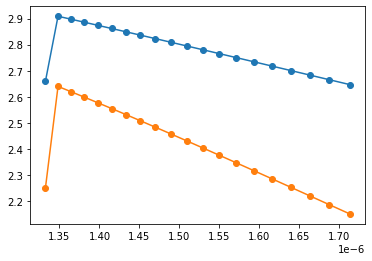

In [2]:
π = np.pi
from ceviche.constants import *
λs = C_0 * 2 * π / omegas 

plt.plot(λs,neff,'-o')

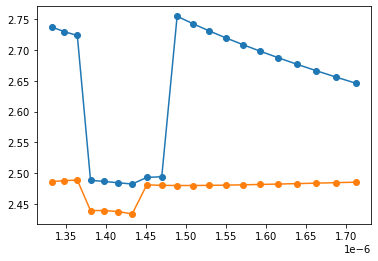

In [2]:
π = np.pi
from ceviche.constants import *
λs = C_0 * 2 * π / omegas 

plt.plot(λs,neff,'-o')

In [4]:
# E.shape # (40, 160, 60, 2) = (2*len(omegas),Nx,Ny,n_eigs)
E.shape
# neff.shape # (20, 2)
# E = E.reshape((20, 2, 160, 60, 2))
# ms.eps_r = epsr
# om_ind = 0
# ω = omegas
# ms.plot_modes(ω[om_ind],E[om_ind])

AttributeError: 'tuple' object has no attribute 'shape'

In [3]:
# Simulate initial device


In [4]:
Es.shape

(40, 160, 60, 2)

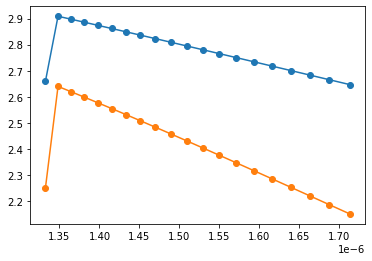

In [5]:
plt.plot(λs,neffs1,'-o')

In [10]:
# neff0,E0 = ms.solve_single(omegas[0],epsr)
ind_om=0
ind_mode=0
# Es[ind_om,:,:,:].shape
ms.plot_modes(omegas[ind_om],Es[ind_om,:,:,ind_mode])

ValueError: too many values to unpack (expected 2)

In [3]:
# Define optimization objective
def measure_disp(neff,omega):
    p = numpy.polyfit(omega, neff, 1)
    dn_domega_mean = p[0]
    dn_domega_variance = neff
    return npa.abs(npa.sum(npa.conj(Ez)*probes[probe_ind]))

def objective(rho, probe_ind=objective_port_ind):
    rho = rho.reshape((Nx, Ny))
    _rho = make_rho(rho, design_region, radius=blur_radius)
    epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(_rho, beta=beta, eta=eta) * design_region
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez, probe_ind=probe_ind)

# # Run optimization
# objective_jac = jacobian(objective, mode='reverse')
# (rho_optimum, loss) = adam_optimize(objective, rho_init.flatten(), objective_jac, 
#                             Nsteps=Nsteps, direction='max',
#                             step_size=step_size)
# rho_optimum = rho_optimum.reshape((Nx, Ny))


NameError: name 'space_slice' is not defined

I_H0 = 8.147178815547686e-23


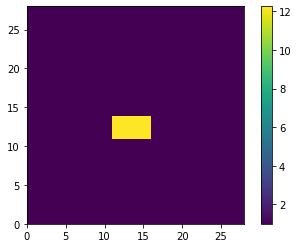

In [11]:
# create example FDFD object with eps_r grid

import sys
sys.path.append('../ceviche')

from ceviche import fdfd_hz, jacobian
from ceviche.utils import imarr

""" Optimize intensity focusing through a box with continuous varying permittivity """

# whether to plot setup stuff
PLOT = True

# make parameters
omega = 2 * np.pi * 200e12  # lambda = 1.5 um
dL = 100e-9
eps_max = 2
npml = 4
spc = 0
Lx = 2e-6
Ly = 2e-6
n_si = 3.5
# dx_ridge = 1e-6
# dy_ridge = 0.22e-6
# dx_slab = 2.0e-6
# dy_slab = 0.1e-6
dx_ridge = 0.5e-6
dy_ridge = 0.3e-6
dx_slab = 2.0e-6
dy_slab = 0.06e-6
yoffs=0
Nx, Ny = 2*npml + 4*spc + int(Lx/dL), 2*npml + 4*spc + int(Ly/dL)
eps_r = np.ones((Nx, Ny))
eps_r[int(Nx/2-dx_ridge/dL/2):int(Nx/2+dx_ridge/dL/2), int(Ny/2)+yoffs:int(Ny/2+dy_ridge/dL)+yoffs] = n_si**2
# eps_r[int(Nx/2-dx_slab/dL/2):int(Nx/2+dx_slab/dL/2), int(Ny/2):int(Ny/2+dy_slab/dL)] = n_si**2

# make source
source = np.zeros((Nx, Ny))
source[npml+spc, Ny//2] = 1

# make design region
box_region = np.zeros((Nx, Ny))
box_region[npml+2*spc:npml+2*spc+int(Lx/dL), npml+2*spc:npml+2*spc+int(Ly/dL)] = 1

# make the accelration probe
probe = np.zeros((Nx, Ny), dtype=np.complex128)
probe[-npml-spc, Ny//2] = 1

# plot the probe through channel
# p = plt.imshow(np.abs(imarr(probe + box_region + source)))
# plt.colorbar(p)
# plt.show()

# vacuum test, get normalization
F = fdfd_hz(omega, dL, eps_r, [npml, npml])
Ex, Ey, Hz = F.solve(source)
E_mag = np.sqrt(np.square(np.abs(Ex)) + np.square(np.abs(Ey)))
H_mag = np.abs(Hz)
I_E0 = np.abs(np.square(np.sum(E_mag * probe)))
I_H0 = np.abs(np.square(np.sum(H_mag * probe)))

print('I_H0 = {}'.format(I_H0))

plt.pcolormesh(imarr(F.eps_r))
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()

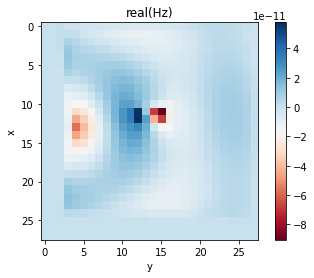

In [3]:
plt.imshow(np.real(imarr(Hz)), cmap='RdBu')
plt.title('real(Hz)')
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
plt.show()

In [4]:
# construct A matrix for H-field eigensolve

# construct quadrants of [[ϵx, 0],[0, ϵy]] @ [Dx Dy]^T @ ϵz^[-1] @ [Dx Dy]
self = F
eps_vec_xx, eps_vec_yy, eps_vec_zz = _grid_average_3d(F)
eps_vec_xx_inv = 1 / (eps_vec_xx + 1e-5)  # the 1e-5 is for numerical stability
eps_vec_yy_inv = 1 / (eps_vec_yy + 1e-5)  # autograd throws 'divide by zero' errors.
eps_vec_zz_inv = 1 / (eps_vec_zz + 1e-5)

indices_diag = npa.vstack((npa.arange(self.N), npa.arange(self.N)))


entries_DxEpsz,   indices_DxEpsz   = spsp_mult(self.entries_Dxf, self.indices_Dxf, eps_vec_zz_inv, indices_diag, self.N)
entries_DxEpszDx, indices_DxEpszDx = spsp_mult(entries_DxEpsz, indices_DxEpsz, self.entries_Dxb, self.indices_Dxb, self.N)
entries_DxEpszDy, indices_DxEpszDy = spsp_mult(entries_DxEpsz, indices_DxEpsz, -1*self.entries_Dyb, self.indices_Dyb, self.N)
entries_EpsxDxEpszDy, indices_EpsxDxEpszDy = spsp_mult(eps_vec_xx, indices_diag, entries_DxEpszDy, indices_DxEpszDy, self.N)
entries_EpsxDxEpszDx, indices_EpsxDxEpszDx = spsp_mult(eps_vec_xx, indices_diag, entries_DxEpszDx, indices_DxEpszDx, self.N)

entries_DyEpsz,   indices_DyEpsz   = spsp_mult(-1*self.entries_Dyf, self.indices_Dyf, eps_vec_zz_inv, indices_diag, self.N)
entries_DyEpszDy, indices_DyEpszDy = spsp_mult(entries_DyEpsz, indices_DyEpsz, -1*self.entries_Dyb, self.indices_Dyb, self.N)
entries_DyEpszDx, indices_DyEpszDx = spsp_mult(entries_DyEpsz, indices_DyEpsz, self.entries_Dxb, self.indices_Dxb, self.N)
entries_EpsyDyEpszDy, indices_EpsyDyEpszDy = spsp_mult(eps_vec_yy, indices_diag, entries_DyEpszDy, indices_DyEpszDy, self.N)
entries_EpsyDyEpszDx, indices_EpsyDyEpszDx = spsp_mult(eps_vec_yy, indices_diag, entries_DyEpszDx, indices_DyEpszDx, self.N)

# entries_DxEpsz,   indices_DxEpsz   = spsp_mult(self.entries_Dxb, self.indices_Dxb, eps_vec_zz_inv, indices_diag, self.N)
# entries_DxEpszDx, indices_DxEpszDx = spsp_mult(entries_DxEpsz, indices_DxEpsz, self.entries_Dxf, self.indices_Dxf, self.N)
# entries_DxEpszDy, indices_DxEpszDy = spsp_mult(entries_DxEpsz, indices_DxEpsz, -1*self.entries_Dyf, self.indices_Dyf, self.N)
# entries_EpsxDxEpszDy, indices_EpsxDxEpszDy = spsp_mult(eps_vec_xx, indices_diag, entries_DxEpszDy, indices_DxEpszDy, self.N)
# entries_EpsxDxEpszDx, indices_EpsxDxEpszDx = spsp_mult(eps_vec_xx, indices_diag, entries_DxEpszDx, indices_DxEpszDx, self.N)

# entries_DyEpsz,   indices_DyEpsz   = spsp_mult(-1*self.entries_Dyb, self.indices_Dyb, eps_vec_zz_inv, indices_diag, self.N)
# entries_DyEpszDy, indices_DyEpszDy = spsp_mult(entries_DyEpsz, indices_DyEpsz, -1*self.entries_Dyf, self.indices_Dyf, self.N)
# entries_DyEpszDx, indices_DyEpszDx = spsp_mult(entries_DyEpsz, indices_DyEpsz, self.entries_Dxf, self.indices_Dxf, self.N)
# entries_EpsyDyEpszDy, indices_EpsyDyEpszDy = spsp_mult(eps_vec_yy, indices_diag, entries_DyEpszDy, indices_DyEpszDy, self.N)
# entries_EpsyDyEpszDx, indices_EpsyDyEpszDx = spsp_mult(eps_vec_yy, indices_diag, entries_DyEpszDx, indices_DyEpszDx, self.N)

 

# shift the indices into each of the 4 quadrants
indices_EpsxDxEpszDx += self.N       # shift into bottom right quadrant
indices_EpsyDyEpszDx[1,:] += self.N  # shift into top right quadrant
indices_EpsxDxEpszDy[0,:] += self.N  # shift into bottom left quadrant

# get full matrix entries and indices
entries_DEpszD = npa.hstack((entries_EpsyDyEpszDy,
                             entries_EpsyDyEpszDx,
                             entries_EpsxDxEpszDy,
                             entries_EpsxDxEpszDx))
indices_DEpszD = npa.hstack((indices_EpsyDyEpszDy,
                             indices_EpsyDyEpszDx,
                             indices_EpsxDxEpszDy,
                             indices_EpsxDxEpszDx))


#### construct curl operator 

# # notation: C = [[C11, C12], [C21, C22]]

entries_c11, indices_c11 =  spsp_mult(self.entries_Dxb, self.indices_Dxb, self.entries_Dxf, self.indices_Dxf,self.N) # self.Dyb.dot(self.Dyf)
entries_c22, indices_c22 =  spsp_mult(self.entries_Dyb, self.indices_Dyb, self.entries_Dyf, self.indices_Dyf,self.N) # self.Dxb.dot(self.Dxf)
entries_c12, indices_c12 =  spsp_mult(self.entries_Dxb, self.indices_Dxb, self.entries_Dyf, self.indices_Dyf,self.N) # self.Dyb.dot(self.Dxf)
entries_c21, indices_c21 =  spsp_mult(self.entries_Dyb, self.indices_Dyb, self.entries_Dxf, self.indices_Dxf,self.N) # self.Dxb.dot(self.Dyf)

# entries_c11, indices_c11 =  spsp_mult(self.entries_Dyf, self.indices_Dyf, self.entries_Dyb, self.indices_Dyb,self.N) # self.Dyb.dot(self.Dyf)
# entries_c22, indices_c22 =  spsp_mult(self.entries_Dxf, self.indices_Dxf, self.entries_Dxb, self.indices_Dxb,self.N) # self.Dxb.dot(self.Dxf)
# entries_c12, indices_c12 =  spsp_mult(self.entries_Dxf, self.indices_Dxf, self.entries_Dyb, self.indices_Dyb,self.N) # self.Dyb.dot(self.Dxf)
# entries_c21, indices_c21 =  spsp_mult(self.entries_Dyf, self.indices_Dyf, self.entries_Dxb, self.indices_Dxb,self.N) # self.Dxb.dot(self.Dyf)

# shift the indices into each of the 4 quadrants
indices_c22 += self.N       # shift into bottom right quadrant
indices_c12[1,:] += self.N  # shift into top right quadrant
indices_c21[0,:] += self.N  # shift into bottom left quadrant

# get full matrix entries and indices
entries_c = npa.hstack((entries_c11, entries_c12, entries_c21, entries_c22))
indices_c = npa.hstack((indices_c11, indices_c12, indices_c21, indices_c22))

# indices into the diagonal of a sparse matrix
entries_diag = (self.omega/C_0)**2 * npa.hstack((eps_vec_yy, eps_vec_xx))
indices_diag = npa.vstack((npa.arange(2*self.N), npa.arange(2*self.N)))

# put together the big A and return entries and indices
entries_a = npa.hstack((entries_diag, entries_DEpszD, entries_c))
indices_a = npa.hstack((indices_diag, indices_DEpszD, indices_c))

A = make_sparse(entries_a,indices_a,(2*F.N,2*F.N))

# e,inds = get_entries_indices(A) # store sparse matrix data in autograd compatible format

#2 x 3 um, 5nm grid, 12 x pml # 529152x529152 sparse matrix of type '<class 'numpy.complex128'>' with 4762368 stored elements 
# 1.2 x 1.5 um, 15nm grid, 4 x pml 20608x20608 sparse matrix of type '<class 'numpy.complex128'>' with 185472 stored 

In [5]:
neff_est = 2.8
β_est = F.omega/C_0*neff_est
# β_sq,H_perp = eigs(A,2,which='LR') # sigma=β_est**2)
β_sq,H_perp = eigs(A,2,sigma=β_est**2)
k0 = F.omega/ C_0
np.sqrt(β_sq)/k0

array([2.6660258 -3.97859492e-10j, 2.36775322-6.41435892e-09j])

In [84]:
m = 0
β = np.sqrt(β_sq[m])
N = int(H_perp.shape[0]/2)

xlim = None
ylim = None

vmin = -1
vmax = 1

from matplotlib import cm

cmap = cm.RdBu
cmap_index= cm.viridis
cmap_Esq = cm.magma

# xlim = 20,80
# ylim = 40,70

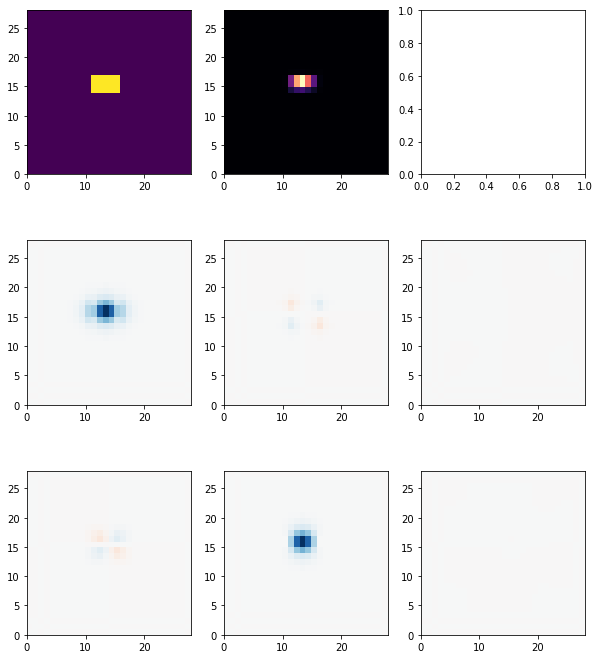

In [85]:
# calc and plot fields

def sp_mult_Dzf(vec):
    return 1j*β*vec

def sp_mult_Dzb(vec):
    return -1j*β*vec

def _Hx_Hy_to_Ez(self, Hx_vec, Hy_vec, eps_vec_zz):
        return  1 / 1j / self.omega / EPSILON_0 / (eps_vec_zz + 1e-5) * (self.sp_mult_Dxb(Hy_vec) - self.sp_mult_Dyb(Hx_vec))
    
def _Hy_Hz_to_Ex(self, Hy_vec, Hz_vec, eps_vec_xx):
        return  1 / 1j / self.omega / EPSILON_0 / (eps_vec_xx + 1e-5) * (self.sp_mult_Dyb(Hz_vec) - sp_mult_Dzb(Hy_vec))

def _Hz_Hx_to_Ey(self, Hz_vec, Hx_vec, eps_vec_yy):
        return  1 / 1j / self.omega / EPSILON_0 / (eps_vec_yy + 1e-5) * (sp_mult_Dzb(Hx_vec) - self.sp_mult_Dxb(Hz_vec))

Hx_vec = H_perp[:N,m]
Hy_vec = H_perp[N:,m]
Hz_vec = ( F.sp_mult_Dxf(Hx_vec) + F.sp_mult_Dyf(Hy_vec) ) / (1j*β)

Ex_vec = _Hy_Hz_to_Ex(F, Hy_vec, Hz_vec, eps_vec_xx)
Ey_vec = _Hz_Hx_to_Ey(F, Hz_vec, Hx_vec, eps_vec_yy)
Ez_vec = _Hx_Hy_to_Ez(F, Hx_vec, Hy_vec, eps_vec_zz)

# Ex_vec = (F.sp_mult_Dyf(Hz_vec) + sp_mult_Dzf(Hy_vec)) * eps_vec_xx_inv
# Ey_vec = (sp_mult_Dzf(Hx_vec) + F.sp_mult_Dxf(Hz_vec)) * eps_vec_yy_inv
# Ez_vec = (F.sp_mult_Dxf(Hy_vec) + F.sp_mult_Dyf(Hx_vec)) * eps_vec_zz_inv

Ex_mag_max = np.abs(Ex_vec).max()
Ey_mag_max = np.abs(Ey_vec).max()
if Ex_mag_max>Ey_mag_max:
    Emax = Ex_vec[np.abs(Ex_vec).argmax()]
else:
    Emax = Ey_vec[np.abs(Ey_vec).argmax()]
Ex_vec = Ex_vec/Emax
Ey_vec = Ey_vec/Emax
Ez_vec = Ez_vec/Emax

Hx_mag_max = np.abs(Hx_vec).max()
Hy_mag_max = np.abs(Hy_vec).max()
if Hx_mag_max>Hy_mag_max:
    Hmax = Hx_vec[np.abs(Hx_vec).argmax()]
else:
    Hmax = Hy_vec[np.abs(Hy_vec).argmax()]
Hx_vec = Hx_vec/Hmax
Hy_vec = Hy_vec/Hmax
Hz_vec = Hz_vec/Hmax


Hx = Hx_vec.reshape(F.shape)
Hy = Hy_vec.reshape(F.shape)
Hz = Hz_vec.reshape(F.shape)

Ex = Ex_vec.reshape(F.shape)
Ey = Ey_vec.reshape(F.shape)
Ez = Ez_vec.reshape(F.shape)

ϵEsq = eps_r * (np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

fig,ax = plt.subplots(3,3,figsize=(10,12))

ax[0,0].pcolormesh(np.sqrt(F.eps_r).T,cmap=cmap_index)
ax[0,1].pcolormesh(ϵEsq.T,cmap=cmap_Esq)
# ax[0,2].pcolormesh(Ez)

ax[1,0].pcolormesh(Ex.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
ax[1,1].pcolormesh(Ey.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
ax[1,2].pcolormesh(Ez.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
# ax[1,2].pcolormesh(Ez.real.T)

ax[2,0].pcolormesh(Hx.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
ax[2,1].pcolormesh(Hy.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
ax[2,2].pcolormesh(Hz.real.T,vmin=vmin,vmax=vmax,cmap=cmap)

for a in ax.flatten():
    if xlim:
        a.set_xlim(xlim)
    if ylim:
        a.set_ylim(ylim)
    a.set_aspect('equal')

In [118]:
m = 1
β = np.sqrt(β_sq[m])
N = int(H_perp.shape[0]/2)

xlim = None
ylim = None

vmin = -1
vmax = 1

# xlim = 20,80
# ylim = 40,70

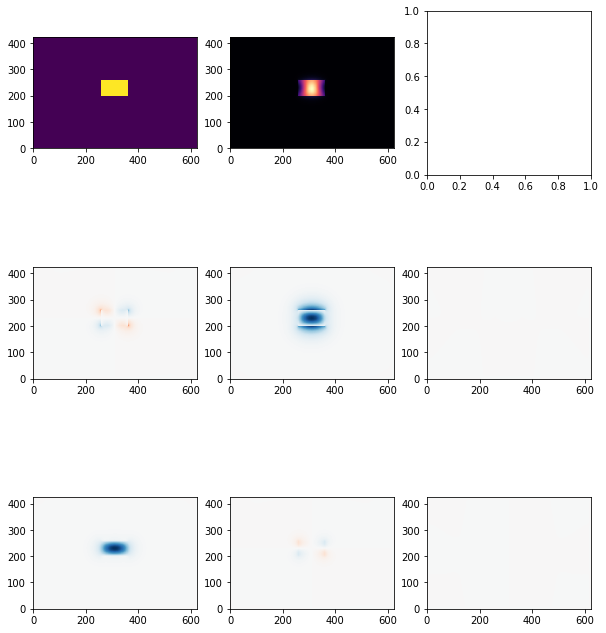

In [119]:
# calc and plot fields

def sp_mult_Dzf(vec):
    return 1j*β*vec

def sp_mult_Dzb(vec):
    return -1j*β*vec

def _Hx_Hy_to_Ez(self, Hx_vec, Hy_vec, eps_vec_zz):
        return  1 / 1j / self.omega / EPSILON_0 / (eps_vec_zz + 1e-5) * (self.sp_mult_Dxb(Hy_vec) - self.sp_mult_Dyb(Hx_vec))
    
def _Hy_Hz_to_Ex(self, Hy_vec, Hz_vec, eps_vec_xx):
        return  1 / 1j / self.omega / EPSILON_0 / (eps_vec_xx + 1e-5) * (self.sp_mult_Dyb(Hz_vec) - sp_mult_Dzb(Hy_vec))

def _Hz_Hx_to_Ey(self, Hz_vec, Hx_vec, eps_vec_yy):
        return  1 / 1j / self.omega / EPSILON_0 / (eps_vec_yy + 1e-5) * (sp_mult_Dzb(Hx_vec) - self.sp_mult_Dxb(Hz_vec))

Hx_vec = H_perp[:N,m]
Hy_vec = H_perp[N:,m]
Hz_vec = ( F.sp_mult_Dxf(Hx_vec) + F.sp_mult_Dyf(Hy_vec) ) / (1j*β)

Ex_vec = _Hy_Hz_to_Ex(F, Hy_vec, Hz_vec, eps_vec_xx)
Ey_vec = _Hz_Hx_to_Ey(F, Hz_vec, Hx_vec, eps_vec_yy)
Ez_vec = _Hx_Hy_to_Ez(F, Hx_vec, Hy_vec, eps_vec_zz)

# Ex_vec = (F.sp_mult_Dyf(Hz_vec) + sp_mult_Dzf(Hy_vec)) * eps_vec_xx_inv
# Ey_vec = (sp_mult_Dzf(Hx_vec) + F.sp_mult_Dxf(Hz_vec)) * eps_vec_yy_inv
# Ez_vec = (F.sp_mult_Dxf(Hy_vec) + F.sp_mult_Dyf(Hx_vec)) * eps_vec_zz_inv

Ex_mag_max = np.abs(Ex_vec).max()
Ey_mag_max = np.abs(Ey_vec).max()
if Ex_mag_max>Ey_mag_max:
    Emax = Ex_vec[np.abs(Ex_vec).argmax()]
else:
    Emax = Ey_vec[np.abs(Ey_vec).argmax()]
Ex_vec = Ex_vec/Emax
Ey_vec = Ey_vec/Emax
Ez_vec = Ez_vec/Emax

Hx_mag_max = np.abs(Hx_vec).max()
Hy_mag_max = np.abs(Hy_vec).max()
if Hx_mag_max>Hy_mag_max:
    Hmax = Hx_vec[np.abs(Hx_vec).argmax()]
else:
    Hmax = Hy_vec[np.abs(Hy_vec).argmax()]
Hx_vec = Hx_vec/Hmax
Hy_vec = Hy_vec/Hmax
Hz_vec = Hz_vec/Hmax


Hx = Hx_vec.reshape(F.shape)
Hy = Hy_vec.reshape(F.shape)
Hz = Hz_vec.reshape(F.shape)

Ex = Ex_vec.reshape(F.shape)
Ey = Ey_vec.reshape(F.shape)
Ez = Ez_vec.reshape(F.shape)

ϵEsq = eps_r * (np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

fig,ax = plt.subplots(3,3,figsize=(10,12))

ax[0,0].pcolormesh(np.sqrt(F.eps_r).T,cmap=cmap_index)
ax[0,1].pcolormesh(ϵEsq.T,cmap=cmap_Esq)
# ax[0,2].pcolormesh(Ez)

ax[1,0].pcolormesh(Ex.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
ax[1,1].pcolormesh(Ey.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
ax[1,2].pcolormesh(Ez.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
# ax[1,2].pcolormesh(Ez.real.T)

ax[2,0].pcolormesh(Hx.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
ax[2,1].pcolormesh(Hy.real.T,vmin=vmin,vmax=vmax,cmap=cmap)
ax[2,2].pcolormesh(Hz.real.T,vmin=vmin,vmax=vmax,cmap=cmap)

for a in ax.flatten():
    if xlim:
        a.set_xlim(xlim)
    if ylim:
        a.set_ylim(ylim)
    a.set_aspect('equal')

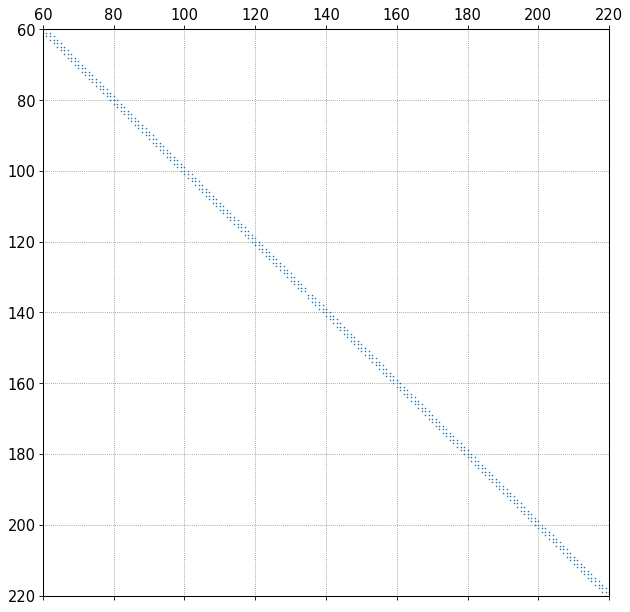

In [14]:
# e,i = entries_DyEpszDy, indices_DyEpszDy
# e,i = entries_c, indices_c

N_offs = None
N_plot = None

N_offs = 140 # 18220
N_plot = 160
ms = 0.5

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.spy(A,markersize=ms)

if N_plot:
    if not N_offs:
        N_offs = N_plot/2 
    ax.set_ylim(N_offs+N_plot/2,N_offs-N_plot/2)
    ax.set_xlim(N_offs-N_plot/2,N_offs+N_plot/2)

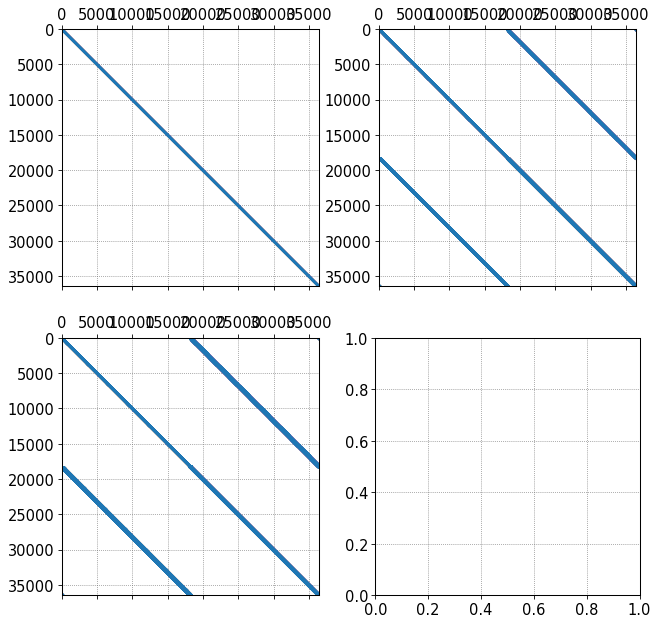

In [15]:
# e,i = entries_DyEpszDy, indices_DyEpszDy
# e,i = entries_c, indices_c


N_offs = None
N_plot = None

N_offs = 18220
# N_plot = 500
ms = 0.5

fig,ax = plt.subplots(2,2,figsize=(10,10))
e,i = entries_diag, indices_diag
ax[0,0].spy(make_sparse(e,i,(2*F.N,2*F.N)),markersize=ms)

e,i = entries_DEpszD, indices_DEpszD
ax[0,1].spy(make_sparse(e,i,(2*F.N,2*F.N)),markersize=ms)

e,i = entries_a, indices_a
ax[1,0].spy(make_sparse(e,i,(2*F.N,2*F.N)),markersize=ms)


if N_plot:
    if not N_offs:
        N_offs = N_plot/2 
    for a in ax.flatten():
        a.set_ylim(N_offs+N_plot/2,N_offs-N_plot/2)
        a.set_xlim(N_offs-N_plot/2,N_offs+N_plot/2)

In [31]:
# notation: C = [[C11, C12], [C21, C22]]
entries_c11, indices_c11 =  spsp_mult(self.entries_Dyb, self.indices_Dyb, self.entries_Dyf, self.indices_Dyf,self.N) # self.Dyb.dot(self.Dyf)
entries_c22, indices_c22 =  spsp_mult(self.entries_Dxb, self.indices_Dxb, self.entries_Dxf, self.indices_Dxf,self.N) # self.Dxb.dot(self.Dxf)
entries_c12, indices_c12 =  spsp_mult(self.entries_Dxb, self.indices_Dxb, self.entries_Dyf, self.indices_Dyf,self.N) # self.Dyb.dot(self.Dxf)
entries_c21, indices_c21 =  spsp_mult(self.entries_Dyb, self.indices_Dyb, self.entries_Dxf, self.indices_Dxf,self.N) # self.Dxb.dot(self.Dyf)

# entries_c11, indices_c11 =  spsp_mult(self.entries_Dyf, self.indices_Dyf, self.entries_Dyb, self.indices_Dyb,self.N) # self.Dyb.dot(self.Dyf)
# entries_c22, indices_c22 =  spsp_mult(self.entries_Dxf, self.indices_Dxf, self.entries_Dxb, self.indices_Dxb,self.N) # self.Dxb.dot(self.Dxf)
# entries_c12, indices_c12 =  spsp_mult(self.entries_Dxf, self.indices_Dxf, self.entries_Dyb, self.indices_Dyb,self.N) # self.Dyb.dot(self.Dxf)
# entries_c21, indices_c21 =  spsp_mult(self.entries_Dyf, self.indices_Dyf, self.entries_Dxb, self.indices_Dxb,self.N) # self.Dxb.dot(self.Dyf)

# shift the indices into each of the 4 quadrants
indices_c22 += self.N       # shift into bottom right quadrant
indices_c12[1,:] += self.N  # shift into top right quadrant
indices_c21[0,:] += self.N  # shift into bottom left quadrant

# get full matrix entries and indices
entries_c = npa.hstack((entries_c11, entries_c12, entries_c21, entries_c22))
indices_c = npa.hstack((indices_c11, indices_c12, indices_c21, indices_c22))

# indices into the diagonal of a sparse matrix
entries_diag = - EPSILON_0 * self.omega**2 * npa.hstack((eps_vec_xx, eps_vec_yy))
indices_diag = npa.vstack((npa.arange(2 * self.N), npa.arange(2 * self.N)))

# put together the big A and return entries and indices
entries_a = npa.hstack((entries_diag, entries_c))
indices_a = npa.hstack((indices_diag, indices_c))

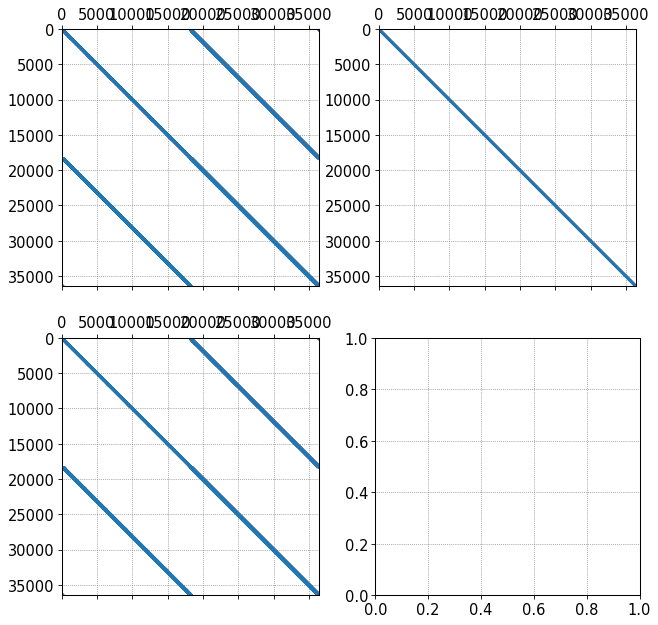

In [33]:
# e,i = entries_DyEpszDy, indices_DyEpszDy
# e,i = entries_c, indices_c

N_offs = 18220
N_plot = None
ms = 0.5

fig,ax = plt.subplots(2,2,figsize=(10,10))
e,i = entries_c, indices_c
ax[0,0].spy(make_sparse(e,i,(2*F.N,2*F.N)),markersize=ms)

e,i = entries_diag, indices_diag
ax[0,1].spy(make_sparse(e,i,(2*F.N,2*F.N)),markersize=ms)

e,i = entries_a, indices_a
ax[1,0].spy(make_sparse(e,i,(2*F.N,2*F.N)),markersize=ms)

if N_plot:
    for a in ax.flatten():
        a.set_ylim(N_offs+N_plot/2,N_offs-N_plot/2)
        a.set_xlim(N_offs-N_plot/2,N_offs+N_plot/2)

In [ ]:
#

# get entries and indices
entries_m11, indices_m11 = get_entries_indices(M11)
entries_m22, indices_m22 = get_entries_indices(M22)
entries_m12, indices_m12 = get_entries_indices(M12)
entries_m21, indices_m21 = get_entries_indices(M21)

# shift the indices into each of the 4 quadrants
indices_m22 += self.N       # shift into bottom right quadrant
indices_m12[1,:] += self.N  # shift into top right quadrant
indices_m21[0,:] += self.N  # shift into bottom left quadrant

# get full matrix entries and indices
entries_m = npa.hstack((entries_m11, entries_m12, entries_m21, entries_m22))
indices_m = npa.hstack((indices_m11, indices_m12, indices_m21, indices_m22))


# entries_d = 1 / EPSILON_0 * npa.hstack((entries_DxEpsyDx, entries_DyEpsxDy))
# indices_d = npa.hstack((indices_DxEpsyDx, indices_DyEpsxDy))
#
# entries_diag = MU_0 * self.omega**2 * npa.ones(self.N)
#
# entries_a = npa.hstack((entries_d, entries_diag))
# indices_a = npa.hstack((indices_d, indices_diag))

# notation: C = [[C11, C12], [C21, C22]]
C11 =  spsp_mult(self.entries_Dyb, self.indices_Dyb, self.entries_Dyf, self.indices_Dyf,self.N) # self.Dyb.dot(self.Dyf)
C22 =  spsp_mult(self.entries_Dxb, self.indices_Dxb, self.entries_Dxf, self.indices_Dxf,self.N) # self.Dxb.dot(self.Dxf)
C12 =  spsp_mult(self.entries_Dxb, self.indices_Dxb, self.entries_Dyf, self.indices_Dyf,self.N) # self.Dyb.dot(self.Dxf)
C21 =  spsp_mult(self.entries_Dyb, self.indices_Dyb, self.entries_Dxf, self.indices_Dxf,self.N) # self.Dxb.dot(self.Dyf)


# get entries and indices
entries_c11, indices_c11 = get_entries_indices(C11)
entries_c22, indices_c22 = get_entries_indices(C22)
entries_c12, indices_c12 = get_entries_indices(C12)
entries_c21, indices_c21 = get_entries_indices(C21)

# shift the indices into each of the 4 quadrants
indices_c22 += self.N       # shift into bottom right quadrant
indices_c12[1,:] += self.N  # shift into top right quadrant
indices_c21[0,:] += self.N  # shift into bottom left quadrant

# get full matrix entries and indices
entries_c = npa.hstack((entries_c11, entries_c12, entries_c21, entries_c22))
indices_c = npa.hstack((indices_c11, indices_c12, indices_c21, indices_c22))

# indices into the diagonal of a sparse matrix
entries_diag = - EPSILON_0 * self.omega**2 * npa.hstack((eps_vec_xx, eps_vec_yy))
indices_diag = npa.vstack((npa.arange(2 * self.N), npa.arange(2 * self.N)))

# put together the big A and return entries and indices
entries_a = npa.hstack((entries_diag, entries_c))
indices_a = npa.hstack((indices_diag, indices_c))

# Ceviche with JAX

# Legume

In [6]:
# fancompute/ceviche/utils.py
import numpy as np
import scipy.sparse as sp
import copy
import autograd.numpy as npa
import matplotlib.pylab as plt
from autograd.extend import primitive, vspace, defvjp, defjvp

""" Useful functions """


""" ==================== SPARSE MATRIX UTILITIES ==================== """

def make_sparse(entries, indices, shape):
    """Construct a sparse csr matrix
    Args:
      entries: numpy array with shape (M,) giving values for non-zero
        matrix entries.
      indices: numpy array with shape (2, M) giving x and y indices for
        non-zero matrix entries.
      shape: shape of resulting matrix
    Returns:
      sparse, complex, matrix with specified values
    """  
    coo = sp.coo_matrix((entries, indices), shape=shape, dtype=npa.complex128)
    return coo.tocsr()

def get_entries_indices(csr_matrix):
    # takes sparse matrix and returns the entries and indeces in form compatible with 'make_sparse'
    shape = csr_matrix.shape
    coo_matrix = csr_matrix.tocoo()
    entries = csr_matrix.data
    cols = coo_matrix.col
    rows = coo_matrix.row
    indices = npa.vstack((rows, cols))
    return entries, indices

def transpose_indices(indices):
    # returns the transposed indices for transpose sparse matrix creation
   return npa.flip(indices, axis=0)

def block_4(A, B, C, D):
    """ Constructs a big matrix out of four sparse blocks
        returns [A B]
                [C D]
    """
    left = sp.vstack([A, C])
    right = sp.vstack([B, D])
    return sp.hstack([left, right])    

def make_IO_matrices(indices, N):
    """ Makes matrices that relate the sparse matrix entries to their locations in the matrix
            The kth column of I is a 'one hot' vector specifing the k-th entries row index into A
            The kth column of J is a 'one hot' vector specifing the k-th entries columnn index into A
            O = J^T is for notational convenience.
            Armed with a vector of M entries 'a', we can construct the sparse matrix 'A' as:
                A = I @ diag(a) @ O
            where 'diag(a)' is a (MxM) matrix with vector 'a' along its diagonal.
            In index notation:
                A_ij = I_ik * a_k * O_kj
            In an opposite way, given sparse matrix 'A' we can strip out the entries `a` using the IO matrices as follows:
                a = diag(I^T @ A @ O^T)
            In index notation:
                a_k = I_ik * A_ij * O_kj
    """
    M = indices.shape[1]                                 # number of indices in the matrix
    entries_1 = npa.ones(M)                              # M entries of all 1's
    ik, jk = indices                                     # separate i and j components of the indices
    indices_I = npa.vstack((ik, npa.arange(M)))          # indices into the I matrix
    indices_J = npa.vstack((jk, npa.arange(M)))          # indices into the J matrix
    I = make_sparse(entries_1, indices_I, shape=(N, M))  # construct the I matrix
    J = make_sparse(entries_1, indices_J, shape=(N, M))  # construct the J matrix
    O = J.T                                              # make O = J^T matrix for consistency with my notes.
    return I, O


""" ==================== DATA GENERATION UTILITIES ==================== """

def make_rand(N):
    # makes a random vector of size N with elements between -0.5 and 0.5
    return npa.random.random(N) - 0.5

def make_rand_complex(N):
    # makes a random complex-valued vector of size N with re and im parts between -0.5 and 0.5
    return make_rand(N) + 1j * make_rand(N)

def make_rand_indeces(N, M):
    # make M random indeces into an NxN matrix
    return npa.random.randint(low=0, high=N, size=(2, M))

def make_rand_entries_indices(N, M):
    # make M random indeces and corresponding entries
    entries = make_rand_complex(M)
    indices = make_rand_indeces(N, M)
    return entries, indices

def make_rand_sparse(N, M):
    # make a random sparse matrix of shape '(N, N)' and 'M' non-zero elements
    entries, indices = make_rand_entries_indices(N, M)
    return make_sparse(entries, indices, shape=(N, N))

def make_rand_sparse_density(N, density=1):
    """ Makes a sparse NxN matrix, another way to do it with density """
    return sp.random(N, N, density=density) + 1j * sp.random(N, N, density=density)


""" ==================== NUMERICAL DERIVAITVES ==================== """

def der_num(fn, arg, index, delta):
    # numerical derivative of `fn(arg)` with respect to `index` into arg and numerical step size `delta`
    arg_i_for  = arg.copy()
    arg_i_back = arg.copy()
    arg_i_for[index] += delta / 2
    arg_i_back[index] -= delta / 2
    df_darg = (fn(arg_i_for) - fn(arg_i_back)) / delta
    return df_darg

def grad_num(fn, arg, delta=1e-6):
    # take a (complex) numerical gradient of function 'fn' with argument 'arg' with step size 'delta'
    N = arg.size
    grad = npa.zeros((N,), dtype=npa.complex128)
    f0 = fn(arg)
    for i in range(N):
        grad[i] = der_num(fn, arg, i, delta)        # real part
        grad[i] += der_num(fn, arg, i, 1j * delta)  # imaginary part
    return grad

def jac_num(fn, arg, step_size=1e-7):
    """ DEPRICATED: use 'numerical' in jacobians.py instead
    numerically differentiate `fn` w.r.t. its argument `arg` 
    `arg` can be a numpy array of arbitrary shape
    `step_size` can be a number or an array of the same shape as `arg` """

    in_array = float_2_array(arg).flatten()
    out_array = float_2_array(fn(arg)).flatten()

    m = in_array.size
    n = out_array.size
    shape = (m, n)
    jacobian = np.zeros(shape)

    for i in range(m):
        input_i = in_array.copy()
        input_i[i] += step_size
        arg_i = input_i.reshape(in_array.shape)
        output_i = fn(arg_i).flatten()
        grad_i = (output_i - out_array) / step_size
        jacobian[i, :] = get_value(grad_i)

    return jacobian

""" ==================== FDTD AND FDFD UTILITIES ==================== """

def grid_center_to_xyz(Q_mid, averaging=True):
    """ Computes the interpolated value of the quantity Q_mid felt at the Ex, Ey, Ez positions of the Yee latice
        Returns these three components
    """

    # initialize
    Q_xx = copy.copy(Q_mid)
    Q_yy = copy.copy(Q_mid)
    Q_zz = copy.copy(Q_mid)

    # if averaging, set the respective xx, yy, zz components to the midpoint in the Yee lattice.
    if averaging:

        # get the value from the middle of the next cell over
        Q_x_r = npa.roll(Q_mid, shift=1, axis=0)
        Q_y_r = npa.roll(Q_mid, shift=1, axis=1)
        Q_z_r = npa.roll(Q_mid, shift=1, axis=2)

        # average with the two middle values
        Q_xx = (Q_mid + Q_x_r)/2
        Q_yy = (Q_mid + Q_y_r)/2
        Q_zz = (Q_mid + Q_z_r)/2

    return Q_xx, Q_yy, Q_zz


def grid_xyz_to_center(Q_xx, Q_yy, Q_zz):
    """ Computes the interpolated value of the quantitys Q_xx, Q_yy, Q_zz at the center of Yee latice
        Returns these three components
    """

    # compute the averages
    Q_xx_avg = (Q_xx.astype('float') + npa.roll(Q_xx, shift=1, axis=0))/2
    Q_yy_avg = (Q_yy.astype('float') + npa.roll(Q_yy, shift=1, axis=1))/2
    Q_zz_avg = (Q_zz.astype('float') + npa.roll(Q_zz, shift=1, axis=2))/2

    return Q_xx_avg, Q_yy_avg, Q_zz_avg

def vec_zz_to_xy(info_dict, vec_zz, grid_averaging=True):
    """ does grid averaging on z vector vec_zz """
    arr_zz = vec_zz.reshape(info_dict['shape'])[:,:,None]
    arr_xx, arr_yy, _ = grid_center_to_xyz(arr_zz, averaging=grid_averaging)
    vec_xx, vec_yy = arr_xx.flatten(), arr_yy.flatten()
    return vec_xx, vec_yy

""" ===================== TESTING AND DEBUGGING ===================== """

def float_2_array(x):
    if not isinstance(x, np.ndarray):
        return np.array([x])
    else:
        return x

def reshape_to_ND(arr, N):
    """ Adds dimensions to arr until it is dimension N
    """

    ND = len(arr.shape)
    if ND > N:
        raise ValueError("array is larger than {} dimensional, given shape {}".format(N, arr.shape))
    extra_dims = (N - ND) * (1,)
    return arr.reshape(arr.shape + extra_dims)


""" ========================= TOOLS USEFUL FOR WORKING WITH AUTOGRAD ====================== """


def get_value(x):
    if type(x) == npa.numpy_boxes.ArrayBox:
        return x._value
    else:
        return x

get_value_arr = np.vectorize(get_value)


def get_shape(x):
    """ Gets the shape of x, even if it is not an array """
    if isinstance(x, float) or isinstance(x, int):
        return (1,)
    elif isinstance(x, tuple) or isinstance(x, list):
        return (len(x),)
    else:
        return vspace(x).shape


def vjp_maker_num(fn, arg_inds, steps):
    """ Makes a vjp_maker for the numerical derivative of a function `fn`
    w.r.t. argument at position `arg_ind` using step sizes `steps` """

    def vjp_single_arg(ia):
        arg_ind = arg_inds[ia]
        step = steps[ia]

        def vjp_maker(fn_out, *args):
            shape = args[arg_ind].shape
            num_p = args[arg_ind].size
            step = steps[ia]

            def vjp(v):

                vjp_num = np.zeros(num_p)
                for ip in range(num_p):
                    args_new = list(args)
                    args_rav = args[arg_ind].flatten()
                    args_rav[ip] += step
                    args_new[arg_ind] = args_rav.reshape(shape)
                    dfn_darg = (fn(*args_new) - fn_out)/step
                    vjp_num[ip] = np.sum(v * dfn_darg)

                return vjp_num

            return vjp

        return vjp_maker

    vjp_makers = []
    for ia in range(len(arg_inds)):
        vjp_makers.append(vjp_single_arg(ia=ia))

    return tuple(vjp_makers)


""" =================== PLOTTING AND MEASUREMENT OF FDTD =================== """


def aniplot(F, source, steps, component='Ez', num_panels=10):
    """ Animate an FDTD (F) with `source` for `steps` time steps.
    display the `component` field components at `num_panels` equally spaced.
    """
    F.initialize_fields()

    # initialize the plot
    f, ax_list = plt.subplots(1, num_panels, figsize=(20*num_panels,20))
    Nx, Ny, _ = F.eps_r.shape
    ax_index = 0

    # fdtd time loop
    for t_index in range(steps):
        fields = F.forward(Jz=source(t_index))

        # if it's one of the num_panels panels
        if t_index % (steps // num_panels) == 0:

            if ax_index < num_panels:   # extra safety..sometimes tries to access num_panels-th elemet of ax_list, leading to error

                print('working on axis {}/{} for time step {}'.format(ax_index, num_panels, t_index))

                # grab the axis
                ax = ax_list[ax_index]

                # plot the fields
                im_t = ax.pcolormesh(np.zeros((Nx, Ny)), cmap='RdBu')
                max_E = np.abs(fields[component]).max()
                im_t.set_array(fields[component][:, :, 0].ravel().T)
                im_t.set_clim([-max_E / 2.0, max_E / 2.0])
                ax.set_title('time = {} seconds'.format(F.dt*t_index))

                # update the axis
                ax_index += 1
    plt.show()


def measure_fields(F, source, steps, probes, component='Ez'):
    """ Returns a time series of the measured `component` fields from FDFD `F`
        driven by `source and measured at `probe`.
    """
    F.initialize_fields()
    if not isinstance(probes, list):
        probes = [probes]
    N_probes = len(probes)
    measured = np.zeros((steps, N_probes))
    for t_index in range(steps):
        if t_index % (steps//20) == 0:
            print('{:.2f} % done'.format(float(t_index)/steps*100.0))
        fields = F.forward(Jz=source(t_index))
        for probe_index, probe in enumerate(probes):
            field_probe = np.sum(fields[component] * probe)
            measured[t_index, probe_index] = field_probe
    return measured


def imarr(arr):
    """ puts array 'arr' into form ready to plot """
    arr_value = get_value(arr)
    arr_plot = arr_value.copy()
    if len(arr.shape) == 3:
        arr_plot = arr_plot[:,:,0]
    return np.flipud(arr_plot.T)


""" ====================== FOURIER TRANSFORMS  ======================"""

from autograd.extend import primitive, defjvp
from numpy.fft import fft, fftfreq


@primitive
def my_fft(x):    
    """ 
    Wrapper for numpy's FFT, so I can add a primitive to it
        FFT(x) is like a DFT matrix (D) dot with x
    """
    return np.fft.fft(x)


def fft_grad(g, ans, x):
    """ 
    Define the jacobian-vector product of my_fft(x)
        The gradient of FFT times g is the vjp
        ans = fft(x) = D @ x
        jvp(fft(x))(g) = d{fft}/d{x} @ g
                       = D @ g
        Therefore, it looks like the FFT of g
    """
    return np.fft.fft(g)

defjvp(my_fft, fft_grad)


def get_spectrum(series, dt):
    """ Get FFT of series """

    steps = len(series)
    times = np.arange(steps) * dt

    # reshape to be able to multiply by hamming window
    series = series.reshape((steps, -1))

    # multiply with hamming window to get rid of numerical errors
    hamming_window = np.hamming(steps).reshape((steps, 1))
    signal_f = my_fft(hamming_window * series)

    freqs = np.fft.fftfreq(steps, d=dt)
    return freqs, signal_f


def get_max_power_freq(series, dt):

    freqs, signal_f = get_spectrum(series, dt)
    return freqs[np.argmax(signal_f)]


def get_spectral_power(series, dt):

    freqs, signal_f = get_spectrum(series, dt)
    return freqs, np.square(np.abs(signal_f))


def plot_spectral_power(series, dt, f_top=2e14):
    steps = len(series)
    freqs, signal_f_power = get_spectral_power(series, dt)

    # only plot half (other is redundant)
    plt.plot(freqs[:steps//2], signal_f_power[:steps//2])
    plt.xlim([0, f_top])
    plt.xlabel('frequency (Hz)')
    plt.ylabel('power (|signal|^2)')
    plt.show()


In [11]:
# fancompute/ceviche/jacobians.py
import autograd.numpy as npa

from autograd.core import make_vjp, make_jvp
from autograd.wrap_util import unary_to_nary
from autograd.extend import vspace

# from .utils import get_value, get_shape, get_value_arr, float_2_array


"""
This file provides wrappers to autograd that compute jacobians.  
The only function you'll want to use in your code is `jacobian`, 
where you can specify the mode of differentiation (reverse, forward, or numerical)
"""

def jacobian(fun, argnum=0, mode='reverse', step_size=1e-6):
    """ Computes jacobian of `fun` with respect to argument number `argnum` using automatic differentiation """

    if mode == 'reverse':
        return jacobian_reverse(fun, argnum)
    elif mode == 'forward':
        return jacobian_forward(fun, argnum)
    elif mode == 'numerical':
        return jacobian_numerical(fun, argnum, step_size=step_size)
    else:
        raise ValueError("'mode' kwarg must be either 'reverse' or 'forward' or 'numerical', given {}".format(mode))


@unary_to_nary
def jacobian_reverse(fun, x):
    """ Compute jacobian of fun with respect to x using reverse mode differentiation"""
    vjp, ans = make_vjp(fun, x)
    grads = map(vjp, vspace(ans).standard_basis())
    m, n = _jac_shape(x, ans)
    return npa.reshape(npa.stack(grads), (n, m))


@unary_to_nary
def jacobian_forward(fun, x):
    """ Compute jacobian of fun with respect to x using forward mode differentiation"""
    jvp = make_jvp(fun, x)
    # ans = fun(x)
    val_grad = map(lambda b: jvp(b), vspace(x).standard_basis())
    vals, grads = zip(*val_grad)
    ans = npa.zeros((list(vals)[0].size,))  # fake answer so that dont have to compute it twice
    m, n = _jac_shape(x, ans)
    if _iscomplex(x):
        grads_real = npa.array(grads[::2])
        grads_imag = npa.array(grads[1::2])
        grads = grads_real - 1j * grads_imag
    return npa.reshape(npa.stack(grads), (m, n)).T


@unary_to_nary
def jacobian_numerical(fn, x, step_size=1e-7):
    """ numerically differentiate `fn` w.r.t. its argument `x` """
    in_array = float_2_array(x).flatten()
    out_array = float_2_array(fn(x)).flatten()

    m = in_array.size
    n = out_array.size
    shape = (n, m)
    jacobian = npa.zeros(shape)

    for i in range(m):
        input_i = in_array.copy()
        input_i[i] += step_size
        arg_i = input_i.reshape(in_array.shape)
        output_i = fn(arg_i).flatten()
        grad_i = (output_i - out_array) / step_size
        jacobian[:, i] = get_value_arr(get_value(grad_i))  # need to convert both the grad_i array and its contents to actual data.

    return jacobian


def _jac_shape(x, ans):
    """ computes the shape of the jacobian where function has input x and output ans """
    m = float_2_array(x).size
    n = float_2_array(ans).size
    return (m, n)


def _iscomplex(x):
    """ Checks if x is complex-valued or not """
    if isinstance(x, npa.ndarray):
        if x.dtype == npa.complex128:
            return True
    if isinstance(x, complex):
        return True
    return False


# if __name__ == '__main__':

#     """ Some simple test """

#     N = 3
#     M = 2
#     A = npa.random.random((N,M))
#     B = npa.random.random((N,M))
#     print('A = \n', A)

#     def fn(x, b):
#         return A @ x + B @ b

#     x0 = npa.random.random((M,))
#     b0 = npa.random.random((M,))    
#     print('Jac_rev = \n', jacobian(fn, argnum=0, mode='reverse')(x0, b0))
#     print('Jac_for = \n', jacobian(fn, argnum=0, mode='forward')(x0, b0))
#     print('Jac_num = \n', jacobian(fn, argnum=0, mode='numerical')(x0, b0))

#     print('B = \n', B)
#     print('Jac_rev = \n', jacobian(fn, argnum=1, mode='reverse')(x0, b0))
#     print('Jac_for = \n', jacobian(fn, argnum=1, mode='forward')(x0, b0))
#     print('Jac_num = \n', jacobian(fn, argnum=1, mode='numerical')(x0, b0))



In [8]:
# fancompute/ceviche/derivatives.py
import numpy as np
import autograd.numpy as npa
import scipy.sparse as sp

############## ceviche/constants.py contents #########################

from numpy import sqrt

"""
This file contains constants that are used throghout the codebase
"""

EPSILON_0 = 8.85418782e-12        # vacuum permittivity
MU_0 = 1.25663706e-6              # vacuum permeability
C_0 = 1 / sqrt(EPSILON_0 * MU_0)  # speed of light in vacuum
ETA_0 = sqrt(MU_0 / EPSILON_0)    # vacuum impedance
Q_e = 1.602176634e-19             # funamental charge

#################################################################


"""
This file contains functions related to performing derivative operations used in the simulation tools.
-  The FDTD method requires autograd-compatible curl operations, which are performed using numpy.roll
-  The FDFD method requires sparse derivative matrices, with PML added, which are constructed here.
"""


"""================================== CURLS FOR FDTD ======================================"""

def curl_E(axis, Ex, Ey, Ez, dL):
    if axis == 0:
        return (npa.roll(Ez, shift=-1, axis=1) - Ez) / dL - (npa.roll(Ey, shift=-1, axis=2) - Ey) / dL
    elif axis == 1:
        return (npa.roll(Ex, shift=-1, axis=2) - Ex) / dL - (npa.roll(Ez, shift=-1, axis=0) - Ez) / dL
    elif axis == 2:
        return (npa.roll(Ey, shift=-1, axis=0) - Ey) / dL - (npa.roll(Ex, shift=-1, axis=1) - Ex) / dL

def curl_H(axis, Hx, Hy, Hz, dL):
    if axis == 0:
        return (Hz - npa.roll(Hz, shift=1, axis=1)) / dL - (Hy - npa.roll(Hy, shift=1, axis=2)) / dL
    elif axis == 1:
        return (Hx - npa.roll(Hx, shift=1, axis=2)) / dL - (Hz - npa.roll(Hz, shift=1, axis=0)) / dL
    elif axis == 2:
        return (Hy - npa.roll(Hy, shift=1, axis=0)) / dL - (Hx - npa.roll(Hx, shift=1, axis=1)) / dL

"""======================= STUFF THAT CONSTRUCTS THE DERIVATIVE MATRIX ==========================="""

def compute_derivative_matrices(omega, shape, npml, dL, bloch_x=0.0, bloch_y=0.0):
    """ Returns sparse derivative matrices.  Currently works for 2D and 1D 
            omega: angular frequency (rad/sec)
            shape: shape of the FDFD grid
            npml: list of number of PML cells in x and y.
            dL: spatial grid size (m)
            block_x: bloch phase (phase across periodic boundary) in x
            block_y: bloch phase (phase across periodic boundary) in y
    """

    # Construct derivate matrices without PML
    Dxf = createDws('x', 'f', shape, dL, bloch_x=bloch_x, bloch_y=bloch_y)
    Dxb = createDws('x', 'b', shape, dL, bloch_x=bloch_x, bloch_y=bloch_y)
    Dyf = createDws('y', 'f', shape, dL, bloch_x=bloch_x, bloch_y=bloch_y)
    Dyb = createDws('y', 'b', shape, dL, bloch_x=bloch_x, bloch_y=bloch_y)

    # make the S-matrices for PML
    (Sxf, Sxb, Syf, Syb) = create_S_matrices(omega, shape, npml, dL)

    # apply PML to derivative matrices
    Dxf = Sxf.dot(Dxf)
    Dxb = Sxb.dot(Dxb)
    Dyf = Syf.dot(Dyf)
    Dyb = Syb.dot(Dyb)

    return Dxf, Dxb, Dyf, Dyb

""" Derivative Matrices (no PML) """

def createDws(component, dir, shape, dL, bloch_x=0.0, bloch_y=0.0):
    """ creates the derivative matrices
            component: one of 'x' or 'y' for derivative in x or y direction
            dir: one of 'f' or 'b', whether to take forward or backward finite difference
            shape: shape of the FDFD grid
            dL: spatial grid size (m)
            block_x: bloch phase (phase across periodic boundary) in x
            block_y: bloch phase (phase across periodic boundary) in y
    """

    Nx, Ny = shape    

    # special case, a 1D problem
    if component == 'x' and Nx == 1:
        return sp.eye(Ny)
    if component is 'y' and Ny == 1:
        return sp.eye(Nx)

    # select a `make_D` function based on the component and direction
    component_dir = component + dir
    if component_dir == 'xf':
        return make_Dxf(dL, shape, bloch_x=bloch_x)
    elif component_dir == 'xb':
        return make_Dxb(dL, shape, bloch_x=bloch_x)
    elif component_dir == 'yf':
        return make_Dyf(dL, shape, bloch_y=bloch_y)
    elif component_dir == 'yb':
        return make_Dyb(dL, shape, bloch_y=bloch_y)
    else:
        raise ValueError("component and direction {} and {} not recognized".format(component, dir))

def make_Dxf(dL, shape, bloch_x=0.0):
    """ Forward derivative in x """
    Nx, Ny = shape
    phasor_x = np.exp(1j * bloch_x)
    Dxf = sp.diags([-1, 1, phasor_x], [0, 1, -Nx+1], shape=(Nx, Nx), dtype=np.complex128)
    Dxf = 1 / dL * sp.kron(Dxf, sp.eye(Ny))
    return Dxf

def make_Dxb(dL, shape, bloch_x=0.0):
    """ Backward derivative in x """
    Nx, Ny = shape
    phasor_x = np.exp(1j * bloch_x)
    Dxb = sp.diags([1, -1, -np.conj(phasor_x)], [0, -1, Nx-1], shape=(Nx, Nx), dtype=np.complex128)
    Dxb = 1 / dL * sp.kron(Dxb, sp.eye(Ny))
    return Dxb

def make_Dyf(dL, shape, bloch_y=0.0):
    """ Forward derivative in y """
    Nx, Ny = shape
    phasor_y = np.exp(1j * bloch_y)
    Dyf = sp.diags([-1, 1, phasor_y], [0, 1, -Ny+1], shape=(Ny, Ny))
    Dyf = 1 / dL * sp.kron(sp.eye(Nx), Dyf)
    return Dyf

def make_Dyb(dL, shape, bloch_y=0.0):
    """ Backward derivative in y """
    Nx, Ny = shape
    phasor_y = np.exp(1j * bloch_y)
    Dyb = sp.diags([1, -1, -np.conj(phasor_y)], [0, -1, Ny-1], shape=(Ny, Ny))
    Dyb = 1 / dL * sp.kron(sp.eye(Nx), Dyb)
    return Dyb


""" PML Functions """

def create_S_matrices(omega, shape, npml, dL):
    """ Makes the 'S-matrices'.  When dotted with derivative matrices, they add PML """

    # strip out some information needed
    Nx, Ny = shape
    N = Nx * Ny
    x_range = [0, float(dL * Nx)]
    y_range = [0, float(dL * Ny)]
    Nx_pml, Ny_pml = npml    

    # Create the sfactor in each direction and for 'f' and 'b'
    s_vector_x_f = create_sfactor('f', omega, dL, Nx, Nx_pml)
    s_vector_x_b = create_sfactor('b', omega, dL, Nx, Nx_pml)
    s_vector_y_f = create_sfactor('f', omega, dL, Ny, Ny_pml)
    s_vector_y_b = create_sfactor('b', omega, dL, Ny, Ny_pml)

    # Fill the 2D space with layers of appropriate s-factors
    Sx_f_2D = np.zeros(shape, dtype=np.complex128)
    Sx_b_2D = np.zeros(shape, dtype=np.complex128)
    Sy_f_2D = np.zeros(shape, dtype=np.complex128)
    Sy_b_2D = np.zeros(shape, dtype=np.complex128)

    # insert the cross sections into the S-grids (could be done more elegantly)
    for i in range(0, Ny):
        Sx_f_2D[:, i] = 1 / s_vector_x_f
        Sx_b_2D[:, i] = 1 / s_vector_x_b
    for i in range(0, Nx):
        Sy_f_2D[i, :] = 1 / s_vector_y_f
        Sy_b_2D[i, :] = 1 / s_vector_y_b

    # Reshape the 2D s-factors into a 1D s-vecay
    Sx_f_vec = Sx_f_2D.flatten()
    Sx_b_vec = Sx_b_2D.flatten()
    Sy_f_vec = Sy_f_2D.flatten()
    Sy_b_vec = Sy_b_2D.flatten()

    # Construct the 1D total s-vecay into a diagonal matrix
    Sx_f = sp.spdiags(Sx_f_vec, 0, N, N)
    Sx_b = sp.spdiags(Sx_b_vec, 0, N, N)
    Sy_f = sp.spdiags(Sy_f_vec, 0, N, N)
    Sy_b = sp.spdiags(Sy_b_vec, 0, N, N)

    return Sx_f, Sx_b, Sy_f, Sy_b

def create_sfactor(dir, omega, dL, N, N_pml):
    """ creates the S-factor cross section needed in the S-matrices """

    #  for no PNL, this should just be zero
    if N_pml == 0:
        return np.ones(N, dtype=np.complex128)

    # otherwise, get different profiles for forward and reverse derivative matrices
    dw = N_pml * dL
    if dir == 'f':
        return create_sfactor_f(omega, dL, N, N_pml, dw)
    elif dir == 'b':
        return create_sfactor_b(omega, dL, N, N_pml, dw)
    else:
        raise ValueError("Dir value {} not recognized".format(dir))

def create_sfactor_f(omega, dL, N, N_pml, dw):
    """ S-factor profile for forward derivative matrix """
    sfactor_array = np.ones(N, dtype=np.complex128)
    for i in range(N):
        if i <= N_pml:
            sfactor_array[i] = s_value(dL * (N_pml - i + 0.5), dw, omega)
        elif i > N - N_pml:
            sfactor_array[i] = s_value(dL * (i - (N - N_pml) - 0.5), dw, omega)
    return sfactor_array

def create_sfactor_b(omega, dL, N, N_pml, dw):
    """ S-factor profile for backward derivative matrix """
    sfactor_array = np.ones(N, dtype=np.complex128)
    for i in range(N):
        if i <= N_pml:
            sfactor_array[i] = s_value(dL * (N_pml - i + 1), dw, omega)
        elif i > N - N_pml:
            sfactor_array[i] = s_value(dL * (i - (N - N_pml) - 1), dw, omega)
    return sfactor_array

def sig_w(l, dw, m=3, lnR=-30):
    """ Fictional conductivity, note that these values might need tuning """
    sig_max = -(m + 1) * lnR / (2 * ETA_0 * dw)
    return sig_max * (l / dw)**m

def s_value(l, dw, omega):
    """ S-value to use in the S-matrices """
    return 1 - 1j * sig_w(l, dw) / (omega * EPSILON_0)


In [9]:
# fancompute/legume/utils.py, implements autograd versions of relevant eigensolve, interp fns
"""
Various utilities used in the main code.
NOTE: there should be no autograd functions here, only plain numpy/scipy
"""

import numpy as np
from scipy.linalg import toeplitz
from scipy.optimize import brentq


def ftinv(ft_coeff, gvec, xgrid, ygrid):
    """ 
    Returns the discrete inverse Fourier transform over a real-space mesh 
    defined by 'xgrid', 'ygrid', computed given a number of FT coefficients 
    'ft_coeff' defined over a set of reciprocal vectors 'gvec'.
    This could be sped up through an fft function but written like this it is 
    more general as we don't have to deal with grid and lattice issues.
    """
    (xmesh, ymesh) = np.meshgrid(xgrid, ygrid)
    ftinv = np.zeros(xmesh.shape, dtype=np.complex128)

    # Take only the unique components
    (g_unique, ind_unique) = np.unique(gvec, return_index=True, axis=1)

    for indg in ind_unique:
        ftinv += ft_coeff[indg]*np.exp(1j*gvec[0, indg]*xmesh + \
                            1j*gvec[1, indg]*ymesh)

    # # Do the x- and y-transforms separately 
    # # I wrote this but then realized it doesn't improve anything
    # (gx_u, indx) = np.unique(gvec[0, :], return_inverse=True)
    # for ix, gx in enumerate(gx_u):
    #   ind_match = np.where(indx==ix)[0]
    #   (gy_u, indy) = np.unique(gvec[1, ind_match], return_index=True)
    #   term = np.zeros(xmesh.shape, dtype=np.complex128)
    #   for iy, gy in enumerate(gy_u):
    #       # print(ft_coeff[indx[indy[iy]]])
    #       term += ft_coeff[ind_match[indy[iy]]]*np.exp(-1j*gy*ymesh)
    #   ftinv += term*np.exp(-1j*gx*xmesh)

    # # Can also be defined through a DFT matrix but it doesn't seem faster and 
    # # it's *very* memory intensive.
    # exp_matrix = xmesh.reshape((-1, 1)).dot(g_unique[[0], :]) + \
    #               ymesh.reshape((-1, 1)).dot(g_unique[[1], :])

    # dft_matrix = np.exp(1j*exp_matrix)
    # ftinv = dft_matrix.dot(ft_coeff[ind_unique]).reshape(xmesh.shape)
    # print(ftinv)
    return ftinv


def ft2square(lattice, ft_coeff, gvec):
    """
    Make a square array of Fourier components given a number of them defined 
    over a set of reciprocal vectors gvec.
    NB: function hasn't really been tested, just storing some code.
    """
    if lattice.type not in ['hexagonal', 'square']:
        raise NotImplementedError("ft2square probably only works for" \
                 "a lattice initialized as 'square' or 'hexagonal'")

    dgx = np.abs(lattice.b1[0])
    dgy = np.abs(lattice.b2[1])
    nx = np.int_(np.abs(np.max(gvec[0, :])/dgx))
    ny = np.int_(np.abs(np.max(gvec[1, :])/dgy))
    nxtot = 2*nx + 1
    nytot = 2*ny + 1
    eps_ft = np.zeros((nxtot, nytot), dtype=np.complex128)
    gx_grid = np.arange(-nx, nx)*dgx
    gy_grid = np.arange(-ny, ny)*dgy

    for jG in range(gvec.shape[1]):
        nG = np.int_(gvec[:, jG]/[dgx, dgy])
        eps_ft[nx + nG1[0], ny + nG1[1]] = ft_coeff[jG]

    return (eps_ft, gx_grid, gy_grid)


def grad_num(fn, arg, step_size=1e-7):
    """ Numerically differentiate `fn` w.r.t. its argument `arg` 
    `arg` can be a numpy array of arbitrary shape
    `step_size` can be a number or an array of the same shape as `arg` """

    N = arg.size
    shape = arg.shape
    gradient = np.zeros((N,))
    f_old = fn(arg)

    if type(step_size) == float:
        step = step_size*np.ones((N))
    else:
        step = step_size.ravel()

    for i in range(N):
        arg_new = arg.flatten()
        arg_new[i] += step[i]
        f_new_i = fn(arg_new.reshape(shape))
        gradient[i] = (f_new_i - f_old) / step[i]

    return gradient.reshape(shape)


def vjp_maker_num(fn, arg_inds, steps):
    """ Makes a vjp_maker for the numerical derivative of a function `fn`
    w.r.t. argument at position `arg_ind` using step sizes `steps` """

    def vjp_single_arg(ia):
        arg_ind = arg_inds[ia]
        step = steps[ia]

        def vjp_maker(fn_out, *args):
            shape = args[arg_ind].shape
            num_p = args[arg_ind].size
            step = steps[ia]

            def vjp(v):

                vjp_num = np.zeros(num_p)
                for ip in range(num_p):
                    args_new = list(args)
                    args_rav = args[arg_ind].flatten()
                    args_rav[ip] += step
                    args_new[arg_ind] = args_rav.reshape(shape)
                    dfn_darg = (fn(*args_new) - fn_out)/step
                    vjp_num[ip] = np.sum(v * dfn_darg)

                return vjp_num

            return vjp

        return vjp_maker

    vjp_makers = []
    for ia in range(len(arg_inds)):
        vjp_makers.append(vjp_single_arg(ia=ia))

    return tuple(vjp_makers)


def toeplitz_block(n, T1, T2):
    """
    Constructs a Hermitian Toeplitz-block-Toeplitz matrix with n blocks and 
    T1 in the first row and T2 in the first column of every block in the first
    row of blocks 
    """
    ntot = T1.shape[0]
    p = int(ntot/n) # Linear size of each block
    Tmat = np.zeros((ntot, ntot), dtype=T1.dtype)
    for ind1 in range(n):
        for ind2 in range(ind1, n):
            toep1 = T1[(ind2-ind1)*p:(ind2-ind1+1)*p]
            toep2 = T2[(ind2-ind1)*p:(ind2-ind1+1)*p]
            Tmat[ind1*p:(ind1+1)*p, ind2*p:(ind2+1)*p] = \
                    toeplitz(toep2, toep1)

    return np.triu(Tmat) + np.conj(np.transpose(np.triu(Tmat,1)))

    return np.triu(Tmat) + np.conj(np.transpose(np.triu(Tmat,1)))


def get_value(x):
    """
    This is for when using the 'autograd' backend and you want to detach an 
    ArrayBox and just convert it to a numpy array.
    """
    if str(type(x)) == "<class 'autograd.numpy.numpy_boxes.ArrayBox'>":
        return x._value
    else:
        return x


def fsolve(f, lb, ub, *args):
    """
    Solve for scalar f(x, *args) = 0 w.r.t. scalar x within lb < x < ub
    """
    args_value = tuple([get_value(arg) for arg in args])
    return brentq(f, lb, ub, args=args_value)


def find_nearest(array, value, N):
    """
    Find the indexes of the N elements in an array nearest to a given value
    (Not the most efficient way but this is not a coding interview...)
    """ 
    idx = np.abs(array - value).argsort()
    return idx[:N]


def RedhefferStar(SA,SB): #SA and SB are both 2x2 matrices;
    assert type(SA) == np.ndarray, 'not np.matrix'
    assert type(SB) == np.ndarray, 'not np.matrix'

    I = 1;
    # once we break every thing like this, we should still have matrices
    SA_11 = SA[0, 0]; SA_12 = SA[0, 1]; SA_21 = SA[1, 0]; SA_22 = SA[1, 1];
    SB_11 = SB[0, 0]; SB_12 = SB[0, 1]; SB_21 = SB[1, 0]; SB_22 = SB[1, 1];

    D = 1.0/(I-SB_11*SA_22);
    F = 1.0/(I-SA_22*SB_11);

    SAB_11 = SA_11 + SA_12*D*SB_11*SA_21;
    SAB_12 = SA_12*D*SB_12;
    SAB_21 = SB_21*F*SA_21;
    SAB_22 = SB_22 + SB_21*F*SA_22*SB_12;

    SAB = np.array([[SAB_11, SAB_12],[SAB_21, SAB_22]])
    return SAB


def extend(vals, inds, shape):
    """ Makes an array of shape `shape` where indices `inds` have vales `vals` 
    """
    z = np.zeros(shape, dtype=vals.dtype)
    z[inds] = vals
    return z

In [10]:
# fancompute/legume/primitives.py, implements autograd versions of relevant eigensolve, interp fns
import numpy as np
import scipy.sparse as sp
from functools import partial
#from .utils import toeplitz_block, get_value, fsolve, extend

from autograd.extend import primitive, defvjp, vspace
from autograd import grad, vector_jacobian_product
import autograd.numpy as npa

""" Define here various primitives needed for the main code 
To use with both numpy and autograd backends, define the autograd primitive of 
a numpy function fnc as fnc_ag, and then define the vjp"""

def T(x): return np.swapaxes(x, -1, -2)

"""=========== EXPAND ARRAY TO A GIVEN SHAPE =========== """

# extend(vals, inds, shape) makes an array of shape `shape` where indices 
# `inds` have values `vals` 
extend_ag = primitive(extend)

def vjp_maker_extend(ans, vals, inds, shape):
    def vjp(g):
        return g[inds]
    return vjp

defvjp(extend_ag, vjp_maker_extend, None, None)

"""=========== NP.SQRT STABLE AROUND 0 =========== """
sqrt_ag = primitive(np.sqrt)

def vjp_maker_sqrt(ans, x):
    def vjp(g):
        return g * 0.5 * (x + 1e-10)**0.5/(x + 1e-10)
        # return np.where(np.abs(x) > 1e-10, g * 0.5 * x**-0.5, 0.)
    return vjp

defvjp(sqrt_ag, vjp_maker_sqrt)

"""=========== TOEPLITZ-BLOCK =========== """

toeplitz_block_ag = primitive(toeplitz_block)

def vjp_maker_TB_T1(Tmat, n, T1, T2):
    """ Gives vjp for Tmat = toeplitz_block(n, T1, T2) w.r.t. T1"""
    def vjp(v):
        ntot = Tmat.shape[0]
        p = int(ntot/n) # Linear size of each block
        vjac = np.zeros(T1.shape, dtype=np.complex128)

        for ind1 in range(n):
            for ind2 in range(ind1, n):
                for indp in range(p):
                    vjac[(ind2-ind1)*p:(ind2-ind1+1)*p-indp] += \
                        v[ind1*p + indp, ind2*p+indp:(ind2+1)*p]

                    if ind2 > ind1:
                        vjac[(ind2-ind1)*p:(ind2-ind1+1)*p-indp] += \
                            np.conj(v[ind2*p+indp:(ind2+1)*p, ind1*p + indp])
        return vjac

    return vjp

def vjp_maker_TB_T2(Tmat, n, T1, T2):
    """ Gives vjp for Tmat = toeplitz_block(n, T1, T2) w.r.t. T2"""
    def vjp(v):
        ntot = Tmat.shape[0]
        p = int(ntot/n) # Linear size of each block
        vjac = np.zeros(T2.shape, dtype=np.complex128)

        for ind1 in range(n):
            for ind2 in range(ind1, n):
                for indp in range(p):
                    vjac[(ind2-ind1)*p+1:(ind2-ind1+1)*p-indp] += \
                        v[ind1*p+indp+1:(ind1+1)*p, ind2*p+indp]

                    if ind2 > ind1:
                        vjac[(ind2-ind1)*p+1:(ind2-ind1+1)*p-indp] += \
                            np.conj(v[ind2*p+indp, ind1*p+indp+1:(ind1+1)*p])
        return vjac

    return vjp

defvjp(toeplitz_block_ag, None, vjp_maker_TB_T1, vjp_maker_TB_T2)

"""=========== NUMPY.LINALG.EIGH =========== """

eigh_ag = primitive(np.linalg.eigh)

def vjp_maker_eigh(ans, x, UPLO='L'):
    """Gradient for eigenvalues and vectors of a hermitian matrix."""
    N = x.shape[-1]
    w, v = ans              # Eigenvalues, eigenvectors.
    vc = np.conj(v)
    
    def vjp(g):
        wg, vg = g          # Gradient w.r.t. eigenvalues, eigenvectors.
        w_repeated = np.repeat(w[:, np.newaxis], N, axis=-1)

        # Eigenvalue part
        vjp_temp = np.dot(vc * wg[np.newaxis, :], T(v)) 

        # Add eigenvector part only if non-zero backward signal is present.
        # This can avoid NaN results for degenerate cases if the function 
        # depends on the eigenvalues only.
        if np.any(vg):
            off_diag = np.ones((N, N)) - np.eye(N)
            F = off_diag / (T(w_repeated) - w_repeated + np.eye(N))
            vjp_temp += np.dot(np.dot(vc, F * np.dot(T(v), vg)), T(v))

        # eigh always uses only the lower or the upper part of the matrix
        # we also have to make sure broadcasting works
        reps = np.array(x.shape)
        reps[-2:] = 1

        if UPLO == 'L':
            tri = np.tile(np.tril(np.ones(N), -1), reps)
        elif UPLO == 'U':
            tri = np.tile(np.triu(np.ones(N), 1), reps)
        
        return np.real(vjp_temp)*np.eye(vjp_temp.shape[-1]) + \
            (vjp_temp + np.conj(T(vjp_temp))) * tri

    return vjp

defvjp(eigh_ag, vjp_maker_eigh)

"""=========== MATRIX INVERSE =========== """
"""We define this here without the `einsum` notation that's used in autograd.
`einsum` allows broadcasting (which we don't care about), but is slower 
(which we do)
"""

inv_ag = primitive(np.linalg.inv)

def vjp_maker_inv(ans, x):
    return lambda g: -np.dot(np.dot(T(ans), g), T(ans))
defvjp(inv_ag, vjp_maker_inv)

"""=========== SCIPY.SPARSE.LINALG.EIGSH =========== """

eigsh_ag = primitive(sp.linalg.eigsh)

def vjp_maker_eigsh(ans, x, numeig=10, sigma=0.):
    """Gradient for eigenvalues and vectors of a hermitian matrix."""
    N = x.shape[-1]
    w, v = ans              # Eigenvalues, eigenvectors.
    vc = np.conj(v)
    
    def vjp(g):
        wg, vg = g          # Gradient w.r.t. eigenvalues, eigenvectors.
        w_repeated = np.repeat(w[..., np.newaxis], numeig, axis=-1)

        # Eigenvalue part
        vjp_temp = np.dot(vc * wg[..., np.newaxis, :], T(v)) 

        # Add eigenvector part only if non-zero backward signal is present.
        # This can avoid NaN results for degenerate cases if the function 
        # depends on the eigenvalues only.
        if np.any(vg):
            off_diag = np.ones((numeig, numeig)) - np.eye(numeig)
            F = off_diag / (T(w_repeated) - w_repeated + np.eye(numeig))
            vjp_temp += np.dot(np.dot(vc, F * np.dot(T(v), vg)), T(v))

        return vjp_temp

    return vjp

defvjp(eigsh_ag, vjp_maker_eigsh)

"""=========== NUMPY.INTERP =========== """
"""This implementation might not be covering the full scope of the numpy.interp
function, but it covers everything we need
"""

interp_ag = primitive(np.interp)

def vjp_maker_interp(ans, x, xp, yp):
    """Construct the vjp of interp(x, xp, yp) w.r.t. yp
    """

    def vjp(g):
        dydyp = np.zeros((x.size, xp.size))
        for ix in range(x.size):
            indx = np.searchsorted(xp, x[ix]) - 1
            dydyp[ix, indx] = 1 - (x[ix] - xp[indx])/(xp[indx+1] - xp[indx])
            dydyp[ix, indx+1] = (x[ix] - xp[indx])/(xp[indx+1] - xp[indx])
        return np.dot(g, dydyp)
    return vjp

defvjp(interp_ag, None, None, vjp_maker_interp)


"""=========== SOLVE OF f(x, y) = 0 W.R.T. X =========== """
fsolve_ag = primitive(fsolve)
"""fsolve_ag(fun, lb, ub, *args) solves fun(x, *args) = 0 for lb <= x <= ub
    x and the output of fun are both scalar
    args can be anything
"""

def vjp_factory_fsolve(ginds):
    """
    Factory function defining the vjp_makers for a generic fsolve_ag with 
    multiple extra arguments
    Output: a list of vjp_makers for backproping through dx/darg where x is 
    found through fsolve_ag and arg is one of the function args. 
    Input: 
        - ginds : Boolean list defining which args will be differentiated.
        grad(f, gind) must exist for all gind==True in ginds
        grad(f, 0), i.e. the gradient w.r.t. x, must also exist
    """

    # Gradients w.r.t fun, lb and ub are not computed
    vjp_makers = [None, None, None] 

    def vjp_single_arg(ia):

        def vjp_maker(ans, *args):
            f = args[0]
            fargs = args[3:]
            dfdx = grad(f, 0)(ans, *fargs)
            dfdy = grad(f, ia+1)(ans, *fargs)

            def vjp(g):       
                return np.dot(g, -1/dfdx * dfdy)

            return vjp

        return vjp_maker

    for (ia, gind) in enumerate(ginds):
        if gind==True:
            vjp_makers.append(vjp_single_arg(ia=ia))
        else:
            vjp_makers.append(None)

    return tuple(vjp_makers)

# NB: This definition is for the specific fsolve with three arguments
# used for the guided modes!!!
defvjp(fsolve_ag, *vjp_factory_fsolve([False, True, True]))

In [ ]:
class VFDModeSolver(ModeSolver):

    """
    The VFDModeSolver class computes the electric and magnetic fields
    for modes of a dielectric waveguide using the "Vector Finite
    Difference (VFD)" method, as described in A. B. Fallahkhair,
    K. S. Li and T. E. Murphy, "Vector Finite Difference Modesolver
    for Anisotropic Dielectric Waveguides", J. Lightwave
    Technol. 26(11), 1423-1431, (2008).


    Parameters
    ----------
    wl : float
        The wavelength of the optical radiation (units are arbitrary,
        but must be self-consistent between all inputs. It is recommended to
        just use microns for everthing)
    x : 1D array of floats
        Array of x-values
    y : 1D array of floats
        Array of y-values
    epsfunc : function
        This is a function that provides the relative permittivity
        matrix (square of the refractive index) as a function of its x
        and y np.arrays (the function's input parameters). The
        function must be of the form: ``myRelativePermittivity(x,y)``
        The function returns a relative permittivity np.array of either
        shape( x.shape[0], y.shape[0] ) where each element of the
        array can either be a single float, corresponding the an
        isotropic refractive index, or (x.shape[0], y.shape[0], 5),
        where the last dimension describes the relative permittivity in
        the form (epsxx, epsxy, epsyx, epsyy, epszz).
    boundary : str
        This is a string that identifies the type of boundary
        conditions applied.
        The following options are available:
           'A' - Hx is antisymmetric, Hy is symmetric.
           'S' - Hx is symmetric and, Hy is antisymmetric.
           '0' - Hx and Hy are zero immediately outside of the boundary.
        The string identifies all four boundary conditions, in the
        order: North, south, east, west.  For example, boundary='000A'

    Returns
    -------
    self : an instance of the VFDModeSolver class
        Typically self.solve() will be called in order to actually
        find the modes.

    """

    def __init__(self, wl, x, y, epsfunc, boundary):
        self.wl = wl
        self.x = x
        self.y = y
        self.epsfunc = epsfunc
        self.boundary = boundary

    def _get_eps(self, xc, yc):
        tmp = self.epsfunc(xc, yc)

        def _reshape(tmp):
            """
            pads the array by duplicating edge values
            """
            tmp = np.c_[tmp[:, 0:1], tmp, tmp[:, -1:]]
            tmp = np.r_[tmp[0:1, :], tmp, tmp[-1:, :]]
            return tmp

        if tmp.ndim == 2: # isotropic refractive index
            tmp = _reshape(tmp)
            epsxx = epsyy = epszz = tmp
            epsxy = epsyx = np.zeros_like(epsxx)

        elif tmp.ndim == 3: # anisotropic refractive index
            assert tmp.shape[2] == 5, 'eps must be NxMx5'
            epsxx = _reshape(tmp[:, :, 0])
            epsxy = _reshape(tmp[:, :, 1])
            epsyx = _reshape(tmp[:, :, 2])
            epsyy = _reshape(tmp[:, :, 3])
            epszz = _reshape(tmp[:, :, 4])

        else:
            raise ValueError('Invalid eps')

        return epsxx, epsxy, epsyx, epsyy, epszz

    def build_matrix(self):

        from sp.sparse import coo_matrix

        wl = self.wl
        x = self.x
        y = self.y
        boundary = self.boundary

        dx = np.diff(x)
        dy = np.diff(y)

        dx = np.r_[dx[0], dx, dx[-1]].reshape(-1, 1)
        dy = np.r_[dy[0], dy, dy[-1]].reshape(1, -1)

        # Note: the permittivity is actually defined at the center of each
        # region *between* the mesh points used for the H-field calculation.
        # (See Fig. 1 of Fallahkhair and Murphy)
        # In other words, eps is defined on (xc,yc) which is offset from
        # (x,y), the grid where H is calculated, by
        # "half a pixel" in the positive-x and positive-y directions.
        xc = (x[:-1] + x[1:]) / 2
        yc = (y[:-1] + y[1:]) / 2
        epsxx, epsxy, epsyx, epsyy, epszz = self._get_eps(xc, yc)

        nx = len(x)
        ny = len(y)

        self.nx = nx
        self.ny = ny

        k = 2 * np.pi / wl

        ones_nx = np.ones((nx, 1))
        ones_ny = np.ones((1, ny))

        # distance of mesh points to nearest neighbor mesh point:
        n = np.dot(ones_nx, dy[:, 1:]).flatten()
        s = np.dot(ones_nx, dy[:, :-1]).flatten()
        e = np.dot(dx[1:, :], ones_ny).flatten()
        w = np.dot(dx[:-1, :], ones_ny).flatten()

        # These define the permittivity (eps) tensor relative to each mesh point
        # using the following geometry:
        #
        #                 NW------N------NE
        #                 |       |       |
        #                 |   1   n   4   |
        #                 |       |       |
        #                 W---w---P---e---E
        #                 |       |       |
        #                 |   2   s   3   |
        #                 |       |       |
        #                 SW------S------SE

        exx1 = epsxx[:-1, 1:].flatten()
        exx2 = epsxx[:-1, :-1].flatten()
        exx3 = epsxx[1:, :-1].flatten()
        exx4 = epsxx[1:, 1:].flatten()

        eyy1 = epsyy[:-1, 1:].flatten()
        eyy2 = epsyy[:-1, :-1].flatten()
        eyy3 = epsyy[1:, :-1].flatten()
        eyy4 = epsyy[1:, 1:].flatten()

        exy1 = epsxy[:-1, 1:].flatten()
        exy2 = epsxy[:-1, :-1].flatten()
        exy3 = epsxy[1:, :-1].flatten()
        exy4 = epsxy[1:, 1:].flatten()

        eyx1 = epsyx[:-1, 1:].flatten()
        eyx2 = epsyx[:-1, :-1].flatten()
        eyx3 = epsyx[1:, :-1].flatten()
        eyx4 = epsyx[1:, 1:].flatten()

        ezz1 = epszz[:-1, 1:].flatten()
        ezz2 = epszz[:-1, :-1].flatten()
        ezz3 = epszz[1:, :-1].flatten()
        ezz4 = epszz[1:, 1:].flatten()

        ns21 = n * eyy2 + s * eyy1
        ns34 = n * eyy3 + s * eyy4
        ew14 = e * exx1 + w * exx4
        ew23 = e * exx2 + w * exx3

        # calculate the finite difference coefficients following
        # Fallahkhair and Murphy, Appendix Eqs 21 though 37

        axxn = ((2 * eyy4 * e - eyx4 * n) * (eyy3 / ezz4) / ns34 +
                (2 * eyy1 * w + eyx1 * n) * (eyy2 / ezz1) / ns21) / (n * (e + w))
        axxs = ((2 * eyy3 * e + eyx3 * s) * (eyy4 / ezz3) / ns34 +
                (2 * eyy2 * w - eyx2 * s) * (eyy1 / ezz2) / ns21) / (s * (e + w))
        ayye = (2 * n * exx4 - e * exy4) * exx1 / ezz4 / e / ew14 / \
            (n + s) + (2 * s * exx3 + e * exy3) * \
            exx2 / ezz3 / e / ew23 / (n + s)
        ayyw = (2 * exx1 * n + exy1 * w) * exx4 / ezz1 / w / ew14 / \
            (n + s) + (2 * exx2 * s - exy2 * w) * \
            exx3 / ezz2 / w / ew23 / (n + s)
        axxe = 2 / (e * (e + w)) + \
            (eyy4 * eyx3 / ezz3 - eyy3 * eyx4 / ezz4) / (e + w) / ns34
        axxw = 2 / (w * (e + w)) + \
            (eyy2 * eyx1 / ezz1 - eyy1 * eyx2 / ezz2) / (e + w) / ns21
        ayyn = 2 / (n * (n + s)) + \
            (exx4 * exy1 / ezz1 - exx1 * exy4 / ezz4) / (n + s) / ew14
        ayys = 2 / (s * (n + s)) + \
            (exx2 * exy3 / ezz3 - exx3 * exy2 / ezz2) / (n + s) / ew23

        axxne = +eyx4 * eyy3 / ezz4 / (e + w) / ns34
        axxse = -eyx3 * eyy4 / ezz3 / (e + w) / ns34
        axxnw = -eyx1 * eyy2 / ezz1 / (e + w) / ns21
        axxsw = +eyx2 * eyy1 / ezz2 / (e + w) / ns21

        ayyne = +exy4 * exx1 / ezz4 / (n + s) / ew14
        ayyse = -exy3 * exx2 / ezz3 / (n + s) / ew23
        ayynw = -exy1 * exx4 / ezz1 / (n + s) / ew14
        ayysw = +exy2 * exx3 / ezz2 / (n + s) / ew23

        axxp = -axxn - axxs - axxe - axxw - axxne - axxse - axxnw - axxsw + k ** 2 * \
            (n + s) * \
            (eyy4 * eyy3 * e / ns34 + eyy1 * eyy2 * w / ns21) / (e + w)
        ayyp = -ayyn - ayys - ayye - ayyw - ayyne - ayyse - ayynw - ayysw + k ** 2 * \
            (e + w) * \
            (exx1 * exx4 * n / ew14 + exx2 * exx3 * s / ew23) / (n + s)
        axyn = (eyy3 * eyy4 / ezz4 / ns34 - eyy2 * eyy1 / ezz1 /
                ns21 + s * (eyy2 * eyy4 - eyy1 * eyy3) / ns21 / ns34) / (e + w)
        axys = (eyy1 * eyy2 / ezz2 / ns21 - eyy4 * eyy3 / ezz3 /
                ns34 + n * (eyy2 * eyy4 - eyy1 * eyy3) / ns21 / ns34) / (e + w)
        ayxe = (exx1 * exx4 / ezz4 / ew14 - exx2 * exx3 / ezz3 /
                ew23 + w * (exx2 * exx4 - exx1 * exx3) / ew23 / ew14) / (n + s)
        ayxw = (exx3 * exx2 / ezz2 / ew23 - exx4 * exx1 / ezz1 /
                ew14 + e * (exx4 * exx2 - exx1 * exx3) / ew23 / ew14) / (n + s)

        axye = (eyy4 * (1 + eyy3 / ezz4) - eyy3 * (1 + eyy4 / ezz4)) / ns34 / (e + w) - \
               (2 * eyx1 * eyy2 / ezz1 * n * w / ns21 +
                2 * eyx2 * eyy1 / ezz2 * s * w / ns21 +
                2 * eyx4 * eyy3 / ezz4 * n * e / ns34 +
                2 * eyx3 * eyy4 / ezz3 * s * e / ns34 +
                2 * eyy1 * eyy2 * (1. / ezz1 - 1. / ezz2) * w ** 2 / ns21) / e / (e + w) ** 2

        axyw = (eyy2 * (1 + eyy1 / ezz2) - eyy1 * (1 + eyy2 / ezz2)) / ns21 / (e + w) - \
               (2 * eyx1 * eyy2 / ezz1 * n * e / ns21 +
                2 * eyx2 * eyy1 / ezz2 * s * e / ns21 +
                2 * eyx4 * eyy3 / ezz4 * n * w / ns34 +
                2 * eyx3 * eyy4 / ezz3 * s * w / ns34 +
                2 * eyy3 * eyy4 * (1. / ezz3 - 1. / ezz4) * e ** 2 / ns34) / w / (e + w) ** 2

        ayxn = (exx4 * (1 + exx1 / ezz4) - exx1 * (1 + exx4 / ezz4)) / ew14 / (n + s) - \
               (2 * exy3 * exx2 / ezz3 * e * s / ew23 +
                2 * exy2 * exx3 / ezz2 * w * n / ew23 +
                2 * exy4 * exx1 / ezz4 * e * s / ew14 +
                2 * exy1 * exx4 / ezz1 * w * n / ew14 +
                2 * exx3 * exx2 * (1. / ezz3 - 1. / ezz2) * s ** 2 / ew23) / n / (n + s) ** 2

        ayxs = (exx2 * (1 + exx3 / ezz2) - exx3 * (1 + exx2 / ezz2)) / ew23 / (n + s) - \
               (2 * exy3 * exx2 / ezz3 * e * n / ew23 +
                2 * exy2 * exx3 / ezz2 * w * n / ew23 +
                2 * exy4 * exx1 / ezz4 * e * s / ew14 +
                2 * exy1 * exx4 / ezz1 * w * s / ew14 +
                2 * exx1 * exx4 * (1. / ezz1 - 1. / ezz4) * n ** 2 / ew14) / s / (n + s) ** 2

        axyne = +eyy3 * (1 - eyy4 / ezz4) / (e + w) / ns34
        axyse = -eyy4 * (1 - eyy3 / ezz3) / (e + w) / ns34
        axynw = -eyy2 * (1 - eyy1 / ezz1) / (e + w) / ns21
        axysw = +eyy1 * (1 - eyy2 / ezz2) / (e + w) / ns21

        ayxne = +exx1 * (1 - exx4 / ezz4) / (n + s) / ew14
        ayxse = -exx2 * (1 - exx3 / ezz3) / (n + s) / ew23
        ayxnw = -exx4 * (1 - exx1 / ezz1) / (n + s) / ew14
        ayxsw = +exx3 * (1 - exx2 / ezz2) / (n + s) / ew23

        axyp = -(axyn + axys + axye + axyw + axyne + axyse + axynw + axysw) - k ** 2 * (w * (n * eyx1 *
                                                                                             eyy2 + s * eyx2 * eyy1) / ns21 + e * (s * eyx3 * eyy4 + n * eyx4 * eyy3) / ns34) / (e + w)
        ayxp = -(ayxn + ayxs + ayxe + ayxw + ayxne + ayxse + ayxnw + ayxsw) - k ** 2 * (n * (w * exy1 *
                                                                                             exx4 + e * exy4 * exx1) / ew14 + s * (w * exy2 * exx3 + e * exy3 * exx2) / ew23) / (n + s)

        ii = np.arange(nx * ny).reshape(nx, ny)

        # NORTH boundary

        ib = ii[:, -1]

        if boundary[0] == 'S':
            sign = 1
        elif boundary[0] == 'A':
            sign = -1
        elif boundary[0] == '0':
            sign = 0
        else:
            raise ValueError('unknown boundary conditions')

        axxs[ib]  += sign * axxn[ib]
        axxse[ib] += sign * axxne[ib]
        axxsw[ib] += sign * axxnw[ib]
        ayxs[ib]  += sign * ayxn[ib]
        ayxse[ib] += sign * ayxne[ib]
        ayxsw[ib] += sign * ayxnw[ib]
        ayys[ib]  -= sign * ayyn[ib]
        ayyse[ib] -= sign * ayyne[ib]
        ayysw[ib] -= sign * ayynw[ib]
        axys[ib]  -= sign * axyn[ib]
        axyse[ib] -= sign * axyne[ib]
        axysw[ib] -= sign * axynw[ib]

        # SOUTH boundary

        ib = ii[:, 0]

        if boundary[1] == 'S':
            sign = 1
        elif boundary[1] == 'A':
            sign = -1
        elif boundary[1] == '0':
            sign = 0
        else:
            raise ValueError('unknown boundary conditions')

        axxn[ib]  += sign * axxs[ib]
        axxne[ib] += sign * axxse[ib]
        axxnw[ib] += sign * axxsw[ib]
        ayxn[ib]  += sign * ayxs[ib]
        ayxne[ib] += sign * ayxse[ib]
        ayxnw[ib] += sign * ayxsw[ib]
        ayyn[ib]  -= sign * ayys[ib]
        ayyne[ib] -= sign * ayyse[ib]
        ayynw[ib] -= sign * ayysw[ib]
        axyn[ib]  -= sign * axys[ib]
        axyne[ib] -= sign * axyse[ib]
        axynw[ib] -= sign * axysw[ib]

        # EAST boundary

        ib = ii[-1, :]

        if boundary[2] == 'S':
            sign = 1
        elif boundary[2] == 'A':
            sign = -1
        elif boundary[2] == '0':
            sign = 0
        else:
            raise ValueError('unknown boundary conditions')

        axxw[ib]  += sign * axxe[ib]
        axxnw[ib] += sign * axxne[ib]
        axxsw[ib] += sign * axxse[ib]
        ayxw[ib]  += sign * ayxe[ib]
        ayxnw[ib] += sign * ayxne[ib]
        ayxsw[ib] += sign * ayxse[ib]
        ayyw[ib]  -= sign * ayye[ib]
        ayynw[ib] -= sign * ayyne[ib]
        ayysw[ib] -= sign * ayyse[ib]
        axyw[ib]  -= sign * axye[ib]
        axynw[ib] -= sign * axyne[ib]
        axysw[ib] -= sign * axyse[ib]

        # WEST boundary

        ib = ii[0, :]

        if boundary[3] == 'S':
            sign = 1
        elif boundary[3] == 'A':
            sign = -1
        elif boundary[3] == '0':
            sign = 0
        else:
            raise ValueError('unknown boundary conditions')

        axxe[ib]  += sign * axxw[ib]
        axxne[ib] += sign * axxnw[ib]
        axxse[ib] += sign * axxsw[ib]
        ayxe[ib]  += sign * ayxw[ib]
        ayxne[ib] += sign * ayxnw[ib]
        ayxse[ib] += sign * ayxsw[ib]
        ayye[ib]  -= sign * ayyw[ib]
        ayyne[ib] -= sign * ayynw[ib]
        ayyse[ib] -= sign * ayysw[ib]
        axye[ib]  -= sign * axyw[ib]
        axyne[ib] -= sign * axynw[ib]
        axyse[ib] -= sign * axysw[ib]

        # Assemble sparse matrix

        iall = ii.flatten()
        i_s = ii[:, :-1].flatten()
        i_n = ii[:, 1:].flatten()
        i_e = ii[1:, :].flatten()
        i_w = ii[:-1, :].flatten()
        i_ne = ii[1:, 1:].flatten()
        i_se = ii[1:, :-1].flatten()
        i_sw = ii[:-1, :-1].flatten()
        i_nw = ii[:-1, 1:].flatten()

        Ixx = np.r_[iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw]
        Jxx = np.r_[iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se]
        Vxx = np.r_[axxp[iall], axxe[i_w], axxw[i_e], axxn[i_s], axxs[
            i_n], axxsw[i_ne], axxnw[i_se], axxne[i_sw], axxse[i_nw]]

        Ixy = np.r_[iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw]
        Jxy = np.r_[
            iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se] + nx * ny
        Vxy = np.r_[axyp[iall], axye[i_w], axyw[i_e], axyn[i_s], axys[
            i_n], axysw[i_ne], axynw[i_se], axyne[i_sw], axyse[i_nw]]

        Iyx = np.r_[
            iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw] + nx * ny
        Jyx = np.r_[iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se]
        Vyx = np.r_[ayxp[iall], ayxe[i_w], ayxw[i_e], ayxn[i_s], ayxs[
            i_n], ayxsw[i_ne], ayxnw[i_se], ayxne[i_sw], ayxse[i_nw]]

        Iyy = np.r_[
            iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw] + nx * ny
        Jyy = np.r_[
            iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se] + nx * ny
        Vyy = np.r_[ayyp[iall], ayye[i_w], ayyw[i_e], ayyn[i_s], ayys[
            i_n], ayysw[i_ne], ayynw[i_se], ayyne[i_sw], ayyse[i_nw]]

        I = np.r_[Ixx, Ixy, Iyx, Iyy]
        J = np.r_[Jxx, Jxy, Jyx, Jyy]
        V = np.r_[Vxx, Vxy, Vyx, Vyy]
        A = coo_matrix((V, (I, J))).tocsr()

        return A

    def compute_other_fields(self, neffs, Hxs, Hys):

        from sp.sparse import coo_matrix

        wl = self.wl
        x = self.x
        y = self.y
        boundary = self.boundary

        Hzs = []
        Exs = []
        Eys = []
        Ezs = []
        for neff, Hx, Hy in zip(neffs, Hxs, Hys):

            dx = np.diff(x)
            dy = np.diff(y)

            dx = np.r_[dx[0], dx, dx[-1]].reshape(-1, 1)
            dy = np.r_[dy[0], dy, dy[-1]].reshape(1, -1)

            xc = (x[:-1] + x[1:]) / 2
            yc = (y[:-1] + y[1:]) / 2
            epsxx, epsxy, epsyx, epsyy, epszz = self._get_eps(xc, yc)

            nx = len(x)
            ny = len(y)

            k = 2 * np.pi / wl

            ones_nx = np.ones((nx, 1))
            ones_ny = np.ones((1, ny))

            n = np.dot(ones_nx, dy[:, 1:]).flatten()
            s = np.dot(ones_nx, dy[:, :-1]).flatten()
            e = np.dot(dx[1:, :], ones_ny).flatten()
            w = np.dot(dx[:-1, :], ones_ny).flatten()

            exx1 = epsxx[:-1, 1:].flatten()
            exx2 = epsxx[:-1, :-1].flatten()
            exx3 = epsxx[1:, :-1].flatten()
            exx4 = epsxx[1:, 1:].flatten()

            eyy1 = epsyy[:-1, 1:].flatten()
            eyy2 = epsyy[:-1, :-1].flatten()
            eyy3 = epsyy[1:, :-1].flatten()
            eyy4 = epsyy[1:, 1:].flatten()

            exy1 = epsxy[:-1, 1:].flatten()
            exy2 = epsxy[:-1, :-1].flatten()
            exy3 = epsxy[1:, :-1].flatten()
            exy4 = epsxy[1:, 1:].flatten()

            eyx1 = epsyx[:-1, 1:].flatten()
            eyx2 = epsyx[:-1, :-1].flatten()
            eyx3 = epsyx[1:, :-1].flatten()
            eyx4 = epsyx[1:, 1:].flatten()

            ezz1 = epszz[:-1, 1:].flatten()
            ezz2 = epszz[:-1, :-1].flatten()
            ezz3 = epszz[1:, :-1].flatten()
            ezz4 = epszz[1:, 1:].flatten()

            b = neff * k

            bzxne = (0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * eyx4 / ezz4 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy3 * eyy1 * w * eyy2 +
                     0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (1 - exx4 / ezz4) / ezz3 / ezz2 / (w * exx3 + e * exx2) / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * exx1 * s) / b

            bzxse = (-0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * eyx3 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy1 * w * eyy2 +
                     0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (1 - exx3 / ezz3) / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * n * exx1 * exx4) / b

            bzxnw = (-0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * eyx1 / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy2 * e -
                     0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (1 - exx1 / ezz1) / ezz3 / ezz2 / (w * exx3 + e * exx2) / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * exx4 * s) / b

            bzxsw = (0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * eyx2 / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * e -
                     0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (1 - exx2 / ezz2) / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx3 * n * exx1 * exx4) / b

            bzxn = ((0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * n * ezz1 * ezz2 / eyy1 * (2 * eyy1 / ezz1 / n ** 2 + eyx1 / ezz1 / n / w) + 0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * n * ezz4 * ezz3 / eyy4 * (2 * eyy4 / ezz4 / n ** 2 - eyx4 / ezz4 / n / e)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + ((ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (0.5 * ezz4 * ((1 - exx1 / ezz1) / n / w - exy1 / ezz1 *
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 (2. / n ** 2 - 2 / n ** 2 * s / (n + s))) / exx1 * ezz1 * w + (ezz4 - ezz1) * s / n / (n + s) + 0.5 * ezz1 * (-(1 - exx4 / ezz4) / n / e - exy4 / ezz4 * (2. / n ** 2 - 2 / n ** 2 * s / (n + s))) / exx4 * ezz4 * e) - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (-ezz3 * exy2 / n / (n + s) / exx2 * w + (ezz3 - ezz2) * s / n / (n + s) - ezz2 * exy3 / n / (n + s) / exx3 * e)) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzxs = ((0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * s * ezz2 * ezz1 / eyy2 * (2 * eyy2 / ezz2 / s ** 2 - eyx2 / ezz2 / s / w) + 0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * s * ezz3 * ezz4 / eyy3 * (2 * eyy3 / ezz3 / s ** 2 + eyx3 / ezz3 / s / e)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + ((ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (-ezz4 * exy1 / s / (n + s) / exx1 * w - (ezz4 - ezz1)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   * n / s / (n + s) - ezz1 * exy4 / s / (n + s) / exx4 * e) - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (0.5 * ezz3 * (-(1 - exx2 / ezz2) / s / w - exy2 / ezz2 * (2. / s ** 2 - 2 / s ** 2 * n / (n + s))) / exx2 * ezz2 * w - (ezz3 - ezz2) * n / s / (n + s) + 0.5 * ezz2 * ((1 - exx3 / ezz3) / s / e - exy3 / ezz3 * (2. / s ** 2 - 2 / s ** 2 * n / (n + s))) / exx3 * ezz3 * e)) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzxe = ((n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (0.5 * n * ezz4 * ezz3 / eyy4 * (2. / e ** 2 - eyx4 / ezz4 / n / e) + 0.5 * s * ezz3 * ezz4 / eyy3 * (2. / e ** 2 + eyx3 / ezz3 / s / e)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e +
                    (-0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * ezz1 * (1 - exx4 / ezz4) / n / exx4 * ezz4 - 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * ezz2 * (1 - exx3 / ezz3) / s / exx3 * ezz3) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzxw = ((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (0.5 * n * ezz1 * ezz2 / eyy1 * (2. / w ** 2 + eyx1 / ezz1 / n / w) + 0.5 * s * ezz2 * ezz1 / eyy2 * (2. / w ** 2 - eyx2 / ezz2 / s / w)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e +
                    (0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * ezz4 * (1 - exx1 / ezz1) / n / exx1 * ezz1 + 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * ezz3 * (1 - exx2 / ezz2) / s / exx2 * ezz2) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzxp = (((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (0.5 * n * ezz1 * ezz2 / eyy1 * (-2. / w ** 2 - 2 * eyy1 / ezz1 / n ** 2 + k ** 2 * eyy1 - eyx1 / ezz1 / n / w) + 0.5 * s * ezz2 * ezz1 / eyy2 * (-2. / w ** 2 - 2 * eyy2 / ezz2 / s ** 2 + k ** 2 * eyy2 + eyx2 / ezz2 / s / w)) + (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (0.5 * n * ezz4 * ezz3 / eyy4 * (-2. / e ** 2 - 2 * eyy4 / ezz4 / n ** 2 + k ** 2 * eyy4 + eyx4 / ezz4 / n / e) + 0.5 * s * ezz3 * ezz4 / eyy3 * (-2. / e ** 2 - 2 * eyy3 / ezz3 / s ** 2 + k ** 2 * eyy3 - eyx3 / ezz3 / s / e))) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + ((ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (0.5 * ezz4 * (-k **
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     2 * exy1 - (1 - exx1 / ezz1) / n / w - exy1 / ezz1 * (-2. / n ** 2 - 2 / n ** 2 * (n - s) / s)) / exx1 * ezz1 * w + (ezz4 - ezz1) * (n - s) / n / s + 0.5 * ezz1 * (-k ** 2 * exy4 + (1 - exx4 / ezz4) / n / e - exy4 / ezz4 * (-2. / n ** 2 - 2 / n ** 2 * (n - s) / s)) / exx4 * ezz4 * e) - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (0.5 * ezz3 * (-k ** 2 * exy2 + (1 - exx2 / ezz2) / s / w - exy2 / ezz2 * (-2. / s ** 2 + 2 / s ** 2 * (n - s) / n)) / exx2 * ezz2 * w + (ezz3 - ezz2) * (n - s) / n / s + 0.5 * ezz2 * (-k ** 2 * exy3 - (1 - exx3 / ezz3) / s / e - exy3 / ezz3 * (-2. / s ** 2 + 2 / s ** 2 * (n - s) / n)) / exx3 * ezz3 * e)) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzyne = (0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (1 - eyy4 / ezz4) / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy3 * eyy1 * w *
                     eyy2 + 0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * exy4 / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * exx1 * s) / b

            bzyse = (-0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (1 - eyy3 / ezz3) / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy1 * w *
                     eyy2 + 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * exy3 / ezz3 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * n * exx1 * exx4) / b

            bzynw = (-0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (1 - eyy1 / ezz1) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 *
                     eyy2 * e - 0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * exy1 / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * exx4 * s) / b

            bzysw = (0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (1 - eyy2 / ezz2) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 *
                     e - 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * exy2 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx3 * n * exx1 * exx4) / b

            bzyn = ((0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * ezz1 * ezz2 / eyy1 * (1 - eyy1 / ezz1) / w - 0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * ezz4 * ezz3 / eyy4 * (1 - eyy4 / ezz4) / e) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w *
                    eyy2 * e + (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (0.5 * ezz4 * (2. / n ** 2 + exy1 / ezz1 / n / w) / exx1 * ezz1 * w + 0.5 * ezz1 * (2. / n ** 2 - exy4 / ezz4 / n / e) / exx4 * ezz4 * e) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzys = ((-0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * ezz2 * ezz1 / eyy2 * (1 - eyy2 / ezz2) / w + 0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * ezz3 * ezz4 / eyy3 * (1 - eyy3 / ezz3) / e) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w *
                    eyy2 * e - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (0.5 * ezz3 * (2. / s ** 2 - exy2 / ezz2 / s / w) / exx2 * ezz2 * w + 0.5 * ezz2 * (2. / s ** 2 + exy3 / ezz3 / s / e) / exx3 * ezz3 * e) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzye = (((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (-n * ezz2 / eyy1 * eyx1 / e / (e + w) + (ezz1 - ezz2) * w / e / (e + w) - s * ezz1 / eyy2 * eyx2 / e / (e + w)) + (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (0.5 * n * ezz4 * ezz3 / eyy4 * (-(1 - eyy4 / ezz4) / n / e - eyx4 / ezz4 * (2. / e ** 2 - 2 / e ** 2 * w / (e + w))) + 0.5 * s * ezz3 * ezz4 / eyy3 * ((1 - eyy3 / ezz3) / s / e - eyx3 / ezz3 * (2. / e ** 2 - 2 / e ** 2 * w / (e + w))) + (ezz4 - ezz3) * w / e / (e + w))) / ezz4 /
                    ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + (0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * ezz1 * (2 * exx4 / ezz4 / e ** 2 - exy4 / ezz4 / n / e) / exx4 * ezz4 * e - 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * ezz2 * (2 * exx3 / ezz3 / e ** 2 + exy3 / ezz3 / s / e) / exx3 * ezz3 * e) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzyw = (((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (0.5 * n * ezz1 * ezz2 / eyy1 * ((1 - eyy1 / ezz1) / n / w - eyx1 / ezz1 * (2. / w ** 2 - 2 / w ** 2 * e / (e + w))) - (ezz1 - ezz2) * e / w / (e + w) + 0.5 * s * ezz2 * ezz1 / eyy2 * (-(1 - eyy2 / ezz2) / s / w - eyx2 / ezz2 * (2. / w ** 2 - 2 / w ** 2 * e / (e + w)))) + (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (-n * ezz3 / eyy4 * eyx4 / w / (e + w) - s * ezz4 / eyy3 * eyx3 / w / (e + w) - (ezz4 - ezz3) * e / w / (e + w))) / ezz4 /
                    ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + (0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * ezz4 * (2 * exx1 / ezz1 / w ** 2 + exy1 / ezz1 / n / w) / exx1 * ezz1 * w - 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * ezz3 * (2 * exx2 / ezz2 / w ** 2 - exy2 / ezz2 / s / w) / exx2 * ezz2 * w) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzyp = (((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (0.5 * n * ezz1 * ezz2 / eyy1 * (-k ** 2 * eyx1 - (1 - eyy1 / ezz1) / n / w - eyx1 / ezz1 * (-2. / w ** 2 + 2 / w ** 2 * (e - w) / e)) + (ezz1 - ezz2) * (e - w) / e / w + 0.5 * s * ezz2 * ezz1 / eyy2 * (-k ** 2 * eyx2 + (1 - eyy2 / ezz2) / s / w - eyx2 / ezz2 * (-2. / w ** 2 + 2 / w ** 2 * (e - w) / e))) + (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (0.5 * n * ezz4 * ezz3 / eyy4 * (-k ** 2 * eyx4 + (1 - eyy4 / ezz4) / n / e - eyx4 / ezz4 * (-2. / e ** 2 - 2 / e ** 2 * (e - w) / w)) + 0.5 * s * ezz3 * ezz4 / eyy3 * (-k ** 2 * eyx3 - (1 - eyy3 / ezz3) / s / e - eyx3 / ezz3 * (-2. / e ** 2 - 2 / e ** 2 * (e - w) / w)) + (ezz4 - ezz3) * (e - w) / e / w)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) /
                    ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + ((ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (0.5 * ezz4 * (-2. / n ** 2 - 2 * exx1 / ezz1 / w ** 2 + k ** 2 * exx1 - exy1 / ezz1 / n / w) / exx1 * ezz1 * w + 0.5 * ezz1 * (-2. / n ** 2 - 2 * exx4 / ezz4 / e ** 2 + k ** 2 * exx4 + exy4 / ezz4 / n / e) / exx4 * ezz4 * e) - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (0.5 * ezz3 * (-2. / s ** 2 - 2 * exx2 / ezz2 / w ** 2 + k ** 2 * exx2 + exy2 / ezz2 / s / w) / exx2 * ezz2 * w + 0.5 * ezz2 * (-2. / s ** 2 - 2 * exx3 / ezz3 / e ** 2 + k ** 2 * exx3 - exy3 / ezz3 / s / e) / exx3 * ezz3 * e)) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            ii = np.arange(nx * ny).reshape(nx, ny)

            # NORTH boundary

            ib = ii[:, -1]

            if boundary[0] == 'S':
                sign = 1
            elif boundary[0] == 'A':
                sign = -1
            elif boundary[0] == '0':
                sign = 0
            else:
                raise ValueError('unknown boundary conditions')

            bzxs[ib]  += sign * bzxn[ib]
            bzxse[ib] += sign * bzxne[ib]
            bzxsw[ib] += sign * bzxnw[ib]
            bzys[ib]  -= sign * bzyn[ib]
            bzyse[ib] -= sign * bzyne[ib]
            bzysw[ib] -= sign * bzynw[ib]

            # SOUTH boundary

            ib = ii[:, 0]

            if boundary[1] == 'S':
                sign = 1
            elif boundary[1] == 'A':
                sign = -1
            elif boundary[1] == '0':
                sign = 0
            else:
                raise ValueError('unknown boundary conditions')

            bzxn[ib]  += sign * bzxs[ib]
            bzxne[ib] += sign * bzxse[ib]
            bzxnw[ib] += sign * bzxsw[ib]
            bzyn[ib]  -= sign * bzys[ib]
            bzyne[ib] -= sign * bzyse[ib]
            bzynw[ib] -= sign * bzysw[ib]

            # EAST boundary

            ib = ii[-1, :]

            if boundary[2] == 'S':
                sign = 1
            elif boundary[2] == 'A':
                sign = -1
            elif boundary[2] == '0':
                sign = 0
            else:
                raise ValueError('unknown boundary conditions')

            bzxw[ib]  += sign * bzxe[ib]
            bzxnw[ib] += sign * bzxne[ib]
            bzxsw[ib] += sign * bzxse[ib]
            bzyw[ib]  -= sign * bzye[ib]
            bzynw[ib] -= sign * bzyne[ib]
            bzysw[ib] -= sign * bzyse[ib]

            # WEST boundary

            ib = ii[0, :]

            if boundary[3] == 'S':
                sign = 1
            elif boundary[3] == 'A':
                sign = -1
            elif boundary[3] == '0':
                sign = 0
            else:
                raise ValueError('unknown boundary conditions')

            bzxe[ib]  += sign * bzxw[ib]
            bzxne[ib] += sign * bzxnw[ib]
            bzxse[ib] += sign * bzxsw[ib]
            bzye[ib]  -= sign * bzyw[ib]
            bzyne[ib] -= sign * bzynw[ib]
            bzyse[ib] -= sign * bzysw[ib]

            # Assemble sparse matrix

            iall = ii.flatten()
            i_s = ii[:, :-1].flatten()
            i_n = ii[:, 1:].flatten()
            i_e = ii[1:, :].flatten()
            i_w = ii[:-1, :].flatten()
            i_ne = ii[1:, 1:].flatten()
            i_se = ii[1:, :-1].flatten()
            i_sw = ii[:-1, :-1].flatten()
            i_nw = ii[:-1, 1:].flatten()

            Izx = np.r_[iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw]
            Jzx = np.r_[iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se]
            Vzx = np.r_[bzxp[iall], bzxe[i_w], bzxw[i_e], bzxn[i_s], bzxs[
                i_n], bzxsw[i_ne], bzxnw[i_se], bzxne[i_sw], bzxse[i_nw]]

            Izy = np.r_[iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw]
            Jzy = np.r_[
                iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se] + nx * ny
            Vzy = np.r_[bzyp[iall], bzye[i_w], bzyw[i_e], bzyn[i_s], bzys[
                i_n], bzysw[i_ne], bzynw[i_se], bzyne[i_sw], bzyse[i_nw]]

            I = np.r_[Izx, Izy]
            J = np.r_[Jzx, Jzy]
            V = np.r_[Vzx, Vzy]
            B = coo_matrix((V, (I, J))).tocsr()

            HxHy = np.r_[Hx, Hy]
            Hz = B * HxHy.ravel() / 1j
            Hz = Hz.reshape(Hx.shape)

            # in xc e yc
            exx = epsxx[1:-1, 1:-1]
            exy = epsxy[1:-1, 1:-1]
            eyx = epsyx[1:-1, 1:-1]
            eyy = epsyy[1:-1, 1:-1]
            ezz = epszz[1:-1, 1:-1]
            edet = (exx * eyy - exy * eyx)

            h = e.reshape(nx, ny)[:-1, :-1]
            v = n.reshape(nx, ny)[:-1, :-1]

            # in xc e yc
            Dx = neff * EMpy.utils.centered2d(Hy) + (
                Hz[:-1, 1:] + Hz[1:, 1:] - Hz[:-1, :-1] - Hz[1:, :-1]) / (2j * k * v)
            Dy = -neff * EMpy.utils.centered2d(Hx) - (
                Hz[1:, :-1] + Hz[1:, 1:] - Hz[:-1, 1:] - Hz[:-1, :-1]) / (2j * k * h)
            Dz = ((Hy[1:, :-1] + Hy[1:, 1:] - Hy[:-1, 1:] - Hy[:-1, :-1]) / (2 * h) -
                  (Hx[:-1, 1:] + Hx[1:, 1:] - Hx[:-1, :-1] - Hx[1:, :-1]) / (2 * v)) / (1j * k)

            Ex = (eyy * Dx - exy * Dy) / edet
            Ey = (exx * Dy - eyx * Dx) / edet
            Ez = Dz / ezz

            Hzs.append(Hz)
            Exs.append(Ex)
            Eys.append(Ey)
            Ezs.append(Ez)

        return (Hzs, Exs, Eys, Ezs)

    def solve(self, neigs=4, tol=0, guess=None):
        """
        This function finds the eigenmodes.

        Parameters
        ----------
        neigs : int
            number of eigenmodes to find
        tol : float
            Relative accuracy for eigenvalues.
            The default value of 0 implies machine precision.
        guess : float
            A guess for the refractive index.
            The modesolver will only finds eigenvectors with an
            effective refrative index higher than this value.

        Returns
        -------
        self : an instance of the VFDModeSolver class
            obtain the fields of interest for specific modes using, for example:
            solver = EMpy.modesolvers.FD.VFDModeSolver(wavelength, x, y, epsf, boundary).solve()
            Ex = solver.modes[0].Ex
            Ey = solver.modes[0].Ey
            Ez = solver.modes[0].Ez
        """

        from sp.sparse.linalg import eigen

        self.nmodes = neigs
        self.tol = tol

        A = self.build_matrix()

        if guess is not None:
            # calculate shift for eigs function
            k = 2 * np.pi / self.wl
            shift = (guess * k) ** 2
        else:
            shift = None

        # Here is where the actual mode-solving takes place!
        [eigvals, eigvecs] = eigen.eigs(A,
                                        k=neigs,
                                        which='LR',
                                        tol=tol,
                                        ncv=10*neigs,
                                        return_eigenvectors=True,
                                        sigma=shift)

        neffs = self.wl * sp.sqrt(eigvals) / (2 * np.pi)
        Hxs = []
        Hys = []
        nx = self.nx
        ny = self.ny
        for ieig in range(neigs):
            Hxs.append(eigvecs[:nx * ny, ieig].reshape(nx, ny))
            Hys.append(eigvecs[nx * ny:, ieig].reshape(nx, ny))

        # sort the modes
        idx = np.flipud(np.argsort(neffs))
        neffs = neffs[idx]
        tmpx = []
        tmpy = []
        for i in idx:
            tmpx.append(Hxs[i])
            tmpy.append(Hys[i])
        Hxs = tmpx
        Hys = tmpy

        [Hzs, Exs, Eys, Ezs] = self.compute_other_fields(neffs, Hxs, Hys)

        self.modes = []
        for (neff, Hx, Hy, Hz, Ex, Ey, Ez) in zip(neffs, Hxs, Hys, Hzs, Exs, Eys, Ezs):
            self.modes.append(
                FDMode(self.wl, self.x, self.y, neff, Ex, Ey, Ez, Hx, Hy, Hz).normalize())

        return self

    def save_modes_for_FDTD(self, x=None, y=None):
        for im, m in enumerate(self.modes):
            m.save_for_FDTD(str(im), x, y)

    def __str__(self):
        descr = 'Vectorial Finite Difference Modesolver\n'
        return descr


class FDMode(Mode):

    def __init__(self, wl, x, y, neff, Ex, Ey, Ez, Hx, Hy, Hz):
        self.wl = wl
        self.x = x
        self.y = y
        self.neff = neff
        self.Ex = Ex
        self.Ey = Ey
        self.Ez = Ez
        self.Hx = Hx
        self.Hy = Hy
        self.Hz = Hz

    def get_x(self, n=None):
        if n is None:
            return self.x
        return np.linspace(self.x[0], self.x[-1], n)

    def get_y(self, n=None):
        if n is None:
            return self.y
        return np.linspace(self.y[0], self.y[-1], n)

    def get_field(self, fname, x=None, y=None):

        if fname == 'Ex':
            f = self.Ex
            centered = True
        elif fname == 'Ey':
            f = self.Ey
            centered = True
        elif fname == 'Ez':
            f = self.Ez
            centered = True
        elif fname == 'Hx':
            f = self.Hx
            centered = False
        elif fname == 'Hy':
            f = self.Hy
            centered = False
        elif fname == 'Hz':
            f = self.Hz
            centered = False

        if (x is None) and (y is None):
            return f

        if not centered:
            # magnetic fields are not centered
            x0 = self.x
            y0 = self.y
        else:
            # electric fields and intensity are centered
            x0 = EMpy.utils.centered1d(self.x)
            y0 = EMpy.utils.centered1d(self.y)

        return EMpy.utils.interp2(x, y, x0, y0, f)

    def intensityTETM(self, x=None, y=None):
        I_TE = self.Ex * EMpy.utils.centered2d(np.conj(self.Hy)) / 2.
        I_TM = -self.Ey * EMpy.utils.centered2d(np.conj(self.Hx)) / 2.
        if x is None and y is None:
            return (I_TE, I_TM)
        else:
            x0 = EMpy.utils.centered1d(self.x)
            y0 = EMpy.utils.centered1d(self.y)
            I_TE_ = EMpy.utils.interp2(x, y, x0, y0, I_TE)
            I_TM_ = EMpy.utils.interp2(x, y, x0, y0, I_TM)
            return (I_TE_, I_TM_)

    def intensity(self, x=None, y=None):
        I_TE, I_TM = self.intensityTETM(x, y)
        return I_TE + I_TM

    def TEfrac(self, x_=None, y_=None):
        if x_ is None:
            x = EMpy.utils.centered1d(self.x)
        else:
            x = x_
        if y_ is None:
            y = EMpy.utils.centered1d(self.y)
        else:
            y = y_
        STE, STM = self.intensityTETM(x_, y_)
        num = EMpy.utils.trapz2(np.abs(STE), x=x, y=y)
        den = EMpy.utils.trapz2(np.abs(STE) + np.abs(STM), x=x, y=y)
        return num / den

    def norm(self):
        x = EMpy.utils.centered1d(self.x)
        y = EMpy.utils.centered1d(self.y)
        return sp.sqrt(EMpy.utils.trapz2(self.intensity(), x=x, y=y))

    def normalize(self):
        n = self.norm()
        self.Ex /= n
        self.Ey /= n
        self.Ez /= n
        self.Hx /= n
        self.Hy /= n
        self.Hz /= n

        return self

    def overlap(self, m, x=None, y=None):

        x1 = EMpy.utils.centered1d(self.x)
        y1 = EMpy.utils.centered1d(self.y)

        x2 = EMpy.utils.centered1d(m.x)
        y2 = EMpy.utils.centered1d(m.y)

        if x is None:
            x = x2

        if y is None:
            y = y2

        # Interpolates m1 onto m2 grid:
        Ex1 = EMpy.utils.interp2(x, y, x1, y1, self.Ex)
        Ey1 = EMpy.utils.interp2(x, y, x1, y1, self.Ey)
        Hx2 = EMpy.utils.interp2(x, y, x2, y2, m.Hx)
        Hy2 = EMpy.utils.interp2(x, y, x2, y2, m.Hy)

        intensity = (Ex1 * EMpy.utils.centered2d(np.conj(Hy2)) -
                     Ey1 * EMpy.utils.centered2d(np.conj(Hx2))) / 2.

        return EMpy.utils.trapz2(intensity, x=x, y=y)

    def get_fields_for_FDTD(self, x=None, y=None):
        """Get mode's field on a staggered grid.

        Note: ignores some fields on the boudaries.

        """

        if x is None:
            x = self.x
        if y is None:
            y = self.y

        # Ex: ignores y = 0, max
        x_Ex = EMpy.utils.centered1d(self.x)
        y_Ex = EMpy.utils.centered1d(self.y)
        x_Ex_FDTD = EMpy.utils.centered1d(x)
        y_Ex_FDTD = y[1:-1]
        Ex_FDTD = EMpy.utils.interp2(x_Ex_FDTD, y_Ex_FDTD, x_Ex, y_Ex, self.Ex)
        # Ey: ignores x = 0, max
        x_Ey = EMpy.utils.centered1d(self.x)
        y_Ey = EMpy.utils.centered1d(self.y)
        x_Ey_FDTD = x[1:-1]
        y_Ey_FDTD = EMpy.utils.centered1d(y)
        Ey_FDTD = EMpy.utils.interp2(x_Ey_FDTD, y_Ey_FDTD, x_Ey, y_Ey, self.Ey)
        # Ez: ignores x, y = 0, max
        x_Ez = EMpy.utils.centered1d(self.x)
        y_Ez = EMpy.utils.centered1d(self.y)
        x_Ez_FDTD = x[1:-1]
        y_Ez_FDTD = y[1:-1]
        Ez_FDTD = EMpy.utils.interp2(x_Ez_FDTD, y_Ez_FDTD, x_Ez, y_Ez, self.Ez)
        # Hx: ignores x = 0, max, /120pi, reverse direction
        x_Hx = self.x
        y_Hx = self.y
        x_Hx_FDTD = x[1:-1]
        y_Hx_FDTD = EMpy.utils.centered1d(y)
        Hx_FDTD = EMpy.utils.interp2(
            x_Hx_FDTD, y_Hx_FDTD, x_Hx, y_Hx, self.Hx) / (-120. * np.pi)
        # Hy: ignores y = 0, max, /120pi, reverse direction
        x_Hy = self.x
        y_Hy = self.y
        x_Hy_FDTD = EMpy.utils.centered1d(x)
        y_Hy_FDTD = y[1:-1]
        Hy_FDTD = EMpy.utils.interp2(
            x_Hy_FDTD, y_Hy_FDTD, x_Hy, y_Hy, self.Hy) / (-120. * np.pi)
        # Hz: /120pi, reverse direction
        x_Hz = self.x
        y_Hz = self.y
        x_Hz_FDTD = EMpy.utils.centered1d(x)
        y_Hz_FDTD = EMpy.utils.centered1d(y)
        Hz_FDTD = EMpy.utils.interp2(
            x_Hz_FDTD, y_Hz_FDTD, x_Hz, y_Hz, self.Hz) / (-120. * np.pi)

        return (Ex_FDTD, Ey_FDTD, Ez_FDTD, Hx_FDTD, Hy_FDTD, Hz_FDTD)

    @staticmethod
    def plot_field(x, y, field):
        try:
            import pylab
        except ImportError:
            print('no pylab installed')
            return
        pylab.hot()
        pylab.contour(x, y, np.abs(field.T), 16)
        pylab.axis('image')

    def plot_Ex(self, x=None, y=None):
        if x is None:
            x = EMpy.utils.centered1d(self.x)
        if y is None:
            y = EMpy.utils.centered1d(self.y)
        Ex = self.get_field('Ex', x, y)
        self.plot_field(x, y, Ex)

    def plot_Ey(self, x=None, y=None):
        if x is None:
            x = EMpy.utils.centered1d(self.x)
        if y is None:
            y = EMpy.utils.centered1d(self.y)
        Ey = self.get_field('Ey', x, y)
        self.plot_field(x, y, Ey)

    def plot_Ez(self, x=None, y=None):
        if x is None:
            x = EMpy.utils.centered1d(self.x)
        if y is None:
            y = EMpy.utils.centered1d(self.y)
        Ez = self.get_field('Ez', x, y)
        self.plot_field(x, y, Ez)

    def plot_Hx(self, x=None, y=None):
        if x is None:
            x = self.x
        if y is None:
            y = self.y
        Hx = self.get_field('Hx', x, y)
        self.plot_field(x, y, Hx)

    def plot_Hy(self, x=None, y=None):
        if x is None:
            x = self.x
        if y is None:
            y = self.y
        Hy = self.get_field('Hy', x, y)
        self.plot_field(x, y, Hy)

    def plot_Hz(self, x=None, y=None):
        if x is None:
            x = self.x
        if y is None:
            y = self.y
        Hz = self.get_field('Hz', x, y)
        self.plot_field(x, y, Hz)

    def plot_intensity(self):
        x = EMpy.utils.centered1d(self.x)
        y = EMpy.utils.centered1d(self.y)
        I = self.intensity(x, y)
        self.plot_field(x, y, I)

    def plot(self):
        """Plot the mode's fields."""
        try:
            import pylab
        except ImportError:
            print('no pylab installed')
            return
        pylab.figure()
        pylab.subplot(2, 3, 1)
        self.plot_Ex()
        pylab.title('Ex')
        pylab.subplot(2, 3, 2)
        self.plot_Ey()
        pylab.title('Ey')
        pylab.subplot(2, 3, 3)
        self.plot_Ez()
        pylab.title('Ez')
        pylab.subplot(2, 3, 4)
        self.plot_Hx()
        pylab.title('Hx')
        pylab.subplot(2, 3, 5)
        self.plot_Hy()
        pylab.title('Hy')
        pylab.subplot(2, 3, 6)
        self.plot_Hz()
        pylab.title('Hz')


def stretchmesh(x, y, nlayers, factor, method='PPPP'):

    # OKKIO: check me!

    # This function can be used to continuously stretch the grid
    # spacing at the edges of the computation window for
    # finite-difference calculations.  This is useful when you would
    # like to increase the size of the computation window without
    # increasing the total number of points in the computational
    # domain.  The program implements four different expansion
    # methods: uniform, linear, parabolic (the default) and
    # geometric.  The first three methods also allow for complex
    # coordinate stretching, which is useful for creating
    # perfectly-matched non-reflective boundaries.
    #
    # USAGE:
    #
    # [x,y] = stretchmesh(x,y,nlayers,factor);
    # [x,y] = stretchmesh(x,y,nlayers,factor,method);
    # [x,y,xc,yc] = stretchmesh(x,y,nlayers,factor);
    # [x,y,xc,yc] = stretchmesh(x,y,nlayers,factor,method);
    # [x,y,xc,yc,dx,dy] = stretchmesh(x,y,nlayers,factor);
    # [x,y,xc,yc,dx,dy] = stretchmesh(x,y,nlayers,factor,method);
    #
    # INPUT:
    #
    # x,y - vectors that specify the vertices of the original
    #   grid, which are usually linearly spaced.
    # nlayers - vector that specifies how many layers of the grid
    #   you would like to expand:
    # nlayers(1) = # of layers on the north boundary to stretch
    # nlayers(2) = # of layers on the south boundary to stretch
    # nlayers(3) = # of layers on the east boundary to stretch
    # nlayers(4) = # of layers on the west boundary to stretch
    # factor - cumulative factor by which the layers are to be
    #   expanded.  As with nlayers, this can be a 4-vector.
    # method - 4-letter string specifying the method of
    #   stretching for each of the four boundaries.  Four different
    #   methods are supported: uniform, linear, parabolic (default)
    #   and geometric.  For example, method = 'LLLG' will use linear
    #   expansion for the north, south and east boundaries and
    #   geometric expansion for the west boundary.
    #
    # OUTPUT:
    #
    # x,y - the vertices of the new stretched grid
    # xc,yc (optional) - the center cell coordinates of the
    #   stretched grid
    # dx,dy (optional) - the grid spacing (dx = diff(x))

    xx = x.astype(complex)
    yy = y.astype(complex)

    nlayers *= np.ones(4)
    factor *= np.ones(4)

    for idx, (n, f, m) in enumerate(zip(nlayers, factor, method.upper())):

        if n > 0 and f != 1:

            if idx == 0:
                # north boundary
                kv = np.arange(len(y) - 1 - n, len(y))
                z = yy
                q1 = z[-1 - n]
                q2 = z[-1]
            elif idx == 1:
                # south boundary
                kv = np.arange(0, n)
                z = yy
                q1 = z[n]
                q2 = z[0]
            elif idx == 2:
                # east boundary
                kv = np.arange(len(x) - 1 - n, len(x))
                z = xx
                q1 = z[-1 - n]
                q2 = z[-1]
            elif idx == 3:
                # west boundary
                kv = np.arange(0, n)
                z = xx
                q1 = z[n]
                q2 = z[0]

            kv = kv.astype(int)

            if m == 'U':
                c = np.polyfit([q1, q2], [q1, q1 + f * (q2 - q1)], 1)
                z[kv] = np.polyval(c, z[kv])
            elif m == 'L':
                c = (f - 1) / (q2 - q1)
                b = 1 - 2 * c * q1
                a = q1 - b * q1 - c * q1 ** 2
                z[kv] = a + b * z[kv] + c * z[kv] ** 2
            elif m == 'P':
                z[kv] = z[kv] + (f - 1) * (z[kv] - q1) ** 3 / (q2 - q1) ** 2
            elif m == 'G':
                b = spo.newton(
                    lambda s: np.exp(s) - 1 - f * s, f)
                a = (q2 - q1) / b
                z[kv] = q1 + a * (np.exp((z[kv] - q1) / a) - 1)

    xx = xx.real + 1j * np.abs(xx.imag)
    yy = yy.real + 1j * np.abs(yy.imag)

    xc = (xx[:-1] + xx[1:]) / 2.
    yc = (yy[:-1] + yy[1:]) / 2.

    dx = np.diff(xx)
    dy = np.diff(yy)

    return (xx, yy, xc, yc, dx, dy)


# modesolverpy

In [1]:
import modesolverpy.mode_solver as ms
import modesolverpy.structure as st
import opticalmaterialspy as mat
import numpy as np

wl = 1.55
x_step = 0.06
y_step = 0.06
wg_height = 0.8
wg_width = 1.8
sub_height = 1.0
sub_width = 4.
clad_height = 1.0
film_thickness = 1.2
angle = 60.

def struct_func(n_sub, n_wg, n_clad):
    return st.RidgeWaveguide(wl, x_step, y_step, wg_height, wg_width,
                             sub_height, sub_width, clad_height,
                             n_sub, n_wg, angle, n_clad, film_thickness)

n_sub = mat.SiO2().n(wl)
n_wg_xx = mat.Ktp('x').n(wl)
n_wg_yy = mat.Ktp('y').n(wl)
n_wg_zz = mat.Ktp('z').n(wl)
n_clad = mat.Air().n()

struct_xx = struct_func(n_sub, n_wg_xx, n_clad)
struct_yy = struct_func(n_sub, n_wg_yy, n_clad)
struct_zz = struct_func(n_sub, n_wg_zz, n_clad)

struct_ani = st.StructureAni(struct_xx, struct_yy, struct_zz)
struct_ani.write_to_file()

solver = ms.ModeSolverFullyVectorial(8)
solver.solve(struct_ani)
solver.write_modes_to_file()

solver.solve_ng(struct_ani, 1.55, 0.01)

solver.solve_sweep_wavelength(struct_ani, np.linspace(1.501, 1.60, 21))

AttributeError: module 'modesolverpy.structure' has no attribute 'StructureAni'

In [ ]:
import modesolverpy.mode_solver as ms
import modesolverpy.structure_base as stb
import modesolverpy.structure as st
import opticalmaterialspy as mat
import numpy as np

wl = 1.55
x_step = 0.06
y_step = 0.06
wg_height = 0.8
wg_width = 1.8
sub_height = 1.0
sub_width = 4.
clad_height = 1.0
film_thickness = 1.2
angle = 60.

def struct_func(n_sub, n_wg, n_clad):
    return st.RidgeWaveguide(wl, x_step, y_step, wg_height, wg_width,
                             sub_height, sub_width, clad_height,
                             n_sub, n_wg, angle, n_clad, film_thickness)

n_sub = mat.SiO2().n(wl)
n_clad = mat.Air().n()
n_wg = mat.RefractiveIndexWeb(
    'https://refractiveindex.info/?shelf=main&book=Si&page=Li-293K').n(wl)

struct = struct_func(n_sub, n_wg, n_clad)

# struct_ani = stb.StructureAni(struct_xx, struct_yy, struct_zz)
# struct_ani.write_to_file()

solver = ms.ModeSolverFullyVectorial(8)
solver.solve(struct)
#solver.write_modes_to_file()

#solver.solve_ng(struct_ani, 0.01)

#solver.solve_sweep_wavelength(struct_ani, np.linspace(1.501, 1.60, 21))

In [ ]:
solver.solve(struct_ani)

# MPB

In [1]:
# imports
from pathlib import Path
from multiprocessing import Pool
import socket
import pickle
from datetime import datetime
from time import time
from os import path, makedirs, chmod
import os
import sys
import psutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import meep as mp
import meep.materials as mats
from meep import mpb

from wurlitzer import pipes, STDOUT
from io import StringIO
from instrumental import u

blackhole = StringIO() # dump unwanted output

home = str( Path.home() )
om_subdirs = ['nlo','dispersion']
for subdir in om_subdirs:
    dd = home+'/github/optics_modeling/'+subdir
    if dd not in sys.path:
        sys.path.append(dd)
        
import meeputils as mu

In [194]:
### define functions

params0 = {'w_top':1650*u.nm,
          'θ': 0,                # sidewall internal angle at top of core, degrees
          't_core': 730 * u.nm,  # core thickness
          't_etch': 730 * u.nm,  # partial (or complete) etch depth
          'mat_core': 'Si3N4',
          'mat_clad': 'SiO2',
          'mat_subs':None,
          'Xgrid': 4,            # x lattice vector
          'Ygrid': 4,            # y lattice vector
          'n_points': 64,        # number of k-points simulated
          'n_bands': 4,          # number of bands simulated
          'res': 64,             # real-space resolution
          'n_bands':4,
#           'res':32,
          'edge_gap':0,
         }          

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def conformal_verts(obj,t):
    """
    Returns a list of vertices for a "conformal" meep Prism object around the meep/mpb geometry
    object obj with thickness t
    
    inputs:
    obj:  meep/mpb geometry object
    t:    conformal layer thickness in um (float)
    
    outputs:
    conformal_vertices:  list of meep.Vector3 vector objects 
    """
    verts = obj.vertices
    edges = [verts[ind+1]-verts[ind] for ind in range(len(verts)-1)] + [verts[0]-verts[-1],]
    edge_centers = [verts[ind]+edges[ind]/2. for ind in range(len(verts))] 
    edge_normals = [ mp.Vector3(0,0,1).cross(e).unit() for e in edges ]
    ts = [t for v in verts] # * np.ones(len(verts))
    for ind in range(len(verts)):
        if mp.is_point_in_object(edge_centers[ind] + edge_normals[ind]*0.001, obj):
            print(f'reversing edge normal {ind}')
            edge_normals[ind] = edge_normals[ind] * -1
        if edge_normals[ind][1] < 0:
            ts[ind] = 0.
    vrts = [(verts[ind]+ts[ind]*edge_normals[ind],verts[ind+1]+ts[ind]*edge_normals[ind]) for ind in range(len(verts)-1)] + [( verts[-1]+ts[-1]*edge_normals[-1], verts[0]+ts[-1]*edge_normals[-1] ),]
    conformal_verts_init = [ get_intersect((vrts[ind][0][0],vrts[ind][0][1]),
                                      (vrts[ind][1][0],vrts[ind][1][1]),
                                      (vrts[ind+1][0][0],vrts[ind+1][0][1]),
                                      (vrts[ind+1][1][0],vrts[ind+1][1][1])) for ind in range(len(verts)-1)]
    conformal_verts_init += [ get_intersect((vrts[-1][0][0],vrts[-1][0][1]),
                                      (vrts[-1][1][0],vrts[-1][1][1]),
                                      (vrts[0][0][0],vrts[0][0][1]),
                                      (vrts[0][1][0],vrts[0][1][1])), ]
    conformal_verts_final = [mp.Vector3(v[0],v[1],0.) for v in conformal_verts_init]
    return conformal_verts_final

def def_geom(params):
    """Define waveguide cross section geometry for simulation in MEEP or MPB"""
    
    p = params # for brevity
    
    # convert all input parameters with length units to μm
    w_top = p['w_top'].to(u.um).m
    t_core = p['t_core'].to(u.um).m
    t_etch = p['t_etch'].to(u.um).m
    λ = p['λ'].to(u.um).m
    
    # get phase and group indices for waveguide materials at this wavelength
    n_core = mu.get_index(p['mat_core'], λ); ng_core = mu.get_ng(p['mat_core'], λ)
    n_clad = mu.get_index(p['mat_clad'], λ); ng_clad = mu.get_ng(p['mat_clad'], λ)
    med_core = mp.Medium(index=n_core); med_clad = mp.Medium(index=n_clad)
    p['med_core'] = med_core; p['n_core'] = n_core; p['ng_core'] = ng_core
    p['med_clad'] = med_clad; p['n_clad'] = n_clad; p['ng_clad'] = ng_clad
    
    # waveguide core
    dx_base = np.tan(np.deg2rad(p['θ'])) * t_etch
    verts_core = [mp.Vector3(-w_top/2.,t_core),
            mp.Vector3(w_top/2.,t_core),
            mp.Vector3(w_top/2+dx_base,t_core-t_etch),
            mp.Vector3(-w_top/2-dx_base,t_core-t_etch),
           ]
    core = mp.Prism(verts_core, height=mp.inf, material=med_core)
    
    # partial etch cladding
    if t_etch<t_core:   # partial etch
        slab = mp.Block(size=mp.Vector3(p['Xgrid']-p['edge_gap'], t_core-t_etch , mp.inf),
                        center=mp.Vector3(0, (t_core-t_etch), 0),
                        material=med_core,
                       )
        geom = [core,
                slab,
                ]
    else:
        geom = [core,]
    
    # substrate material (usually below BOX)
    if p['mat_subs']:
        n_subs = mu.get_index(p['mat_subs'],λ)
        ng_subs = mu.get_ng(p['mat_subs'],λ)
        med_subs = mp.Medium(index=n_subs)
        subs = mp.Block(size=mp.Vector3(p['Xgrid']-p['edge_gap'], (p['Ygrid']-p['edge_gap'])/2.,mp.inf),
                        center=mp.Vector3(0, -(p['Ygrid']-p['edge_gap'])/4., 0),
                        material=med_subs)
        geom += [subs,]
        n_guess = (n_subs+n_core)/2.
        n_min = n_clad # n_subs
        p['med_subs'] = med_subs; p['n_subs'] = n_subs; p['ng_subs'] = ng_subs
    else:
        n_guess = (n_clad+n_core)/2.
        n_min = n_clad
    # add new data to params dict
    p['n_guess'] = n_guess; p['n_min'] = n_min
    p['geom'] = geom

# def solve(params,do_func=mpb.fix_efield_phase,):
def solve(params,store_fields=False,do_func=None,):
    """
    Solves for mode, n_eff and ng_eff at some wavelength λ for a set of
    geometry and material parameters.
    """
    p = params
    λ = p['λ'].to(u.um).m

    # Set up geometry.
    k_points = mp.interpolate(p['n_points'], [mp.Vector3(0, 0, 0.05), mp.Vector3(0, 0, 0.05*p['n_points'])])
    lat = mp.Lattice(size=mp.Vector3(p['Xgrid'], p['Ygrid'],0))
    
    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=p['geom'],
                        k_points=k_points,
                        resolution=p['res'],
                        num_bands=p['n_bands'],
                        default_material=p['med_clad'])
    
    # initialize modesolver object
    blackhole = StringIO()
    with pipes(stdout=blackhole, stderr=STDOUT):
        ms.init_params(mp.NO_PARITY, False)
        eps = np.array(ms.get_epsilon())
    
    
    
    mat_core_mask = (np.abs(np.sqrt(eps) - p['n_core'] ) / p['n_core']) < 0.01
    if p['mat_subs']:
        mat_subs_mask = (np.abs(np.sqrt(eps) - p['n_subs'] ) / p['n_subs']) < 0.01
    out = {}
    out['ng'] = np.zeros(p['n_bands'])
    out['ng_geom'] = np.zeros(p['n_bands'])
#     out['p_mat_core'] = np.zeros(p['n_bands'])
#     out['p_mat_core_x'] = np.zeros(p['n_bands'])
    if store_fields:
#     out['p_x'] = np.zeros(p['n_bands'],dtype='complex')
#     out['p_y'] = np.zeros(p['n_bands'],dtype='complex')
        out['e'] = None
        out['h'] = None
    # define band_func    
    def get_fieldprops(ms, band):
#         if (out != {}):
#             return
        mpb.fix_efield_phase(ms,band)
        e = np.array(ms.get_efield(band))
        eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
        ei_pwr = eps_ei2.sum(axis=(0, 1))
        if (ei_pwr[0] > ei_pwr[1]):
            print ("TE mode!\n")
        else:
            print ("TM mode!\n")
        # Calculate eps |E|^2.  Then get power in the core material, and distribution along x.
        # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
        epwr = eps_ei2.sum(-1) / eps_ei2.sum()
        p_mat_core_x = (epwr * mat_core_mask).sum(-1)
        p_mat_core = p_mat_core_x.sum()
        p_x = epwr.sum(-1)
        p_y = epwr.sum(0)
        ng_geom = 1 / ms.compute_one_group_velocity_component(mp.Vector3(0, 0, 1), band)
        if p['mat_subs']:
            p_mat_subs = (epwr * mat_subs_mask).sum()
            ng = ng_geom * ( p_mat_core * (p['ng_core'] / p['n_core']) + p_mat_subs * (p['ng_subs'] / p['n_subs']) + (1 - p_mat_core - p_mat_subs) * (p['ng_clad'] / p['n_clad']))
        else:
            ng = ng_geom * (p_mat_core * (p['ng_core'] / p['n_core']) + (1 - p_mat_core) * (p['ng_clad'] / p['n_clad']))

        # Output various stuff.
#             out['band'] = band
        out['ng'][band-1] = ng
        out['ng_geom'][band-1] = ng_geom
#             out['p_mat_core'][band-1] = p_mat_core
#             out['p_mat_core_x'][band-1] = p_mat_core_x
        if store_fields:
    #             out['p_x'][band-1] = p_x
    #             out['p_y'][band-1] = p_y
            if type(out['e']) is type(None):
                out['e'] = np.zeros(e.shape+(p['n_bands'],),dtype='complex')
                out['h'] = np.zeros(e.shape+(p['n_bands'],),dtype='complex')
            out['e'][:,:,:,:,band-1] = e
            out['h'][:,:,:,:,band-1] = np.array(ms.get_efield(band))

        if (do_func != None):
            do_func(out, ms, band)
    
    with pipes(stdout=blackhole, stderr=STDOUT):
        k_soln = ms.find_k(mp.NO_PARITY,                # parity (meep parity object)
                              1/λ,                      # ω at which to solve for k
                              1, #p['band'],                        # band_min (find k(ω) for bands
                              p['n_bands'], #p['band'],                        # band_max  band_min:band_max)
                              mp.Vector3(0, 0, 1),      # k direction to search
                              1e-4,                     # fractional k error tolerance
                              p['n_guess']/λ,                # kmag_guess, |k| estimate
                              p['n_min']/λ,                  # kmag_min (find k in range
                              p['n_core']/λ,                 # kmag_max  kmag_min:kmag_max)
                              get_fieldprops,           # band_func to be run on soln.
                              )

    if (out == {}):
        print ("TE mode not found.")
        return out
    
#     p['n_eff'] = k_soln[p['band']-1] / (1 / λ) 
    p['n_eff'] = np.array(k_soln) / (1 / λ)  
    p['ng'] = out['ng']
    p['ng_geom'] = out['ng_geom']
    p['ms'] = ms
    p['k_soln'] = k_soln
#     p['p_mat_core'] = out['p_mat_core']
#     p['p_mat_core_x'] = out['p_mat_core_x']
    if store_fields:
    #     p['p_x'] = out['p_x']
    #     p['p_y'] = out['p_y']
        p['eps'] = eps
        p['e'] = out['e']
        p['h'] = out['h']
    

    


In [192]:
## plotting functions
    
def plot_index(params,ax=None):
    
    eps = params['eps']
    # prepare spatial coordinate vectors
    nx = eps.shape[0]
    ny = eps.shape[1]
    x = params['Xgrid'] * np.linspace(-1/2., 1/2., nx)
    y = params['Ygrid'] * np.linspace(-1/2., 1/2., ny)
    
    if not ax:
        fig,ax = plt.subplots(1,1)
    
    p = ax.pcolormesh(x,y,np.sqrt(eps.T))
    ax.set_aspect('equal')
    ax.set_xlabel('x [μm]')
    ax.set_ylabel('y [μm]')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(p,
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label('index')#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    
def plot_soln(params,band):
    """plot various computed fields for a given MPB solution""" 
    p = params
    fig = plt.figure(figsize=(12,12))
    gs = GridSpec(3,
                  3,
                  wspace=0.2,
                  hspace=0.5,
                 )

    ax00 = fig.add_subplot(gs[0,0])
    ax01 = fig.add_subplot(gs[0,1])
    ax02 = fig.add_subplot(gs[0,2])
    # prepare spatial coordinate vectors
    nx = p['eps'].shape[0]
    ny = p['eps'].shape[1]
    x = p['Xgrid'] * np.linspace(-1/2., 1/2., nx)
    y = p['Ygrid'] * np.linspace(-1/2., 1/2., ny)

    # prepare other fields for plotting
    mat_core_mask = (np.abs(np.sqrt(p['eps']) - p['n_core'] ) / p['n_core']) < 0.01
    e = p['e'][:,:,:,:,band]
    eps_e2 = (p['eps'].reshape(p['eps'].shape+(1,)) * np.abs(e[:, :, 0, :]**2)).sum(axis=2)
    h = p['h'][:,:,:,:,band]

    # plot index as a function of space
    p00 = ax00.pcolormesh(x,y,np.sqrt(p['eps'].T),label='index')

    # plot binary variable detecting core material
    p01 = ax01.pcolormesh(x,y,mat_core_mask.astype('float').T,cmap=cm.Greys,label='core material')

    # plot ϵ|E|^2 
    p02 = ax02.pcolormesh(x,y,eps_e2[:,:].T,cmap=cm.magma)


    ## format and label plots
    ax = [ax00,ax01,ax02,]
    plts = [p00,p01,p02,]
    labels = ['index',
              'core material?',
              'ϵ|E|$^2$',
             ]

    # plot E and H components
    e_abs_max = abs(e).max()
    e_max = e.flatten()[abs(e).argmax()]
    h_abs_max = abs(h).max()
    h_max = h.flatten()[abs(h).argmax()]
#     print(e_abs_max,p=2)
#     print(e_max)
#     print(h_abs_max,p=2)
#     print(h_max)
    f_abs_max = max(e_abs_max,h_abs_max)
    if e_abs_max>h_abs_max:
        f_max = e_max
    else:
        f_max = h_max
    vmax = f_abs_max; vmin = -f_abs_max

    ax_str = ['$_{x}$','$_{y}$','$_{z}$']

    for axind in range(3):
        ax_e = fig.add_subplot(gs[1,axind])
        ax_h = fig.add_subplot(gs[2,axind])

        p_e = ax_e.pcolormesh(x,
                              y,
                              e[:,:,0,axind].T.real/f_abs_max,
                              cmap=cm.RdBu,
                              vmin=vmin,
                              vmax=vmax,
                             )

        p_h = ax_h.pcolormesh(x,
                              y,
                              h[:,:,0,axind].T.imag/f_abs_max,
                              cmap=cm.RdBu,
                              vmin=vmin,
                              vmax=vmax,
                             )

        ax += [ax_e,ax_h,]
        plts += [p_e,p_h,]
        labels += ['E'+ax_str[axind],'H'+ax_str[axind],]


    for aind,a in enumerate(ax):
        a.set_aspect('equal')
        a.set_xlabel('x [μm]')
        a.set_ylabel('y [μm]')
        divider = make_axes_locatable(a)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cb = plt.colorbar(plts[aind],
                     cax=cax,
                     orientation="horizontal",
                    )
        cb.set_label(labels[aind],
                     size=16,
                    )#,labelpad=-1)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

In [178]:
params = {'λ': 1550*u.nm,        # free space wavelength
          'w_top':1650*u.nm,
          'θ': 0,                # sidewall internal angle at top of core, degrees
          't_core': 730 * u.nm,  # core thickness
          't_etch': 730 * u.nm,  # partial (or complete) etch depth
          'band': 1,             # band soln index
          'mat_core': 'Si3N4',
          'mat_clad': 'SiO2',
          'mat_subs':None,
          'Xgrid': 4,            # x lattice vector
          'Ygrid': 4,            # y lattice vector
          'n_points': 64,        # number of k-points simulated
          'n_bands': 4,          # number of bands simulated
          'res': 64,             # real-space resolution
          'edge_gap':0,
         }

def_geom(params)
solve(params,store_fields=True)



Working in 2 dimensions.
Grid size is 256 x 256 x 1.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (4, 0, 0)
     (0, 4, 0)
     (0, 0, 1)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (0.25, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.365,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.825,0.73,0)
          (0.825,0.73,0)
          (0.825,0,0)
          (-0.825,0,0)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
epsilon: 2.08532-3.98541, mean 2.22837, harm. mean 2.16368, 100% > 1, 7.52813% "fill"
Initializing fields to random numbers...
Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 256 x 256 x 1.
Solving for 4 bands at

freqs:, k index, k1, k2, k3, kmag/2pi, band 1
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 1 iterations.
freqs:, 1, 0, 0, 1.17569, 1.17569, 0.645161
elapsed time for k point: 0.13532495498657227
Fixing e-field (band 1) phase by -0.180381 + 0.983597i; max ampl. = 0.682291
TE mode!

total elapsed time for run: 0.3076481819152832
done
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 256 x 256 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (4, 0, 0)
     (0, 4, 0)
     (0, 0, 1)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (0.25, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.365,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.825,0.73,0)
          (0.825,0.73,0)
          (0.825,0,0)
          (-0.825,0,0)
Geometric object tree has depth 1 and 1 object no

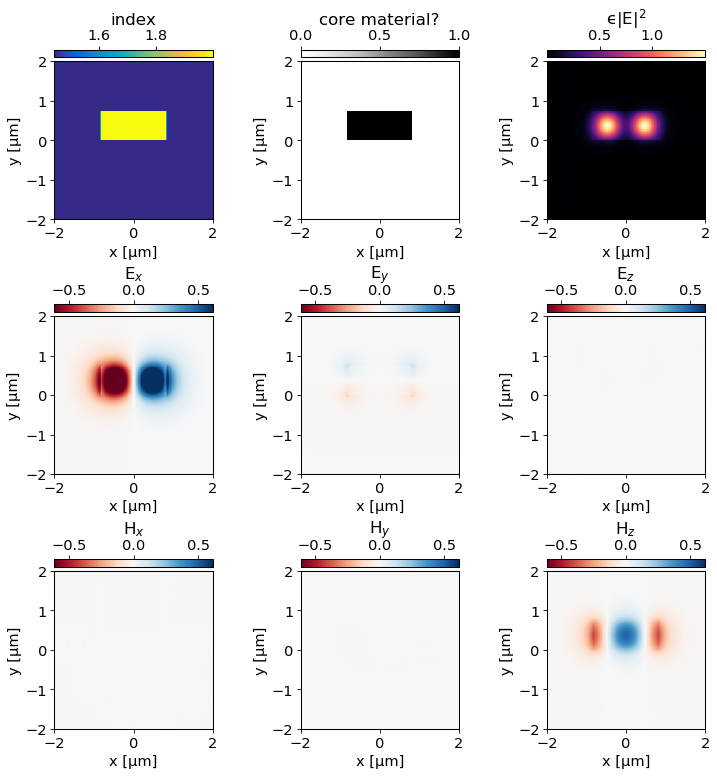

In [185]:
plot_soln(params,2)

In [231]:
params = {'λ': 1550*u.nm,        # free space wavelength
          'w_top':1650*u.nm,
          'θ': 0,                # sidewall internal angle at top of core, degrees
          't_core': 730 * u.nm,  # core thickness
          't_etch': 730 * u.nm,  # partial (or complete) etch depth
          'band': 1,             # band soln index
          'mat_core': 'Si3N4',
          'mat_clad': 'SiO2',
          'mat_subs':None,
          'Xgrid': 4,            # x lattice vector
          'Ygrid': 4,            # y lattice vector
          'n_points': 64,        # number of k-points simulated
          'n_bands': 1,          # number of bands simulated
          'res': 64,             # real-space resolution
          'edge_gap':0,
         }


import time
res_list = (2**np.arange(2,9,1)).astype('int')
ng = np.zeros(len(res_list))
n_eff = np.zeros(len(res_list))
dt = np.zeros(len(res_list))

for rind,rr in enumerate(res_list):
    params['res']=rr
    try:
        t0 = time.time()
        def_geom(params)
        solve(params,store_fields=False)
        dt[rind] = time.time()-t0
        n_eff[rind] = params['n_eff'][0]
        ng[rind] = params['ng'][0]
    except:
        pass

Working in 2 dimensions.
Grid size is 16 x 16 x 1.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (4, 0, 0)
     (0, 4, 0)
     (0, 0, 1)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (0.25, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.365,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.825,0.73,0)
          (0.825,0.73,0)
          (0.825,0,0)
          (-0.825,0,0)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
epsilon: 2.08532-3.98541, mean 2.22837, harm. mean 2.17368, 100% > 1, 7.52812% "fill"
Initializing fields to random numbers...
Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 16 x 16 x 1.
Solving for 1 bands at a t

          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.825,0.73,0)
          (0.825,0.73,0)
          (0.825,0,0)
          (-0.825,0,0)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: .
1 k-points
  Vector3<0.0, 0.0, 1.1729268913133881>
elapsed time for initialization: 0.019474267959594727
solve_kpoint (0,0,1.17293):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 1 iterations.
freqs:, 1, 0, 0, 1.17293, 1.17293, 0.645161
elapsed time for k point: 0.005112886428833008
Fixing e-field (band 1) phase by -0.540213 + -0.841529i; max ampl. = 0.684675
TE mode!

total elapsed time for run: 0.02792668342590332
done
kvals:, 0.6451612903225806, 1, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.1729268913133881
Working in 2 dimensions.
Grid size is 64 x 64 x 1.
Solving for 1 bands at a time.
Creating Maxwell data...
Me

1 k-points
  Vector3<0.0, 0.0, 1.1755768424746469>
elapsed time for initialization: 0.04658365249633789
solve_kpoint (0,0,1.17558):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 5 iterations.
freqs:, 1, 0, 0, 1.17558, 1.17558, 0.645173
elapsed time for k point: 0.10453367233276367
total elapsed time for run: 0.15173935890197754
done
find-k 1 at 1.1755768424746469: 1.211732212791361e-05
Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 128 x 128 x 1.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (4, 0, 0)
     (0, 4, 0)
     (0, 0, 1)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (0.25, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.365,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.825,0.73,0)
          (0.825,0.

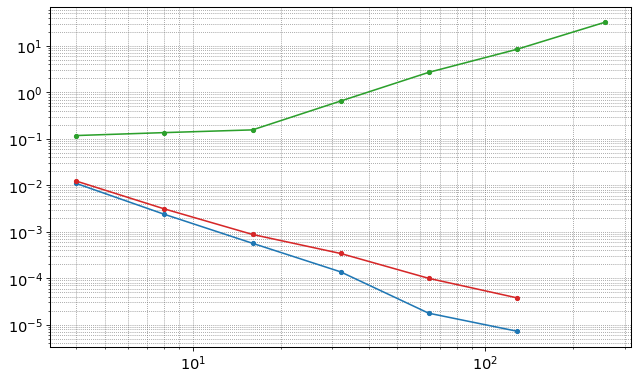

In [238]:
δn_eff = np.abs(n_eff - n_eff[-1])/n_eff[-1]
δng = np.abs(ng - ng[-1])/ng[-1]
plt.loglog(res_list[:-1],δn_eff[:-1],'.-C0')
plt.loglog(res_list[:-1],δng[:-1],'.-C3')
plt.loglog(res_list,dt,'.-C2')

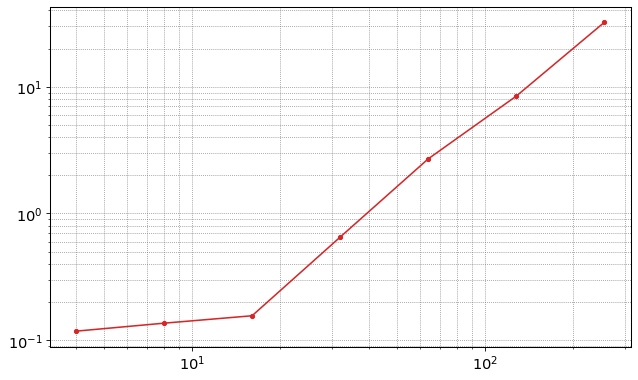

In [235]:
δn_eff = np.abs(n_eff - n_eff[-1])/n_eff[-1]
δng = np.abs(ng - ng[-1])/ng[-1]


In [234]:
dt

array([ 0.11774492,  0.13613081,  0.1557796 ,  0.65041375,  2.69511485,
        8.43109894, 32.23252654])

In [203]:
params['n_eff'][0]

1.822368080369828

In [213]:
params['k_soln'][0] * params['λ'].to(u.um).m

1.822368080369828

In [215]:
ng

array([2, 2, 2, 2, 2, 2])